In [ ]:
# import sys
# !{sys.executable} -m pip install imbalanced-learn --user
# !{sys.executable} -m pip install hyperopt --user

In [1]:
import numpy
from time import time
from sklearn.model_selection import GridSearchCV
from hyperopt import tpe, fmin, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from copy import deepcopy

from newsgac import config
from newsgac.genres import genre_codes
from newsgac.learners import learners, LearnerSVC, LearnerNB, LearnerXGB, LearnerGB, LearnerMLP, LearnerRF, LearnerLGBM
from newsgac.pipelines.get_sk_pipeline import get_sk_pipeline
from newsgac.pipelines.utils import report
from xgboost import XGBClassifier


from newsgac import database
from newsgac.data_sources import DataSource
from newsgac.pipelines import Pipeline

# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
# from imblearn.combine import SMOTEENN, SMOTETomek
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/newsgac/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
[d.display_title for d in DataSource.objects.all()]

[u'N2BGS Training',
 u'N2BGS Testing',
 u'Linked NRC (2930)',
 u'BOW + 5 features (N2BGS train)',
 u'BOW + 5 features (N2BGS test)',
 u'nrc-1950-1994-a.txt',
 u'nrc-1950-1994-b.txt',
 u'nrc-1950-1994-c.txt',
 u'nrc-1950-1994-d.txt',
 u'nrc-1950-1994-e.txt',
 u'telegraaf-1950-1994-a.txt',
 u'telegraaf-1950-1994-b.txt',
 u'telegraaf-1950-1994-c.txt',
 u'telegraaf-1950-1994-d.txt',
 u'telegraaf-1950-1994-e.txt',
 u'volkskrant-1950-1995-a.txt',
 u'volkskrant-1950-1995-b.txt',
 u'volkskrant-1950-1995-c.txt',
 u'volkskrant-1950-1995-d.txt',
 u'volkskrant-1950-1995-e.txt',
 u'nrc-1965.txt',
 u'nrc-1985.txt',
 u'BOW + 9 features (N2BGS train)',
 u'BOW + 9 features (N2BGS test)',
 u'Linked NRC (2930/9 features)',
 u'BOW Train unique (9 features)',
 u'BOW Test unique (9 features)',
 u'Linked NRC (unique/9 features)',
 u'BOW Train unique (N3BGS/9 features)',
 u'N3BGS FROG Test',
 u'N3BGS FROG Train',
 u'BOW Test unique (N3BGS/9 features)']

In [3]:
[d.display_title for d in Pipeline.objects.all()]

[u'dummy frog',
 u'dummy bow',
 u'RF FROG',
 u'SVC FROG',
 u'XGB FROG',
 u'NB FROG',
 u'MLP FROG',
 u'RF BOW',
 u'SVC BOW',
 u'XGB BOW',
 u'NB BOW',
 u'MLP BOW',
 u'SVC LIN BOW',
 u'Erik MLP BOW (with stop-words)',
 u'Erik MLP BOW (5 features) ',
 u'Erik MLP BOW (9 features) ',
 u'Erik SVC BOW (9 features)',
 u'Erik RF BOW (9 features)',
 u'Erik XGB BOW (9 features)',
 u'Erik NB BOW (9 features)',
 u'Erik MLP unique 9 features',
 u'Erik NB unique (9 features)',
 u'Erik XGB unique (9 features)',
 u'Erik SVC unique (9 features)',
 u'Erik RF unique (9 features)',
 u'N3BGS MLP unique 9 features',
 u'N3BGS NB unique 9 features ',
 u'N3BGS SVC unique 9 features ',
 u'N3BGS RF unique 9 features',
 u'N3BGS XGB unique 9 features ',
 u'dummy n3bgs bow',
 u'dummy n3bgs frog',
 u'RF FROG N3BGS',
 u'SVC FROG N3BGS',
 u'XGB FROG N3BGS']

In [4]:
p = Pipeline.objects.all()[30]
print 'DataSource: ' + p.data_source.display_title
print 'NLP Tool: ' + p.nlp_tool.name
print 'Classifier: ' + p.learner.name
print 'Task status: ' + str(p.task.status)

DataSource: BOW Train unique (N3BGS/9 features)
NLP Tool: TF-IDF
Classifier: Support Vector
Task status: Status.SUCCESS


In [5]:
len(p.data_source.articles)

857

In [6]:
test_data_source = DataSource.objects.all()[31]
print 'Testing data source: ' + test_data_source.display_title

Testing data source: BOW Test unique (N3BGS/9 features)


In [7]:
skp = p.get_sk_pipeline()
skp_opt = deepcopy(skp)
skp_opt.steps.pop()
skp_opt.steps

[('CleanOCR', <newsgac.nlp_tools.transformers.CleanOCR at 0x7f8550114310>),
 ('StopWordRemoval',
  <newsgac.nlp_tools.transformers.StopWordRemoval at 0x7f8550114350>),
 ('FeatureExtraction', FeatureUnion(n_jobs=None,
         transformer_list=[('TFIDF', Pipeline(memory=None,
       steps=[('RemoveQuotes', <newsgac.nlp_tools.transformers.RemoveQuotes object at 0x7f8550114390>), ('TF-IDF', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
          dtype=<type 'numpy.float64'>, encoding=u'utf-8', input=u'content',
          lowercase=True, max_df=1.0, max_featu...        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
          vocabulary=None))]))],
         transformer_weights=None))]

In [8]:
texts = numpy.array([article.raw_text for article in p.data_source.articles])
labels = numpy.array([article.label for article in p.data_source.articles])

X = skp_opt.fit_transform(texts)

In [9]:
# get the test dataset for optimization accuracy
texts_test = numpy.array([article.raw_text for article in test_data_source.articles])
labels_test = numpy.array([article.label for article in test_data_source.articles])

X_test = skp_opt.transform(texts_test)

In [10]:
X_train = X
y_train = labels
y_test = labels_test

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [12]:
X_train.shape

(685, 8528)

In [13]:
y_val.shape

(172,)

In [14]:
importance_type_list = ['gain', 'weight', 'cover', 'total_gain', 'total_cover']
booster_list = ['gbtree', 'gblinear', 'dart']
max_depth_list = np.arange(1, 10, dtype=int)

In [15]:
def optimize(evals, trials, optimizer=tpe.suggest):
    space = {
#         'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'n_estimators': hp.choice('n_estimators', np.arange(10, 500, dtype=int)),
        'learning_rate': hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', max_depth_list),
#         'max_depth': hp.quniform('max_depth', 1, 30, 1),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'importance_type': hp.choice('importance_type', importance_type_list),
#         'eval_metric': 'auc',
#         'objective': 'binary:logistic',
        # Increase this number if you have more cores. Otherwise, remove it and it will default 
        # to the maxium number. 
#         'nthread': 48,
        'booster': hp.choice('booster', booster_list),
#         'tree_method': 'exact',
#         'silent': 1,
#         'seed': 42
    }
    best = fmin(score, space, algo=optimizer, max_evals=evals, trials=trials)
    pbar.close()
    return best

In [16]:
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

def score(params):
    eval_set=[(X_train, y_train), (X_val, y_val)]
    
    model = XGBClassifier(n_estimators = params['n_estimators'],
                          learning_rate = params['learning_rate'],
                            max_depth = params['max_depth'],
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'], 
                            gamma = params['gamma'],
                            colsample_bytree = params['colsample_bytree'],
                            importance_type = params['importance_type'],
                            booster=params['booster'],
                            objective = "multi:softprob",
                            n_jobs=24,
                            random_state=42,
                            silent=False,)

    model.fit(X_train, y_train, eval_set=eval_set, verbose=False)   

    train_acc = accuracy_score(y_train, model.predict(X_train))
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    test_loss = log_loss(y_test, model.predict_proba(X_test))
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    
    print('Parameters with this training accuracy {} and loss {} :'.format(train_acc, train_loss))
    print('Parameters with this testing accuracy {} and loss {} :'.format(test_acc, test_loss))
    print(params)
    pbar.update()
#     return {'loss': test_loss, 'status': STATUS_OK}
    return {'loss': -test_acc, 'status': STATUS_OK}

In [17]:
import time
from tqdm import tqdm
import numpy as np

trials = Trials()
cores = 48
start = time.time()
evaluations = 1000
pbar = tqdm(total=evaluations, desc="Hyperopt")
best_param = optimize(evals=evaluations,
                      optimizer=tpe.suggest,
                      trials=trials)
print("------------------------------------")
print("The best hyperparameters are: ", "\n")
print(best_param)
end = time.time()
print('Time elapsed to optimize {0} executions: {1}'.format(evaluations, end - start))
best_param['importance_type'] = importance_type_list[best_param['importance_type']]
best_param['booster'] = booster_list[best_param['booster']]
best_param['max_depth'] = max_depth_list[best_param['max_depth']]
print('\n Best score:')
score(best_param)

Hyperopt:   0%|          | 1/1000 [00:19<5:26:34, 19.61s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.211387486613 :
Parameters with this testing accuracy 0.210526315789 and loss 2.7098758204 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.45, 'min_child_weight': 4.0, 'n_estimators': 486, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 1.0, 'booster': 'dart'}


Hyperopt:   0%|          | 2/1000 [00:23<4:09:55, 15.03s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.217478549114 :
Parameters with this testing accuracy 0.210526315789 and loss 2.44236802807 :
{'colsample_bytree': 1.0, 'learning_rate': 0.5, 'min_child_weight': 5.0, 'n_estimators': 84, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.75, 'booster': 'dart'}


Hyperopt:   0%|          | 3/1000 [00:41<4:21:03, 15.71s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.169447634639 :
Parameters with this testing accuracy 0.221052631579 and loss 2.56279872754 :
{'colsample_bytree': 1.0, 'learning_rate': 0.225, 'min_child_weight': 5.0, 'n_estimators': 492, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:   0%|          | 4/1000 [00:54<4:07:35, 14.92s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.208908137479 :
Parameters with this testing accuracy 0.336842105263 and loss 2.24955617223 :
{'colsample_bytree': 0.9, 'learning_rate': 0.325, 'min_child_weight': 3.0, 'n_estimators': 299, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:   0%|          | 5/1000 [00:59<3:19:40, 12.04s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883507 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876593 :
{'colsample_bytree': 0.9, 'learning_rate': 0.35000000000000003, 'min_child_weight': 3.0, 'n_estimators': 277, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.9, 'booster': 'gblinear'}


Hyperopt:   1%|          | 6/1000 [01:18<3:51:42, 13.99s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.167015870959 :
Parameters with this testing accuracy 0.221052631579 and loss 2.78948235612 :
{'colsample_bytree': 0.55, 'learning_rate': 0.35000000000000003, 'min_child_weight': 4.0, 'n_estimators': 474, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.65, 'booster': 'dart'}


Hyperopt:   1%|          | 7/1000 [01:31<3:47:42, 13.76s/it]

Parameters with this training accuracy 1.0 and loss 0.158922613551 :
Parameters with this testing accuracy 0.305263157895 and loss 2.24856121746 :
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.225, 'min_child_weight': 3.0, 'n_estimators': 229, 'subsample': 0.8500000000000001, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.65, 'booster': 'dart'}


Hyperopt:   1%|          | 8/1000 [01:34<2:52:11, 10.41s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883646 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876342 :
{'colsample_bytree': 0.65, 'learning_rate': 0.47500000000000003, 'min_child_weight': 4.0, 'n_estimators': 128, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gblinear'}


Hyperopt:   1%|          | 9/1000 [01:47<3:05:32, 11.23s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.211031745732 :
Parameters with this testing accuracy 0.273684210526 and loss 2.26471344822 :
{'colsample_bytree': 0.55, 'learning_rate': 0.5, 'min_child_weight': 4.0, 'n_estimators': 293, 'subsample': 0.9, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9, 'booster': 'dart'}


Hyperopt:   1%|          | 10/1000 [01:49<2:19:02,  8.43s/it]

Parameters with this training accuracy 0.978102189781 and loss 0.322006796212 :
Parameters with this testing accuracy 0.252631578947 and loss 2.35757681371 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.375, 'min_child_weight': 4.0, 'n_estimators': 35, 'subsample': 0.65, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:   1%|          | 11/1000 [01:56<2:15:26,  8.22s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883472 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876593 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.225, 'min_child_weight': 4.0, 'n_estimators': 411, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}


Hyperopt:   1%|          | 12/1000 [02:02<2:02:10,  7.42s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883194 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876091 :
{'colsample_bytree': 1.0, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 288, 'subsample': 0.9, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.8, 'booster': 'gblinear'}


Hyperopt:   1%|▏         | 13/1000 [02:13<2:21:17,  8.59s/it]

Parameters with this training accuracy 1.0 and loss 0.141337818424 :
Parameters with this testing accuracy 0.221052631579 and loss 2.50974609558 :
{'colsample_bytree': 0.9, 'learning_rate': 0.30000000000000004, 'min_child_weight': 3.0, 'n_estimators': 240, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.55, 'booster': 'dart'}


Hyperopt:   1%|▏         | 14/1000 [02:16<1:54:05,  6.94s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76773244865 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77285711138 :
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 6.0, 'n_estimators': 154, 'subsample': 1.0, 'importance_type': 'total_cover', 'max_depth': 9, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}


Hyperopt:   2%|▏         | 15/1000 [02:20<1:38:43,  6.01s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.186718391882 :
Parameters with this testing accuracy 0.326315789474 and loss 2.35920727697 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.42500000000000004, 'min_child_weight': 3.0, 'n_estimators': 100, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:   2%|▏         | 16/1000 [02:23<1:22:32,  5.03s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.7676432359 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77318180235 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 135, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}


Hyperopt:   2%|▏         | 17/1000 [02:28<1:23:21,  5.09s/it]

Parameters with this training accuracy 0.978102189781 and loss 0.390210430088 :
Parameters with this testing accuracy 0.326315789474 and loss 2.20536002411 :
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 84, 'subsample': 0.8, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 0.8, 'booster': 'dart'}


Hyperopt:   2%|▏         | 18/1000 [02:29<1:02:19,  3.81s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763882985 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327807075 :
{'colsample_bytree': 0.75, 'learning_rate': 0.5, 'min_child_weight': 3.0, 'n_estimators': 28, 'subsample': 0.65, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}


Hyperopt:   2%|▏         | 19/1000 [02:42<1:46:57,  6.54s/it]

Parameters with this training accuracy 1.0 and loss 0.123710466571 :
Parameters with this testing accuracy 0.315789473684 and loss 2.26131251158 :
{'colsample_bytree': 0.75, 'learning_rate': 0.35000000000000003, 'min_child_weight': 2.0, 'n_estimators': 246, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.55, 'booster': 'dart'}


Hyperopt:   2%|▏         | 20/1000 [02:46<1:35:07,  5.82s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883298 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876342 :
{'colsample_bytree': 0.65, 'learning_rate': 0.375, 'min_child_weight': 1.0, 'n_estimators': 213, 'subsample': 1.0, 'importance_type': 'total_gain', 'max_depth': 3, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}


Hyperopt:   2%|▏         | 21/1000 [03:07<2:48:50, 10.35s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.187383606708 :
Parameters with this testing accuracy 0.336842105263 and loss 2.20700750457 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 409, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:   2%|▏         | 22/1000 [03:22<3:11:21, 11.74s/it]

Parameters with this training accuracy 1.0 and loss 0.205166229695 :
Parameters with this testing accuracy 0.315789473684 and loss 2.22230160427 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 284, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:   2%|▏         | 23/1000 [03:37<3:27:39, 12.75s/it]

Parameters with this training accuracy 1.0 and loss 0.172747466772 :
Parameters with this testing accuracy 0.336842105263 and loss 2.19342314646 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.275, 'min_child_weight': 2.0, 'n_estimators': 299, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:   2%|▏         | 24/1000 [03:43<2:53:03, 10.64s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.201986847769 :
Parameters with this testing accuracy 0.273684210526 and loss 2.19107314587 :
{'colsample_bytree': 0.8, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 108, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:   2%|▎         | 25/1000 [03:50<2:38:52,  9.78s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.197872756197 :
Parameters with this testing accuracy 0.368421052632 and loss 2.17159735812 :
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.30000000000000004, 'min_child_weight': 2.0, 'n_estimators': 300, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:   3%|▎         | 26/1000 [03:56<2:17:28,  8.47s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.202359286467 :
Parameters with this testing accuracy 0.315789473684 and loss 2.14654101063 :
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.275, 'min_child_weight': 1.0, 'n_estimators': 201, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:   3%|▎         | 27/1000 [03:59<1:52:02,  6.91s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.230132980526 :
Parameters with this testing accuracy 0.389473684211 and loss 2.13337725993 :
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.2, 'min_child_weight': 2.0, 'n_estimators': 117, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:   3%|▎         | 28/1000 [04:02<1:34:14,  5.82s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.237060208673 :
Parameters with this testing accuracy 0.336842105263 and loss 2.149308691 :
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.2, 'min_child_weight': 2.0, 'n_estimators': 117, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:   3%|▎         | 29/1000 [04:10<1:41:57,  6.30s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.201252486692 :
Parameters with this testing accuracy 0.378947368421 and loss 2.13940015514 :
{'colsample_bytree': 0.8, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 300, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:   3%|▎         | 30/1000 [04:22<2:09:09,  7.99s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.192860315871 :
Parameters with this testing accuracy 0.336842105263 and loss 2.20135504655 :
{'colsample_bytree': 0.8, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 488, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:   3%|▎         | 31/1000 [04:31<2:13:33,  8.27s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.193405761456 :
Parameters with this testing accuracy 0.357894736842 and loss 2.15881899138 :
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 355, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:   3%|▎         | 32/1000 [04:34<1:50:21,  6.84s/it]

Parameters with this training accuracy 0.940145985401 and loss 0.428443653087 :
Parameters with this testing accuracy 0.263157894737 and loss 2.43536016768 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 5.0, 'n_estimators': 224, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:   3%|▎         | 33/1000 [04:53<2:48:41, 10.47s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.171449821557 :
Parameters with this testing accuracy 0.357894736842 and loss 2.17911702418 :
{'colsample_bytree': 1.0, 'learning_rate': 0.25, 'min_child_weight': 1.0, 'n_estimators': 300, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:   3%|▎         | 34/1000 [05:02<2:40:30,  9.97s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.191837560167 :
Parameters with this testing accuracy 0.336842105263 and loss 2.15657139524 :
{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'min_child_weight': 2.0, 'n_estimators': 157, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:   4%|▎         | 35/1000 [05:10<2:32:37,  9.49s/it]

Parameters with this training accuracy 0.970802919708 and loss 0.46502863608 :
Parameters with this testing accuracy 0.347368421053 and loss 2.14761904266 :
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 326, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:   4%|▎         | 36/1000 [05:22<2:41:13, 10.03s/it]

Parameters with this training accuracy 0.985401459854 and loss 0.26138808968 :
Parameters with this testing accuracy 0.263157894737 and loss 2.45480499026 :
{'colsample_bytree': 0.9, 'learning_rate': 0.125, 'min_child_weight': 6.0, 'n_estimators': 340, 'subsample': 0.75, 'importance_type': 'total_gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:   4%|▎         | 37/1000 [05:24<2:05:54,  7.84s/it]

Parameters with this training accuracy 0.988321167883 and loss 0.260491361396 :
Parameters with this testing accuracy 0.336842105263 and loss 2.14449621588 :
{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'min_child_weight': 2.0, 'n_estimators': 113, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:   4%|▍         | 38/1000 [05:31<1:59:39,  7.46s/it]

Parameters with this training accuracy 0.986861313869 and loss 0.28374718062 :
Parameters with this testing accuracy 0.210526315789 and loss 2.47778834058 :
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.25, 'min_child_weight': 5.0, 'n_estimators': 163, 'subsample': 0.65, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:   4%|▍         | 39/1000 [05:50<2:53:44, 10.85s/it]

Parameters with this training accuracy 1.0 and loss 0.169509743439 :
Parameters with this testing accuracy 0.357894736842 and loss 2.15406477406 :
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 315, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.7000000000000001, 'booster': 'dart'}


Hyperopt:   4%|▍         | 40/1000 [05:52<2:13:20,  8.33s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.211549584954 :
Parameters with this testing accuracy 0.242105263158 and loss 2.2759020453 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.42500000000000004, 'min_child_weight': 2.0, 'n_estimators': 50, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:   4%|▍         | 41/1000 [05:58<1:59:48,  7.50s/it]

Parameters with this training accuracy 0.986861313869 and loss 0.247996258482 :
Parameters with this testing accuracy 0.336842105263 and loss 2.28177428536 :
{'colsample_bytree': 1.0, 'learning_rate': 0.17500000000000002, 'min_child_weight': 3.0, 'n_estimators': 379, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:   4%|▍         | 42/1000 [06:09<2:17:17,  8.60s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.187411261784 :
Parameters with this testing accuracy 0.315789473684 and loss 2.27752821939 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.325, 'min_child_weight': 1.0, 'n_estimators': 365, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.8500000000000001, 'booster': 'dart'}


Hyperopt:   4%|▍         | 43/1000 [06:29<3:11:13, 11.99s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.194891230136 :
Parameters with this testing accuracy 0.368421052632 and loss 2.18293731983 :
{'colsample_bytree': 0.9, 'learning_rate': 0.225, 'min_child_weight': 2.0, 'n_estimators': 499, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:   4%|▍         | 44/1000 [06:35<2:45:34, 10.39s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883055 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876593 :
{'colsample_bytree': 1.0, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 341, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.5, 'booster': 'gblinear'}


Hyperopt:   4%|▍         | 45/1000 [06:36<1:59:52,  7.53s/it]

Parameters with this training accuracy 0.944525547445 and loss 0.557755124466 :
Parameters with this testing accuracy 0.294736842105 and loss 2.30405551348 :
{'colsample_bytree': 0.8, 'learning_rate': 0.30000000000000004, 'min_child_weight': 1.0, 'n_estimators': 21, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.75, 'booster': 'dart'}


Hyperopt:   5%|▍         | 46/1000 [06:50<2:29:25,  9.40s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.226921488044 :
Parameters with this testing accuracy 0.210526315789 and loss 2.57971957318 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.225, 'min_child_weight': 5.0, 'n_estimators': 468, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:   5%|▍         | 47/1000 [06:57<2:18:32,  8.72s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883612 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327848485 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 354, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}


Hyperopt:   5%|▍         | 48/1000 [07:22<3:37:11, 13.69s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.182685928939 :
Parameters with this testing accuracy 0.305263157895 and loss 2.30549858307 :
{'colsample_bytree': 0.65, 'learning_rate': 0.25, 'min_child_weight': 1.0, 'n_estimators': 406, 'subsample': 0.9500000000000001, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:   5%|▍         | 49/1000 [07:46<4:24:34, 16.69s/it]

Parameters with this training accuracy 1.0 and loss 0.150429165665 :
Parameters with this testing accuracy 0.368421052632 and loss 2.19809688583 :
{'colsample_bytree': 0.9, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 352, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.65, 'booster': 'dart'}


Hyperopt:   5%|▌         | 50/1000 [07:48<3:15:49, 12.37s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763891895 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77326570812 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 104, 'subsample': 0.8500000000000001, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.9, 'booster': 'gblinear'}


Hyperopt:   5%|▌         | 51/1000 [07:58<3:01:17, 11.46s/it]

Parameters with this training accuracy 1.0 and loss 0.161004008525 :
Parameters with this testing accuracy 0.336842105263 and loss 2.32286761763 :
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.375, 'min_child_weight': 1.0, 'n_estimators': 345, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:   5%|▌         | 52/1000 [08:06<2:45:31, 10.48s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.365525144439 :
Parameters with this testing accuracy 0.368421052632 and loss 2.14404336614 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 118, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 9, 'gamma': 0.8, 'booster': 'dart'}


Hyperopt:   5%|▌         | 53/1000 [08:14<2:31:59,  9.63s/it]

Parameters with this training accuracy 0.986861313869 and loss 0.237241932294 :
Parameters with this testing accuracy 0.273684210526 and loss 2.48087823155 :
{'colsample_bytree': 0.75, 'learning_rate': 0.325, 'min_child_weight': 4.0, 'n_estimators': 321, 'subsample': 0.75, 'importance_type': 'total_gain', 'max_depth': 2, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:   5%|▌         | 54/1000 [08:20<2:17:02,  8.69s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883055 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876844 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.4, 'min_child_weight': 3.0, 'n_estimators': 318, 'subsample': 0.65, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}


Hyperopt:   6%|▌         | 55/1000 [08:40<3:12:04, 12.19s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.17604858363 :
Parameters with this testing accuracy 0.305263157895 and loss 2.18999002843 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 382, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:   6%|▌         | 56/1000 [08:59<3:42:43, 14.16s/it]

Parameters with this training accuracy 1.0 and loss 0.116921550295 :
Parameters with this testing accuracy 0.357894736842 and loss 2.27912241333 :
{'colsample_bytree': 0.8, 'learning_rate': 0.47500000000000003, 'min_child_weight': 1.0, 'n_estimators': 432, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:   6%|▌         | 57/1000 [09:01<2:45:44, 10.55s/it]

Parameters with this training accuracy 0.98102189781 and loss 0.276635389788 :
Parameters with this testing accuracy 0.347368421053 and loss 2.24289551544 :
{'colsample_bytree': 0.9, 'learning_rate': 0.275, 'min_child_weight': 3.0, 'n_estimators': 64, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.9, 'booster': 'dart'}


Hyperopt:   6%|▌         | 58/1000 [09:10<2:35:49,  9.92s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.7676388302 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876593 :
{'colsample_bytree': 1.0, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 436, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.8500000000000001, 'booster': 'gblinear'}


Hyperopt:   6%|▌         | 59/1000 [09:16<2:18:29,  8.83s/it]

Parameters with this training accuracy 0.979562043796 and loss 0.285856407253 :
Parameters with this testing accuracy 0.242105263158 and loss 2.43998160691 :
{'colsample_bytree': 0.75, 'learning_rate': 0.2, 'min_child_weight': 6.0, 'n_estimators': 263, 'subsample': 0.9, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:   6%|▌         | 60/1000 [09:43<3:41:31, 14.14s/it]

Parameters with this training accuracy 1.0 and loss 0.179644193541 :
Parameters with this testing accuracy 0.263157894737 and loss 2.28334607413 :
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.325, 'min_child_weight': 2.0, 'n_estimators': 428, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:   6%|▌         | 61/1000 [09:50<3:08:13, 12.03s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.220444933524 :
Parameters with this testing accuracy 0.326315789474 and loss 2.2783460472 :
{'colsample_bytree': 0.5, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 111, 'subsample': 0.75, 'importance_type': 'total_gain', 'max_depth': 8, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:   6%|▌         | 62/1000 [09:54<2:32:10,  9.73s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883089 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876593 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 208, 'subsample': 0.6000000000000001, 'importance_type': 'cover', 'max_depth': 1, 'gamma': 0.9, 'booster': 'gblinear'}


Hyperopt:   6%|▋         | 63/1000 [10:09<2:57:58, 11.40s/it]

Parameters with this training accuracy 1.0 and loss 0.174764749923 :
Parameters with this testing accuracy 0.294736842105 and loss 2.26569441273 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.30000000000000004, 'min_child_weight': 2.0, 'n_estimators': 378, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:   6%|▋         | 64/1000 [10:12<2:15:14,  8.67s/it]

Parameters with this training accuracy 0.983941605839 and loss 0.278788931349 :
Parameters with this testing accuracy 0.252631578947 and loss 2.33432810645 :
{'colsample_bytree': 0.8, 'learning_rate': 0.225, 'min_child_weight': 4.0, 'n_estimators': 72, 'subsample': 0.9500000000000001, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.65, 'booster': 'dart'}


Hyperopt:   6%|▋         | 65/1000 [10:21<2:20:06,  8.99s/it]

Parameters with this training accuracy 1.0 and loss 0.179762210153 :
Parameters with this testing accuracy 0.315789473684 and loss 2.1884268307 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 174, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 5, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:   7%|▋         | 66/1000 [10:22<1:41:32,  6.52s/it]

Parameters with this training accuracy 0.83795620438 and loss 0.935435977045 :
Parameters with this testing accuracy 0.368421052632 and loss 2.27164606389 :
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.25, 'min_child_weight': 2.0, 'n_estimators': 16, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:   7%|▋         | 67/1000 [10:31<1:53:36,  7.31s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.187786054946 :
Parameters with this testing accuracy 0.368421052632 and loss 2.18337798871 :
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.35000000000000003, 'min_child_weight': 2.0, 'n_estimators': 344, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:   7%|▋         | 68/1000 [10:40<2:01:45,  7.84s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.199951802398 :
Parameters with this testing accuracy 0.294736842105 and loss 2.44502393931 :
{'colsample_bytree': 1.0, 'learning_rate': 0.4, 'min_child_weight': 3.0, 'n_estimators': 342, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:   7%|▋         | 69/1000 [10:54<2:27:36,  9.51s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.180213978513 :
Parameters with this testing accuracy 0.336842105263 and loss 2.21881912342 :
{'colsample_bytree': 0.9, 'learning_rate': 0.275, 'min_child_weight': 1.0, 'n_estimators': 497, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:   7%|▋         | 70/1000 [11:01<2:17:49,  8.89s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.190700474826 :
Parameters with this testing accuracy 0.378947368421 and loss 2.18160539483 :
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.35000000000000003, 'min_child_weight': 2.0, 'n_estimators': 272, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:   7%|▋         | 71/1000 [11:05<1:52:32,  7.27s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.20572193991 :
Parameters with this testing accuracy 0.336842105263 and loss 2.304425942 :
{'colsample_bytree': 0.9, 'learning_rate': 0.45, 'min_child_weight': 2.0, 'n_estimators': 116, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:   7%|▋         | 72/1000 [11:20<2:31:17,  9.78s/it]

Parameters with this training accuracy 1.0 and loss 0.157377599683 :
Parameters with this testing accuracy 0.357894736842 and loss 2.18620628848 :
{'colsample_bytree': 1.0, 'learning_rate': 0.35000000000000003, 'min_child_weight': 1.0, 'n_estimators': 408, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:   7%|▋         | 73/1000 [11:41<3:22:42, 13.12s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.198782333355 :
Parameters with this testing accuracy 0.315789473684 and loss 2.22966216038 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.2, 'min_child_weight': 3.0, 'n_estimators': 435, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:   7%|▋         | 74/1000 [11:50<3:04:32, 11.96s/it]

Parameters with this training accuracy 1.0 and loss 0.166179592779 :
Parameters with this testing accuracy 0.347368421053 and loss 2.2248773054 :
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.30000000000000004, 'min_child_weight': 2.0, 'n_estimators': 348, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 2, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:   8%|▊         | 75/1000 [12:14<3:59:22, 15.53s/it]

Parameters with this training accuracy 1.0 and loss 0.139488745097 :
Parameters with this testing accuracy 0.315789473684 and loss 2.14206591976 :
{'colsample_bytree': 1.0, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 498, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:   8%|▊         | 76/1000 [12:23<3:26:18, 13.40s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.199450803042 :
Parameters with this testing accuracy 0.368421052632 and loss 2.2465393556 :
{'colsample_bytree': 0.9, 'learning_rate': 0.4, 'min_child_weight': 2.0, 'n_estimators': 150, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:   8%|▊         | 77/1000 [12:26<2:41:24, 10.49s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.21029882646 :
Parameters with this testing accuracy 0.294736842105 and loss 2.30124865196 :
{'colsample_bytree': 0.8, 'learning_rate': 0.42500000000000004, 'min_child_weight': 1.0, 'n_estimators': 126, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:   8%|▊         | 78/1000 [12:33<2:22:08,  9.25s/it]

Parameters with this training accuracy 0.985401459854 and loss 0.265931549303 :
Parameters with this testing accuracy 0.368421052632 and loss 2.18669523547 :
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 127, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:   8%|▊         | 79/1000 [12:38<2:03:42,  8.06s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883194 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327875338 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.225, 'min_child_weight': 1.0, 'n_estimators': 272, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.8500000000000001, 'booster': 'gblinear'}


Hyperopt:   8%|▊         | 80/1000 [12:43<1:48:03,  7.05s/it]

Parameters with this training accuracy 0.963503649635 and loss 0.347387867245 :
Parameters with this testing accuracy 0.294736842105 and loss 2.50815821943 :
{'colsample_bytree': 0.75, 'learning_rate': 0.25, 'min_child_weight': 5.0, 'n_estimators': 219, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.9500000000000001, 'booster': 'dart'}


Hyperopt:   8%|▊         | 81/1000 [12:46<1:31:09,  5.95s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.199787134466 :
Parameters with this testing accuracy 0.347368421053 and loss 2.15442739908 :
{'colsample_bytree': 1.0, 'learning_rate': 0.375, 'min_child_weight': 2.0, 'n_estimators': 117, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:   8%|▊         | 82/1000 [13:01<2:13:00,  8.69s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.200948704326 :
Parameters with this testing accuracy 0.389473684211 and loss 2.19203453995 :
{'colsample_bytree': 0.65, 'learning_rate': 0.275, 'min_child_weight': 2.0, 'n_estimators': 357, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 5, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:   8%|▊         | 83/1000 [13:15<2:34:56, 10.14s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.211346285486 :
Parameters with this testing accuracy 0.294736842105 and loss 2.33979845339 :
{'colsample_bytree': 0.65, 'learning_rate': 0.325, 'min_child_weight': 3.0, 'n_estimators': 331, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 5, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:   8%|▊         | 84/1000 [13:22<2:21:11,  9.25s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.211337984422 :
Parameters with this testing accuracy 0.263157894737 and loss 2.29639931158 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.275, 'min_child_weight': 1.0, 'n_estimators': 138, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 5, 'gamma': 1.0, 'booster': 'dart'}


Hyperopt:   8%|▊         | 85/1000 [13:25<1:54:17,  7.49s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.223235238959 :
Parameters with this testing accuracy 0.294736842105 and loss 2.42739556926 :
{'colsample_bytree': 0.65, 'learning_rate': 0.45, 'min_child_weight': 3.0, 'n_estimators': 80, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 5, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:   9%|▊         | 86/1000 [13:31<1:47:01,  7.03s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883577 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876091 :
{'colsample_bytree': 0.55, 'learning_rate': 0.2, 'min_child_weight': 4.0, 'n_estimators': 282, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 5, 'gamma': 0.8, 'booster': 'gblinear'}


Hyperopt:   9%|▊         | 87/1000 [13:47<2:27:53,  9.72s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.191417458781 :
Parameters with this testing accuracy 0.336842105263 and loss 2.20572607435 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.375, 'min_child_weight': 2.0, 'n_estimators': 356, 'subsample': 0.65, 'importance_type': 'total_gain', 'max_depth': 5, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:   9%|▉         | 88/1000 [13:54<2:15:41,  8.93s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.202716800351 :
Parameters with this testing accuracy 0.252631578947 and loss 2.50298995997 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.47500000000000003, 'min_child_weight': 3.0, 'n_estimators': 232, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 3, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:   9%|▉         | 89/1000 [14:08<2:37:09, 10.35s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.195990064268 :
Parameters with this testing accuracy 0.4 and loss 2.12687184693 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 259, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:   9%|▉         | 90/1000 [14:25<3:06:14, 12.28s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.194559428538 :
Parameters with this testing accuracy 0.326315789474 and loss 2.17740818895 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 262, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.8500000000000001, 'booster': 'dart'}


Hyperopt:   9%|▉         | 91/1000 [14:25<2:13:05,  8.78s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76829434381 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77234844158 :
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 15, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.75, 'booster': 'gblinear'}


Hyperopt:   9%|▉         | 92/1000 [14:31<1:59:14,  7.88s/it]

Parameters with this training accuracy 0.884671532847 and loss 0.724601771136 :
Parameters with this testing accuracy 0.263157894737 and loss 2.21133895214 :
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 5.0, 'n_estimators': 140, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:   9%|▉         | 93/1000 [14:49<2:42:04, 10.72s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.2749473778 :
Parameters with this testing accuracy 0.368421052632 and loss 2.0953116282 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 323, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:   9%|▉         | 94/1000 [14:58<2:34:05, 10.20s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.229819584244 :
Parameters with this testing accuracy 0.378947368421 and loss 2.13435296985 :
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 198, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  10%|▉         | 95/1000 [15:05<2:22:53,  9.47s/it]

Parameters with this training accuracy 0.986861313869 and loss 0.250696073563 :
Parameters with this testing accuracy 0.294736842105 and loss 2.33880451531 :
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 259, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:  10%|▉         | 96/1000 [15:10<2:01:59,  8.10s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763882602 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327865299 :
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 258, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 5, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}


Hyperopt:  10%|▉         | 97/1000 [15:22<2:16:20,  9.06s/it]

Parameters with this training accuracy 0.982481751825 and loss 0.28874247139 :
Parameters with this testing accuracy 0.231578947368 and loss 2.50487501158 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.225, 'min_child_weight': 6.0, 'n_estimators': 297, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 9, 'gamma': 0.8500000000000001, 'booster': 'dart'}


Hyperopt:  10%|▉         | 98/1000 [15:35<2:34:41, 10.29s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.193720393088 :
Parameters with this testing accuracy 0.347368421053 and loss 2.2104712703 :
{'colsample_bytree': 0.75, 'learning_rate': 0.17500000000000002, 'min_child_weight': 2.0, 'n_estimators': 254, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  10%|▉         | 99/1000 [15:37<1:59:01,  7.93s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.204124187674 :
Parameters with this testing accuracy 0.326315789474 and loss 2.18968578769 :
{'colsample_bytree': 0.65, 'learning_rate': 0.30000000000000004, 'min_child_weight': 1.0, 'n_estimators': 33, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 8, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  10%|█         | 100/1000 [15:39<1:30:14,  6.02s/it]

Parameters with this training accuracy 0.948905109489 and loss 0.483281962215 :
Parameters with this testing accuracy 0.305263157895 and loss 2.29436090898 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.275, 'min_child_weight': 2.0, 'n_estimators': 19, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 7, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  10%|█         | 101/1000 [15:45<1:31:47,  6.13s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883472 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.7732787584 :
{'colsample_bytree': 0.55, 'learning_rate': 0.25, 'min_child_weight': 3.0, 'n_estimators': 328, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}


Hyperopt:  10%|█         | 102/1000 [15:57<1:59:51,  8.01s/it]

Parameters with this training accuracy 1.0 and loss 0.160688101836 :
Parameters with this testing accuracy 0.326315789474 and loss 2.16699016709 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 257, 'subsample': 0.65, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:  10%|█         | 103/1000 [16:05<1:57:12,  7.84s/it]

Parameters with this training accuracy 0.985401459854 and loss 0.314478528205 :
Parameters with this testing accuracy 0.357894736842 and loss 2.17299067888 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 175, 'subsample': 0.75, 'importance_type': 'total_gain', 'max_depth': 3, 'gamma': 0.8, 'booster': 'dart'}


Hyperopt:  10%|█         | 104/1000 [16:22<2:39:51, 10.70s/it]

Parameters with this training accuracy 0.988321167883 and loss 0.298627526025 :
Parameters with this testing accuracy 0.4 and loss 2.10958376684 :
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 313, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  10%|█         | 105/1000 [16:43<3:22:30, 13.58s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.260789072416 :
Parameters with this testing accuracy 0.252631578947 and loss 2.37874650516 :
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 308, 'subsample': 1.0, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  11%|█         | 106/1000 [16:57<3:25:19, 13.78s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.218340219633 :
Parameters with this testing accuracy 0.421052631579 and loss 2.08213621107 :
{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 302, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  11%|█         | 107/1000 [17:18<3:58:39, 16.04s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.207800308444 :
Parameters with this testing accuracy 0.431578947368 and loss 2.10013418951 :
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 399, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  11%|█         | 108/1000 [17:24<3:13:45, 13.03s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763882707 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.7732777721 :
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 307, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.75, 'booster': 'gblinear'}


Hyperopt:  11%|█         | 109/1000 [17:44<3:42:58, 15.02s/it]

Parameters with this training accuracy 1.0 and loss 0.180928419203 :
Parameters with this testing accuracy 0.4 and loss 2.07766225191 :
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 362, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:  11%|█         | 110/1000 [18:04<4:03:56, 16.45s/it]

Parameters with this training accuracy 1.0 and loss 0.158507470736 :
Parameters with this testing accuracy 0.357894736842 and loss 2.09105706933 :
{'colsample_bytree': 0.8, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 302, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'dart'}


Hyperopt:  11%|█         | 111/1000 [18:15<3:40:01, 14.85s/it]

Parameters with this training accuracy 1.0 and loss 0.174430878368 :
Parameters with this testing accuracy 0.410526315789 and loss 2.11435858721 :
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 197, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  11%|█         | 112/1000 [18:28<3:31:27, 14.29s/it]

Parameters with this training accuracy 1.0 and loss 0.147582693533 :
Parameters with this testing accuracy 0.410526315789 and loss 2.07555947541 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 231, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  11%|█▏        | 113/1000 [18:32<2:48:13, 11.38s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.342885923668 :
Parameters with this testing accuracy 0.357894736842 and loss 2.1735710075 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 68, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  11%|█▏        | 114/1000 [18:45<2:52:56, 11.71s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.369524619484 :
Parameters with this testing accuracy 0.357894736842 and loss 2.19462061313 :
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 197, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  12%|█▏        | 115/1000 [18:47<2:10:27,  8.84s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883229 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327754121 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 97, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}


Hyperopt:  12%|█▏        | 116/1000 [19:13<3:28:22, 14.14s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.206170928242 :
Parameters with this testing accuracy 0.284210526316 and loss 2.30286052737 :
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 5.0, 'n_estimators': 441, 'subsample': 0.9500000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'dart'}


Hyperopt:  12%|█▏        | 117/1000 [19:24<3:12:58, 13.11s/it]

Parameters with this training accuracy 1.0 and loss 0.147117678403 :
Parameters with this testing accuracy 0.389473684211 and loss 2.14947938027 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 187, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 9, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  12%|█▏        | 118/1000 [19:37<3:10:24, 12.95s/it]

Parameters with this training accuracy 0.983941605839 and loss 0.406007713213 :
Parameters with this testing accuracy 0.431578947368 and loss 2.14473578099 :
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 231, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  12%|█▏        | 119/1000 [19:44<2:46:49, 11.36s/it]

Parameters with this training accuracy 0.865693430657 and loss 0.94469905153 :
Parameters with this testing accuracy 0.336842105263 and loss 2.25795576133 :
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 159, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  12%|█▏        | 120/1000 [20:00<3:07:20, 12.77s/it]

Parameters with this training accuracy 1.0 and loss 0.158276007953 :
Parameters with this testing accuracy 0.294736842105 and loss 2.22439820192 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 311, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  12%|█▏        | 121/1000 [20:06<2:36:34, 10.69s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76764116287 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77320980273 :
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 298, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}


Hyperopt:  12%|█▏        | 122/1000 [20:19<2:47:40, 11.46s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.217155383758 :
Parameters with this testing accuracy 0.347368421053 and loss 2.23327609904 :
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 242, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'dart'}


Hyperopt:  12%|█▏        | 123/1000 [20:35<3:03:47, 12.57s/it]

Parameters with this training accuracy 1.0 and loss 0.174369440233 :
Parameters with this testing accuracy 0.336842105263 and loss 2.11264638779 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 325, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  12%|█▏        | 124/1000 [20:50<3:17:19, 13.52s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.178730604133 :
Parameters with this testing accuracy 0.242105263158 and loss 2.33023663793 :
{'colsample_bytree': 0.75, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 487, 'subsample': 0.9, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  12%|█▎        | 125/1000 [21:11<3:47:27, 15.60s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.192394351781 :
Parameters with this testing accuracy 0.378947368421 and loss 2.11825607005 :
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 399, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:  13%|█▎        | 126/1000 [21:24<3:35:32, 14.80s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.18215969989 :
Parameters with this testing accuracy 0.210526315789 and loss 2.5622321005 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 451, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  13%|█▎        | 127/1000 [21:24<2:33:22, 10.54s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.7694084519 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77216306235 :
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 13, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 9, 'gamma': 0.8500000000000001, 'booster': 'gblinear'}


Hyperopt:  13%|█▎        | 128/1000 [21:48<3:28:32, 14.35s/it]

Parameters with this training accuracy 0.986861313869 and loss 0.260035153121 :
Parameters with this testing accuracy 0.305263157895 and loss 2.16465114131 :
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 391, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.8, 'booster': 'dart'}


Hyperopt:  13%|█▎        | 129/1000 [21:53<2:48:33, 11.61s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.216275604273 :
Parameters with this testing accuracy 0.294736842105 and loss 2.34714146456 :
{'colsample_bytree': 0.75, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 71, 'subsample': 1.0, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:  13%|█▎        | 130/1000 [21:55<2:07:40,  8.81s/it]

Parameters with this training accuracy 0.738686131387 and loss 1.83415317944 :
Parameters with this testing accuracy 0.315789473684 and loss 2.51761219251 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 42, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  13%|█▎        | 131/1000 [22:06<2:16:37,  9.43s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.198649005285 :
Parameters with this testing accuracy 0.368421052632 and loss 2.17212822835 :
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 255, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:  13%|█▎        | 132/1000 [22:11<1:55:17,  7.97s/it]

Parameters with this training accuracy 0.973722627737 and loss 0.301341086108 :
Parameters with this testing accuracy 0.294736842105 and loss 2.37783709633 :
{'colsample_bytree': 0.8, 'learning_rate': 0.17500000000000002, 'min_child_weight': 4.0, 'n_estimators': 279, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  13%|█▎        | 133/1000 [22:13<1:30:43,  6.28s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763885909 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.7732728406 :
{'colsample_bytree': 0.9, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 78, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.9, 'booster': 'gblinear'}


Hyperopt:  13%|█▎        | 134/1000 [22:16<1:18:55,  5.47s/it]

Parameters with this training accuracy 0.794160583942 and loss 1.56649815714 :
Parameters with this testing accuracy 0.326315789474 and loss 2.4273992802 :
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 61, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.6000000000000001, 'booster': 'dart'}


Hyperopt:  14%|█▎        | 135/1000 [22:28<1:43:45,  7.20s/it]

Parameters with this training accuracy 1.0 and loss 0.177668362005 :
Parameters with this testing accuracy 0.336842105263 and loss 2.12926551437 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 269, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  14%|█▎        | 136/1000 [22:53<3:03:40, 12.75s/it]

Parameters with this training accuracy 1.0 and loss 0.17360982485 :
Parameters with this testing accuracy 0.336842105263 and loss 2.16457309776 :
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 485, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:  14%|█▎        | 137/1000 [22:59<2:34:11, 10.72s/it]

Parameters with this training accuracy 0.820437956204 and loss 0.880786229757 :
Parameters with this testing accuracy 0.284210526316 and loss 2.3234383565 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 6.0, 'n_estimators': 148, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  14%|█▍        | 138/1000 [23:08<2:26:32, 10.20s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.213910681096 :
Parameters with this testing accuracy 0.326315789474 and loss 2.22834946666 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 142, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  14%|█▍        | 139/1000 [23:18<2:25:47, 10.16s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883124 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327875338 :
{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 399, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.65, 'booster': 'gblinear'}


Hyperopt:  14%|█▍        | 140/1000 [23:23<2:02:42,  8.56s/it]

Parameters with this training accuracy 0.816058394161 and loss 1.05815659119 :
Parameters with this testing accuracy 0.347368421053 and loss 2.23763518879 :
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 302, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  14%|█▍        | 141/1000 [23:37<2:24:09, 10.07s/it]

Parameters with this training accuracy 0.983941605839 and loss 0.262570962474 :
Parameters with this testing accuracy 0.294736842105 and loss 2.50809337325 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 5.0, 'n_estimators': 322, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.8, 'booster': 'dart'}


Hyperopt:  14%|█▍        | 142/1000 [23:49<2:32:47, 10.68s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.206367457674 :
Parameters with this testing accuracy 0.357894736842 and loss 2.12578298838 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 234, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  14%|█▍        | 143/1000 [23:58<2:25:07, 10.16s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.170078331016 :
Parameters with this testing accuracy 0.4 and loss 2.1570863197 :
{'colsample_bytree': 0.75, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 267, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:  14%|█▍        | 144/1000 [24:09<2:28:34, 10.41s/it]

Parameters with this training accuracy 0.983941605839 and loss 0.282690550527 :
Parameters with this testing accuracy 0.294736842105 and loss 2.24020333126 :
{'colsample_bytree': 0.9, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 248, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:  14%|█▍        | 145/1000 [24:15<2:08:53,  9.05s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883438 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.7732787584 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 275, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'gblinear'}


Hyperopt:  15%|█▍        | 146/1000 [24:37<3:05:09, 13.01s/it]

Parameters with this training accuracy 1.0 and loss 0.135944572362 :
Parameters with this testing accuracy 0.4 and loss 2.08827371122 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 410, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  15%|█▍        | 147/1000 [24:48<2:56:44, 12.43s/it]

Parameters with this training accuracy 1.0 and loss 0.154608090218 :
Parameters with this testing accuracy 0.368421052632 and loss 2.11262942811 :
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 197, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  15%|█▍        | 148/1000 [24:56<2:37:03, 11.06s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.305982574084 :
Parameters with this testing accuracy 0.410526315789 and loss 2.1220250312 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 122, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  15%|█▍        | 149/1000 [25:23<3:45:47, 15.92s/it]

Parameters with this training accuracy 1.0 and loss 0.170683869689 :
Parameters with this testing accuracy 0.378947368421 and loss 2.0887448094 :
{'colsample_bytree': 0.9, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 443, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  15%|█▌        | 150/1000 [25:43<4:01:19, 17.03s/it]

Parameters with this training accuracy 1.0 and loss 0.136291561834 :
Parameters with this testing accuracy 0.326315789474 and loss 2.18721078063 :
{'colsample_bytree': 0.75, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 453, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  15%|█▌        | 151/1000 [25:57<3:47:56, 16.11s/it]

Parameters with this training accuracy 1.0 and loss 0.148358477863 :
Parameters with this testing accuracy 0.389473684211 and loss 2.12625474753 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 231, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  15%|█▌        | 152/1000 [26:23<4:31:01, 19.18s/it]

Parameters with this training accuracy 1.0 and loss 0.163255029429 :
Parameters with this testing accuracy 0.368421052632 and loss 2.08992295593 :
{'colsample_bytree': 0.9, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 433, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  15%|█▌        | 153/1000 [26:33<3:51:28, 16.40s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.187052267096 :
Parameters with this testing accuracy 0.389473684211 and loss 2.12043052657 :
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 182, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  15%|█▌        | 154/1000 [26:42<3:18:31, 14.08s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.259585377003 :
Parameters with this testing accuracy 0.410526315789 and loss 2.1069347938 :
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 147, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  16%|█▌        | 155/1000 [26:58<3:27:15, 14.72s/it]

Parameters with this training accuracy 1.0 and loss 0.163084941227 :
Parameters with this testing accuracy 0.357894736842 and loss 2.15657417144 :
{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 360, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  16%|█▌        | 156/1000 [27:23<4:11:09, 17.86s/it]

Parameters with this training accuracy 1.0 and loss 0.174582499812 :
Parameters with this testing accuracy 0.357894736842 and loss 2.08663363233 :
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 434, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  16%|█▌        | 157/1000 [27:50<4:48:16, 20.52s/it]

Parameters with this training accuracy 1.0 and loss 0.152938913558 :
Parameters with this testing accuracy 0.336842105263 and loss 2.21105025346 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 471, 'subsample': 0.9, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  16%|█▌        | 158/1000 [28:14<5:04:31, 21.70s/it]

Parameters with this training accuracy 1.0 and loss 0.149641942981 :
Parameters with this testing accuracy 0.378947368421 and loss 2.13220294839 :
{'colsample_bytree': 0.8, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 439, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  16%|█▌        | 159/1000 [28:20<3:58:55, 17.05s/it]

Parameters with this training accuracy 0.983941605839 and loss 0.273858507735 :
Parameters with this testing accuracy 0.315789473684 and loss 2.12956655028 :
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 419, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  16%|█▌        | 160/1000 [28:37<3:58:26, 17.03s/it]

Parameters with this training accuracy 1.0 and loss 0.143637868922 :
Parameters with this testing accuracy 0.378947368421 and loss 2.19009784189 :
{'colsample_bytree': 0.8, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 395, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  16%|█▌        | 161/1000 [28:55<3:58:07, 17.03s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.176665045001 :
Parameters with this testing accuracy 0.326315789474 and loss 2.33182321992 :
{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 303, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.55, 'booster': 'dart'}


Hyperopt:  16%|█▌        | 162/1000 [28:56<2:53:09, 12.40s/it]

Parameters with this training accuracy 0.972262773723 and loss 0.436103102225 :
Parameters with this testing accuracy 0.347368421053 and loss 2.19590151232 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 2.0, 'n_estimators': 36, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  16%|█▋        | 163/1000 [29:00<2:16:35,  9.79s/it]

Parameters with this training accuracy 0.973722627737 and loss 0.707791266563 :
Parameters with this testing accuracy 0.4 and loss 2.28722317282 :
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 57, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  16%|█▋        | 164/1000 [29:09<2:13:23,  9.57s/it]

Parameters with this training accuracy 1.0 and loss 0.172026565916 :
Parameters with this testing accuracy 0.336842105263 and loss 2.16917087146 :
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 202, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  16%|█▋        | 165/1000 [29:31<3:06:34, 13.41s/it]

Parameters with this training accuracy 0.988321167883 and loss 0.259469155979 :
Parameters with this testing accuracy 0.326315789474 and loss 2.15428020653 :
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 477, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  17%|█▋        | 166/1000 [29:36<2:29:29, 10.75s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763882915 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.7732787584 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 231, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 9, 'gamma': 0.5, 'booster': 'gblinear'}


Hyperopt:  17%|█▋        | 167/1000 [29:45<2:24:49, 10.43s/it]

Parameters with this training accuracy 1.0 and loss 0.114112815555 :
Parameters with this testing accuracy 0.263157894737 and loss 2.38234607141 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.5, 'min_child_weight': 1.0, 'n_estimators': 189, 'subsample': 0.6000000000000001, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  17%|█▋        | 168/1000 [29:59<2:37:46, 11.38s/it]

Parameters with this training accuracy 0.988321167883 and loss 0.294187794063 :
Parameters with this testing accuracy 0.410526315789 and loss 2.09554943748 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 211, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.9500000000000001, 'booster': 'dart'}


Hyperopt:  17%|█▋        | 169/1000 [30:17<3:06:30, 13.47s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.245019785536 :
Parameters with this testing accuracy 0.326315789474 and loss 2.21380740494 :
{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 304, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.9500000000000001, 'booster': 'dart'}


Hyperopt:  17%|█▋        | 170/1000 [30:19<2:16:28,  9.87s/it]

Parameters with this training accuracy 0.929927007299 and loss 0.6286141094 :
Parameters with this testing accuracy 0.326315789474 and loss 2.19524665179 :
{'colsample_bytree': 0.65, 'learning_rate': 0.225, 'min_child_weight': 1.0, 'n_estimators': 67, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  17%|█▋        | 171/1000 [30:39<2:56:50, 12.80s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.265739860698 :
Parameters with this testing accuracy 0.389473684211 and loss 2.10699978859 :
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 359, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  17%|█▋        | 172/1000 [30:59<3:28:30, 15.11s/it]

Parameters with this training accuracy 1.0 and loss 0.166111143861 :
Parameters with this testing accuracy 0.421052631579 and loss 2.10295411039 :
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 396, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  17%|█▋        | 173/1000 [31:05<2:52:02, 12.48s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.196065546661 :
Parameters with this testing accuracy 0.347368421053 and loss 2.14063249191 :
{'colsample_bytree': 0.75, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 131, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  17%|█▋        | 174/1000 [31:13<2:31:47, 11.03s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883089 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.7732787584 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 396, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.75, 'booster': 'gblinear'}


Hyperopt:  18%|█▊        | 175/1000 [31:23<2:27:46, 10.75s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.216655606031 :
Parameters with this testing accuracy 0.315789473684 and loss 2.28400113466 :
{'colsample_bytree': 0.8, 'learning_rate': 0.17500000000000002, 'min_child_weight': 4.0, 'n_estimators': 260, 'subsample': 0.6000000000000001, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:  18%|█▊        | 176/1000 [31:37<2:41:09, 11.74s/it]

Parameters with this training accuracy 1.0 and loss 0.174458324793 :
Parameters with this testing accuracy 0.410526315789 and loss 2.07014839145 :
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 285, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  18%|█▊        | 177/1000 [31:40<2:04:32,  9.08s/it]

Parameters with this training accuracy 0.96496350365 and loss 0.604181929389 :
Parameters with this testing accuracy 0.305263157895 and loss 2.28338145629 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 52, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:  18%|█▊        | 178/1000 [32:00<2:48:54, 12.33s/it]

Parameters with this training accuracy 1.0 and loss 0.1762797191 :
Parameters with this testing accuracy 0.347368421053 and loss 2.16415150182 :
{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 459, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:  18%|█▊        | 179/1000 [32:01<2:00:34,  8.81s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76797802918 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77251770873 :
{'colsample_bytree': 0.65, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 12, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.8, 'booster': 'gblinear'}


Hyperopt:  18%|█▊        | 180/1000 [32:14<2:18:26, 10.13s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.336950607312 :
Parameters with this testing accuracy 0.378947368421 and loss 2.12234574662 :
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 250, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  18%|█▊        | 181/1000 [32:30<2:43:16, 11.96s/it]

Parameters with this training accuracy 1.0 and loss 0.149990255181 :
Parameters with this testing accuracy 0.231578947368 and loss 2.64454868148 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.42500000000000004, 'min_child_weight': 3.0, 'n_estimators': 390, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.7000000000000001, 'booster': 'dart'}


Hyperopt:  18%|█▊        | 182/1000 [32:37<2:24:42, 10.61s/it]

Parameters with this training accuracy 0.976642335766 and loss 0.299422242124 :
Parameters with this testing accuracy 0.273684210526 and loss 2.45807450424 :
{'colsample_bytree': 0.8, 'learning_rate': 0.17500000000000002, 'min_child_weight': 6.0, 'n_estimators': 190, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  18%|█▊        | 183/1000 [32:41<1:54:24,  8.40s/it]

Parameters with this training accuracy 0.986861313869 and loss 0.298501411784 :
Parameters with this testing accuracy 0.4 and loss 2.16327840023 :
{'colsample_bytree': 0.75, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 48, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  18%|█▊        | 184/1000 [32:51<2:03:17,  9.07s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.197559500925 :
Parameters with this testing accuracy 0.326315789474 and loss 2.16020207144 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 266, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:  18%|█▊        | 185/1000 [32:56<1:44:22,  7.68s/it]

Parameters with this training accuracy 0.969343065693 and loss 0.391678832662 :
Parameters with this testing accuracy 0.326315789474 and loss 2.25010196571 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 94, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  19%|█▊        | 186/1000 [32:59<1:27:57,  6.48s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.7676392691 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77324913175 :
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 180, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 1.0, 'booster': 'gblinear'}


Hyperopt:  19%|█▊        | 187/1000 [33:15<2:05:22,  9.25s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.230713053691 :
Parameters with this testing accuracy 0.410526315789 and loss 2.10096184354 :
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 481, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  19%|█▉        | 188/1000 [33:17<1:34:44,  7.00s/it]

Parameters with this training accuracy 0.953284671533 and loss 0.501543496149 :
Parameters with this testing accuracy 0.315789473684 and loss 2.19535926322 :
{'colsample_bytree': 0.75, 'learning_rate': 0.225, 'min_child_weight': 1.0, 'n_estimators': 83, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.75, 'booster': 'dart'}


Hyperopt:  19%|█▉        | 189/1000 [33:38<2:31:58, 11.24s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.214059990213 :
Parameters with this testing accuracy 0.368421052632 and loss 2.13422530256 :
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 482, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  19%|█▉        | 190/1000 [33:48<2:27:29, 10.93s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.236315579276 :
Parameters with this testing accuracy 0.326315789474 and loss 2.25340730118 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 253, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  19%|█▉        | 191/1000 [33:54<2:07:25,  9.45s/it]

Parameters with this training accuracy 0.986861313869 and loss 0.483106969139 :
Parameters with this testing accuracy 0.347368421053 and loss 2.25758722409 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 82, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  19%|█▉        | 192/1000 [34:17<3:02:22, 13.54s/it]

Parameters with this training accuracy 1.0 and loss 0.14928340232 :
Parameters with this testing accuracy 0.378947368421 and loss 2.18084704351 :
{'colsample_bytree': 0.75, 'learning_rate': 0.325, 'min_child_weight': 1.0, 'n_estimators': 467, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:  19%|█▉        | 193/1000 [34:21<2:23:43, 10.69s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763882672 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327868311 :
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 196, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}


Hyperopt:  19%|█▉        | 194/1000 [34:28<2:05:56,  9.37s/it]

Parameters with this training accuracy 0.985401459854 and loss 0.316298760986 :
Parameters with this testing accuracy 0.284210526316 and loss 2.20059653444 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 462, 'subsample': 0.9500000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  20%|█▉        | 195/1000 [34:30<1:39:09,  7.39s/it]

Parameters with this training accuracy 0.976642335766 and loss 0.331382219081 :
Parameters with this testing accuracy 0.336842105263 and loss 2.28481234053 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.2, 'min_child_weight': 3.0, 'n_estimators': 49, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'dart'}


Hyperopt:  20%|█▉        | 196/1000 [34:41<1:53:49,  8.49s/it]

Parameters with this training accuracy 0.988321167883 and loss 0.324759078706 :
Parameters with this testing accuracy 0.326315789474 and loss 2.24809847184 :
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 195, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  20%|█▉        | 197/1000 [34:51<1:56:34,  8.71s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.174721842647 :
Parameters with this testing accuracy 0.357894736842 and loss 2.20778369571 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.25, 'min_child_weight': 2.0, 'n_estimators': 364, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:  20%|█▉        | 198/1000 [35:02<2:05:11,  9.37s/it]

Parameters with this training accuracy 0.972262773723 and loss 0.321390221176 :
Parameters with this testing accuracy 0.263157894737 and loss 2.34880390542 :
{'colsample_bytree': 0.75, 'learning_rate': 0.125, 'min_child_weight': 5.0, 'n_estimators': 327, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  20%|█▉        | 199/1000 [35:16<2:24:32, 10.83s/it]

Parameters with this training accuracy 1.0 and loss 0.173861199413 :
Parameters with this testing accuracy 0.368421052632 and loss 2.10771165071 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 423, 'subsample': 0.6000000000000001, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  20%|██        | 200/1000 [35:28<2:28:25, 11.13s/it]

Parameters with this training accuracy 0.982481751825 and loss 0.455711648504 :
Parameters with this testing accuracy 0.273684210526 and loss 2.2566625232 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 191, 'subsample': 0.9, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:  20%|██        | 201/1000 [35:40<2:32:04, 11.42s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.238300987903 :
Parameters with this testing accuracy 0.378947368421 and loss 2.106498155 :
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 221, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 1.0, 'booster': 'dart'}


Hyperopt:  20%|██        | 202/1000 [35:48<2:21:03, 10.61s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883194 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327877095 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.4, 'min_child_weight': 3.0, 'n_estimators': 464, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 9, 'gamma': 0.8500000000000001, 'booster': 'gblinear'}


Hyperopt:  20%|██        | 203/1000 [36:06<2:48:03, 12.65s/it]

Parameters with this training accuracy 1.0 and loss 0.129882142916 :
Parameters with this testing accuracy 0.305263157895 and loss 2.24210991063 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 320, 'subsample': 0.75, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  20%|██        | 204/1000 [36:14<2:31:07, 11.39s/it]

Parameters with this training accuracy 1.0 and loss 0.156048786819 :
Parameters with this testing accuracy 0.273684210526 and loss 2.48854262051 :
{'colsample_bytree': 0.65, 'learning_rate': 0.45, 'min_child_weight': 2.0, 'n_estimators': 228, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:  20%|██        | 205/1000 [36:24<2:24:57, 10.94s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.198495660918 :
Parameters with this testing accuracy 0.336842105263 and loss 2.19238414678 :
{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 136, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  21%|██        | 206/1000 [36:42<2:51:27, 12.96s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.195065128978 :
Parameters with this testing accuracy 0.336842105263 and loss 2.21401804221 :
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 361, 'subsample': 0.65, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  21%|██        | 207/1000 [36:58<3:05:22, 14.03s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.181564020055 :
Parameters with this testing accuracy 0.305263157895 and loss 2.10349766537 :
{'colsample_bytree': 0.9, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 314, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:  21%|██        | 208/1000 [37:01<2:19:16, 10.55s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883194 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876593 :
{'colsample_bytree': 0.75, 'learning_rate': 0.35000000000000003, 'min_child_weight': 2.0, 'n_estimators': 112, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gblinear'}


Hyperopt:  21%|██        | 209/1000 [37:13<2:23:44, 10.90s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.209716118459 :
Parameters with this testing accuracy 0.347368421053 and loss 2.15091185881 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 424, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.65, 'booster': 'dart'}


Hyperopt:  21%|██        | 210/1000 [37:27<2:37:59, 12.00s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.184156125127 :
Parameters with this testing accuracy 0.326315789474 and loss 2.28537766865 :
{'colsample_bytree': 0.75, 'learning_rate': 0.30000000000000004, 'min_child_weight': 1.0, 'n_estimators': 286, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  21%|██        | 211/1000 [37:36<2:26:43, 11.16s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.196571521035 :
Parameters with this testing accuracy 0.368421052632 and loss 2.23051589419 :
{'colsample_bytree': 0.8, 'learning_rate': 0.17500000000000002, 'min_child_weight': 2.0, 'n_estimators': 252, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 3, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  21%|██        | 212/1000 [37:41<1:59:31,  9.10s/it]

Parameters with this training accuracy 0.960583941606 and loss 0.491086220119 :
Parameters with this testing accuracy 0.357894736842 and loss 2.13871111642 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 85, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  21%|██▏       | 213/1000 [37:56<2:22:10, 10.84s/it]

Parameters with this training accuracy 1.0 and loss 0.123071242036 :
Parameters with this testing accuracy 0.294736842105 and loss 2.46630275136 :
{'colsample_bytree': 0.65, 'learning_rate': 0.375, 'min_child_weight': 2.0, 'n_estimators': 396, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  21%|██▏       | 214/1000 [38:02<2:04:09,  9.48s/it]

Parameters with this training accuracy 0.973722627737 and loss 0.574095869924 :
Parameters with this testing accuracy 0.336842105263 and loss 2.23290763246 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 155, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  22%|██▏       | 215/1000 [38:03<1:31:41,  7.01s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883333 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327877095 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.47500000000000003, 'min_child_weight': 3.0, 'n_estimators': 46, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.75, 'booster': 'gblinear'}


Hyperopt:  22%|██▏       | 216/1000 [38:13<1:43:19,  7.91s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.241597436542 :
Parameters with this testing accuracy 0.294736842105 and loss 2.26587237159 :
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 114, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.8500000000000001, 'booster': 'dart'}


Hyperopt:  22%|██▏       | 217/1000 [38:19<1:35:39,  7.33s/it]

Parameters with this training accuracy 0.940145985401 and loss 0.46112350125 :
Parameters with this testing accuracy 0.326315789474 and loss 2.24164597424 :
{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'min_child_weight': 5.0, 'n_estimators': 137, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:  22%|██▏       | 218/1000 [38:28<1:41:40,  7.80s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.173856191596 :
Parameters with this testing accuracy 0.326315789474 and loss 2.2257338467 :
{'colsample_bytree': 0.75, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 222, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  22%|██▏       | 219/1000 [38:47<2:25:50, 11.20s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.219757460487 :
Parameters with this testing accuracy 0.315789473684 and loss 2.16993398508 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 371, 'subsample': 0.65, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  22%|██▏       | 220/1000 [39:02<2:40:00, 12.31s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.180235217796 :
Parameters with this testing accuracy 0.336842105263 and loss 2.15843132824 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.225, 'min_child_weight': 1.0, 'n_estimators': 243, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  22%|██▏       | 221/1000 [39:09<2:17:22, 10.58s/it]

Parameters with this training accuracy 0.801459854015 and loss 1.00162431853 :
Parameters with this testing accuracy 0.305263157895 and loss 2.29306831123 :
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 5.0, 'n_estimators': 417, 'subsample': 0.75, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:  22%|██▏       | 222/1000 [39:16<2:05:57,  9.71s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883264 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327875589 :
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 392, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.65, 'booster': 'gblinear'}


Hyperopt:  22%|██▏       | 223/1000 [39:18<1:33:03,  7.19s/it]

Parameters with this training accuracy 0.951824817518 and loss 0.509191828001 :
Parameters with this testing accuracy 0.357894736842 and loss 2.16238155769 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 38, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  22%|██▏       | 224/1000 [39:22<1:21:21,  6.29s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.185252760319 :
Parameters with this testing accuracy 0.294736842105 and loss 2.20683143619 :
{'colsample_bytree': 0.75, 'learning_rate': 0.17500000000000002, 'min_child_weight': 2.0, 'n_estimators': 79, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.5, 'booster': 'dart'}


Hyperopt:  22%|██▎       | 225/1000 [39:24<1:06:25,  5.14s/it]

Parameters with this training accuracy 0.719708029197 and loss 1.38879501641 :
Parameters with this testing accuracy 0.273684210526 and loss 2.41447966977 :
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 6.0, 'n_estimators': 53, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  23%|██▎       | 226/1000 [39:31<1:11:09,  5.52s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.196970891275 :
Parameters with this testing accuracy 0.336842105263 and loss 2.12715103556 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 171, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:  23%|██▎       | 227/1000 [39:43<1:38:20,  7.63s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.167030621767 :
Parameters with this testing accuracy 0.284210526316 and loss 2.24376312404 :
{'colsample_bytree': 0.8, 'learning_rate': 0.25, 'min_child_weight': 3.0, 'n_estimators': 289, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  23%|██▎       | 228/1000 [39:45<1:16:14,  5.93s/it]

Parameters with this training accuracy 0.931386861314 and loss 1.78887635252 :
Parameters with this testing accuracy 0.357894736842 and loss 2.51965355873 :
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 25, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  23%|██▎       | 229/1000 [39:58<1:41:59,  7.94s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.200839009114 :
Parameters with this testing accuracy 0.368421052632 and loss 2.16909647575 :
{'colsample_bytree': 0.8, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 245, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 9, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  23%|██▎       | 230/1000 [40:07<1:45:43,  8.24s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883472 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876342 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 475, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.55, 'booster': 'gblinear'}


Hyperopt:  23%|██▎       | 231/1000 [40:29<2:41:36, 12.61s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.236452579869 :
Parameters with this testing accuracy 0.357894736842 and loss 2.15898174381 :
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 370, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.75, 'booster': 'dart'}


Hyperopt:  23%|██▎       | 232/1000 [40:43<2:46:37, 13.02s/it]

Parameters with this training accuracy 1.0 and loss 0.162708974149 :
Parameters with this testing accuracy 0.4 and loss 2.11920219466 :
{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 270, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  23%|██▎       | 233/1000 [40:46<2:06:14,  9.88s/it]

Parameters with this training accuracy 0.896350364964 and loss 0.697767941178 :
Parameters with this testing accuracy 0.326315789474 and loss 2.22880079229 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 45, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:  23%|██▎       | 234/1000 [40:53<1:53:35,  8.90s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.202822901763 :
Parameters with this testing accuracy 0.357894736842 and loss 2.13378701685 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 438, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  24%|██▎       | 235/1000 [40:56<1:33:36,  7.34s/it]

Parameters with this training accuracy 0.960583941606 and loss 0.555357828671 :
Parameters with this testing accuracy 0.410526315789 and loss 2.17223779151 :
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 70, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  24%|██▎       | 236/1000 [41:03<1:29:55,  7.06s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763882881 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876091 :
{'colsample_bytree': 0.75, 'learning_rate': 0.275, 'min_child_weight': 1.0, 'n_estimators': 332, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.8500000000000001, 'booster': 'gblinear'}


Hyperopt:  24%|██▎       | 237/1000 [41:06<1:14:38,  5.87s/it]

Parameters with this training accuracy 0.789781021898 and loss 1.57593901436 :
Parameters with this testing accuracy 0.294736842105 and loss 2.44077380707 :
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 56, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 5, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  24%|██▍       | 238/1000 [41:10<1:07:34,  5.32s/it]

Parameters with this training accuracy 0.932846715328 and loss 0.996432963101 :
Parameters with this testing accuracy 0.336842105263 and loss 2.34148260543 :
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 99, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.6000000000000001, 'booster': 'dart'}


Hyperopt:  24%|██▍       | 239/1000 [41:26<1:50:23,  8.70s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.233610028747 :
Parameters with this testing accuracy 0.389473684211 and loss 2.11795688279 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 329, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  24%|██▍       | 240/1000 [41:33<1:41:39,  8.03s/it]

Parameters with this training accuracy 1.0 and loss 0.12785905476 :
Parameters with this testing accuracy 0.263157894737 and loss 2.33412289337 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 106, 'subsample': 0.9500000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  24%|██▍       | 241/1000 [41:45<1:55:45,  9.15s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.196823178629 :
Parameters with this testing accuracy 0.389473684211 and loss 2.13499919802 :
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 273, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:  24%|██▍       | 242/1000 [41:55<2:00:35,  9.55s/it]

Parameters with this training accuracy 0.982481751825 and loss 0.308371143991 :
Parameters with this testing accuracy 0.326315789474 and loss 2.16612671363 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 230, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  24%|██▍       | 243/1000 [42:04<1:58:39,  9.41s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763882846 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876342 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 484, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}


Hyperopt:  24%|██▍       | 244/1000 [42:14<2:00:48,  9.59s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.169441810593 :
Parameters with this testing accuracy 0.336842105263 and loss 2.21613971784 :
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 2.0, 'n_estimators': 212, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  24%|██▍       | 245/1000 [42:19<1:43:37,  8.24s/it]

Parameters with this training accuracy 0.915328467153 and loss 0.616576383722 :
Parameters with this testing accuracy 0.305263157895 and loss 2.19058287497 :
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 103, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.8, 'booster': 'dart'}


Hyperopt:  25%|██▍       | 246/1000 [42:39<2:26:02, 11.62s/it]

Parameters with this training accuracy 1.0 and loss 0.166895427565 :
Parameters with this testing accuracy 0.273684210526 and loss 2.23970720846 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.325, 'min_child_weight': 1.0, 'n_estimators': 351, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  25%|██▍       | 247/1000 [42:41<1:50:30,  8.81s/it]

Parameters with this training accuracy 0.900729927007 and loss 0.768477192687 :
Parameters with this testing accuracy 0.315789473684 and loss 2.18757556596 :
{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 125, 'subsample': 0.65, 'importance_type': 'total_gain', 'max_depth': 1, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  25%|██▍       | 248/1000 [42:45<1:32:32,  7.38s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.260722111035 :
Parameters with this testing accuracy 0.315789473684 and loss 2.22818111075 :
{'colsample_bytree': 0.8, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 63, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  25%|██▍       | 249/1000 [42:51<1:25:38,  6.84s/it]

Parameters with this training accuracy 0.916788321168 and loss 0.7495562825 :
Parameters with this testing accuracy 0.347368421053 and loss 2.20132164296 :
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 220, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  25%|██▌       | 250/1000 [42:56<1:21:22,  6.51s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883194 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876342 :
{'colsample_bytree': 0.8, 'learning_rate': 0.225, 'min_child_weight': 3.0, 'n_estimators': 292, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}


Hyperopt:  25%|██▌       | 251/1000 [42:59<1:06:28,  5.33s/it]

Parameters with this training accuracy 1.0 and loss 0.158781316634 :
Parameters with this testing accuracy 0.336842105263 and loss 2.19047827274 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.30000000000000004, 'min_child_weight': 1.0, 'n_estimators': 41, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  25%|██▌       | 252/1000 [43:05<1:08:05,  5.46s/it]

Parameters with this training accuracy 0.982481751825 and loss 0.336103351953 :
Parameters with this testing accuracy 0.347368421053 and loss 2.15672970116 :
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 145, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.8500000000000001, 'booster': 'dart'}


Hyperopt:  25%|██▌       | 253/1000 [43:18<1:36:57,  7.79s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.203987048571 :
Parameters with this testing accuracy 0.336842105263 and loss 2.19603086616 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 310, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:  25%|██▌       | 254/1000 [43:35<2:12:41, 10.67s/it]

Parameters with this training accuracy 1.0 and loss 0.165745850233 :
Parameters with this testing accuracy 0.368421052632 and loss 2.15088155138 :
{'colsample_bytree': 0.9, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 375, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:  26%|██▌       | 255/1000 [43:48<2:19:15, 11.22s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.210757806321 :
Parameters with this testing accuracy 0.284210526316 and loss 2.31290758942 :
{'colsample_bytree': 0.8, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 156, 'subsample': 0.9, 'importance_type': 'total_cover', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  26%|██▌       | 256/1000 [43:55<2:03:59, 10.00s/it]

Parameters with this training accuracy 0.985401459854 and loss 0.586975042315 :
Parameters with this testing accuracy 0.336842105263 and loss 2.28322763255 :
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 129, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  26%|██▌       | 257/1000 [44:03<1:55:12,  9.30s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763882881 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876091 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 5.0, 'n_estimators': 402, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.55, 'booster': 'gblinear'}


Hyperopt:  26%|██▌       | 258/1000 [44:13<1:58:21,  9.57s/it]

Parameters with this training accuracy 0.983941605839 and loss 0.302145758417 :
Parameters with this testing accuracy 0.421052631579 and loss 2.05446247576 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 215, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  26%|██▌       | 259/1000 [44:19<1:45:20,  8.53s/it]

Parameters with this training accuracy 0.972262773723 and loss 0.473286434336 :
Parameters with this testing accuracy 0.442105263158 and loss 2.09717679157 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 123, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  26%|██▌       | 260/1000 [44:37<2:19:04, 11.28s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.265353660676 :
Parameters with this testing accuracy 0.378947368421 and loss 2.09327289627 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 422, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  26%|██▌       | 261/1000 [44:51<2:28:28, 12.06s/it]

Parameters with this training accuracy 0.985401459854 and loss 0.3642832736 :
Parameters with this testing accuracy 0.389473684211 and loss 2.11111204479 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 291, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  26%|██▌       | 262/1000 [45:08<2:47:25, 13.61s/it]

Parameters with this training accuracy 0.988321167883 and loss 0.288431751247 :
Parameters with this testing accuracy 0.294736842105 and loss 2.1780365425 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 425, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  26%|██▋       | 263/1000 [45:14<2:18:32, 11.28s/it]

Parameters with this training accuracy 0.913868613139 and loss 0.948420833562 :
Parameters with this testing accuracy 0.378947368421 and loss 2.26766656229 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 123, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  26%|██▋       | 264/1000 [45:22<2:05:46, 10.25s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.261519234096 :
Parameters with this testing accuracy 0.389473684211 and loss 2.12627850228 :
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 152, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  26%|██▋       | 265/1000 [45:30<2:00:26,  9.83s/it]

Parameters with this training accuracy 0.967883211679 and loss 0.392967901315 :
Parameters with this testing accuracy 0.315789473684 and loss 2.13825193734 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 215, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  27%|██▋       | 266/1000 [45:38<1:50:53,  9.06s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.263649639142 :
Parameters with this testing accuracy 0.326315789474 and loss 2.14187934381 :
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 149, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  27%|██▋       | 267/1000 [45:42<1:32:22,  7.56s/it]

Parameters with this training accuracy 0.890510948905 and loss 1.24816804607 :
Parameters with this testing accuracy 0.368421052632 and loss 2.40043907762 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 77, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  27%|██▋       | 268/1000 [45:58<2:03:26, 10.12s/it]

Parameters with this training accuracy 0.986861313869 and loss 0.292702766477 :
Parameters with this testing accuracy 0.294736842105 and loss 2.18446401422 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 429, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  27%|██▋       | 269/1000 [46:20<2:48:36, 13.84s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.203040533872 :
Parameters with this testing accuracy 0.389473684211 and loss 2.11643540695 :
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 401, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  27%|██▋       | 270/1000 [46:33<2:44:48, 13.55s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.211726885366 :
Parameters with this testing accuracy 0.326315789474 and loss 2.14640943876 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 295, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  27%|██▋       | 271/1000 [46:34<1:57:56,  9.71s/it]

Parameters with this training accuracy 0.604379562044 and loss 1.87019063273 :
Parameters with this testing accuracy 0.263157894737 and loss 2.44694321407 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 24, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  27%|██▋       | 272/1000 [46:38<1:37:15,  8.02s/it]

Parameters with this training accuracy 0.868613138686 and loss 1.27702029556 :
Parameters with this testing accuracy 0.368421052632 and loss 2.37440511678 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 81, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  27%|██▋       | 273/1000 [46:50<1:51:00,  9.16s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.199974856792 :
Parameters with this testing accuracy 0.4 and loss 2.10375993164 :
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 200, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  27%|██▋       | 274/1000 [47:01<1:58:52,  9.82s/it]

Parameters with this training accuracy 0.969343065693 and loss 0.470132197364 :
Parameters with this testing accuracy 0.368421052632 and loss 2.12906509034 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 249, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  28%|██▊       | 275/1000 [47:02<1:26:36,  7.17s/it]

Parameters with this training accuracy 0.759124087591 and loss 1.69746253647 :
Parameters with this testing accuracy 0.368421052632 and loss 2.47046700026 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 27, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  28%|██▊       | 276/1000 [47:12<1:35:45,  7.94s/it]

Parameters with this training accuracy 0.973722627737 and loss 0.375925663413 :
Parameters with this testing accuracy 0.305263157895 and loss 2.15404436182 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 227, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  28%|██▊       | 277/1000 [47:13<1:10:05,  5.82s/it]

Parameters with this training accuracy 0.76204379562 and loss 1.86384556737 :
Parameters with this testing accuracy 0.263157894737 and loss 2.56753308397 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 11, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  28%|██▊       | 278/1000 [47:14<52:24,  4.36s/it]  

Parameters with this training accuracy 0.597080291971 and loss 2.41054988151 :
Parameters with this testing accuracy 0.221052631579 and loss 2.68795887546 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 14, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  28%|██▊       | 279/1000 [47:38<2:05:20, 10.43s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.230619511042 :
Parameters with this testing accuracy 0.336842105263 and loss 2.11619108502 :
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 394, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 1.0, 'booster': 'dart'}


Hyperopt:  28%|██▊       | 280/1000 [47:41<1:36:32,  8.05s/it]

Parameters with this training accuracy 0.983941605839 and loss 0.345833402709 :
Parameters with this testing accuracy 0.357894736842 and loss 2.18040332779 :
{'colsample_bytree': 0.75, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 59, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  28%|██▊       | 281/1000 [47:52<1:47:42,  8.99s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.221546902203 :
Parameters with this testing accuracy 0.336842105263 and loss 2.1474330886 :
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 199, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  28%|██▊       | 282/1000 [48:04<1:57:23,  9.81s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.259757839979 :
Parameters with this testing accuracy 0.378947368421 and loss 2.14567580278 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 301, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  28%|██▊       | 283/1000 [48:24<2:33:45, 12.87s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.250176045709 :
Parameters with this testing accuracy 0.431578947368 and loss 2.10369265225 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 377, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  28%|██▊       | 284/1000 [48:49<3:18:41, 16.65s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.217969224104 :
Parameters with this testing accuracy 0.368421052632 and loss 2.13228289252 :
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 476, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  28%|██▊       | 285/1000 [48:53<2:34:18, 12.95s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.767664097 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77305151789 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 205, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gblinear'}


Hyperopt:  29%|██▊       | 286/1000 [49:15<3:05:41, 15.60s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.273505486477 :
Parameters with this testing accuracy 0.347368421053 and loss 2.14145990347 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 400, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  29%|██▊       | 287/1000 [49:35<3:18:23, 16.69s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.286490044826 :
Parameters with this testing accuracy 0.284210526316 and loss 2.19635519315 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 302, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'dart'}


Hyperopt:  29%|██▉       | 288/1000 [49:41<2:41:10, 13.58s/it]

Parameters with this training accuracy 0.988321167883 and loss 0.292407502202 :
Parameters with this testing accuracy 0.305263157895 and loss 2.13043499314 :
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 133, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  29%|██▉       | 289/1000 [49:45<2:05:42, 10.61s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.217268056183 :
Parameters with this testing accuracy 0.273684210526 and loss 2.41914877812 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.42500000000000004, 'min_child_weight': 2.0, 'n_estimators': 76, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  29%|██▉       | 290/1000 [50:08<2:51:20, 14.48s/it]

Parameters with this training accuracy 1.0 and loss 0.144155932585 :
Parameters with this testing accuracy 0.378947368421 and loss 2.09263086199 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 478, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  29%|██▉       | 291/1000 [50:15<2:25:18, 12.30s/it]

Parameters with this training accuracy 1.0 and loss 0.169378685826 :
Parameters with this testing accuracy 0.336842105263 and loss 2.10727716077 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 123, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  29%|██▉       | 292/1000 [50:20<1:59:33, 10.13s/it]

Parameters with this training accuracy 0.957664233577 and loss 0.637450341913 :
Parameters with this testing accuracy 0.410526315789 and loss 2.15913275653 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 93, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  29%|██▉       | 293/1000 [50:22<1:31:01,  7.73s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.7676415969 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77320101638 :
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 95, 'subsample': 0.65, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}


Hyperopt:  29%|██▉       | 294/1000 [50:43<2:14:52, 11.46s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.187222309272 :
Parameters with this testing accuracy 0.410526315789 and loss 2.07292112712 :
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 377, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  30%|██▉       | 295/1000 [51:07<3:01:49, 15.47s/it]

Parameters with this training accuracy 1.0 and loss 0.170228615602 :
Parameters with this testing accuracy 0.326315789474 and loss 2.15410217553 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 367, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'dart'}


Hyperopt:  30%|██▉       | 296/1000 [51:16<2:36:50, 13.37s/it]

Parameters with this training accuracy 1.0 and loss 0.180712953758 :
Parameters with this testing accuracy 0.357894736842 and loss 2.16927452146 :
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 173, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:  30%|██▉       | 297/1000 [51:19<2:00:58, 10.32s/it]

Parameters with this training accuracy 0.846715328467 and loss 0.939937331234 :
Parameters with this testing accuracy 0.389473684211 and loss 2.1737784188 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 194, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  30%|██▉       | 298/1000 [51:21<1:30:39,  7.75s/it]

Parameters with this training accuracy 0.718248175182 and loss 1.99972453918 :
Parameters with this testing accuracy 0.284210526316 and loss 2.57282247794 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 31, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  30%|██▉       | 299/1000 [51:39<2:07:17, 10.90s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.265547391188 :
Parameters with this testing accuracy 0.4 and loss 2.08096296889 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 399, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  30%|███       | 300/1000 [51:52<2:13:47, 11.47s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.253705675041 :
Parameters with this testing accuracy 0.305263157895 and loss 2.25050412526 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 233, 'subsample': 1.0, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  30%|███       | 301/1000 [52:00<2:00:39, 10.36s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763882811 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876844 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 412, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}


Hyperopt:  30%|███       | 302/1000 [52:22<2:41:40, 13.90s/it]

Parameters with this training accuracy 1.0 and loss 0.185105519959 :
Parameters with this testing accuracy 0.421052631579 and loss 2.06546559889 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 496, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  30%|███       | 303/1000 [52:24<2:02:12, 10.52s/it]

Parameters with this training accuracy 0.875912408759 and loss 1.40723163625 :
Parameters with this testing accuracy 0.315789473684 and loss 2.42597945991 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 65, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.55, 'booster': 'dart'}


Hyperopt:  30%|███       | 304/1000 [52:32<1:52:42,  9.72s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.56924144803 :
Parameters with this testing accuracy 0.368421052632 and loss 2.28260537355 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 130, 'subsample': 0.6000000000000001, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  30%|███       | 305/1000 [52:49<2:15:47, 11.72s/it]

Parameters with this training accuracy 1.0 and loss 0.161095954603 :
Parameters with this testing accuracy 0.378947368421 and loss 2.10991345448 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 373, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 5, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  31%|███       | 306/1000 [53:03<2:24:54, 12.53s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.208884714462 :
Parameters with this testing accuracy 0.431578947368 and loss 2.04896846808 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 386, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  31%|███       | 307/1000 [53:20<2:38:51, 13.75s/it]

Parameters with this training accuracy 1.0 and loss 0.105680690277 :
Parameters with this testing accuracy 0.284210526316 and loss 2.46539407234 :
{'colsample_bytree': 0.5, 'learning_rate': 0.5, 'min_child_weight': 1.0, 'n_estimators': 445, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  31%|███       | 308/1000 [53:38<2:53:31, 15.05s/it]

Parameters with this training accuracy 1.0 and loss 0.101729252985 :
Parameters with this testing accuracy 0.389473684211 and loss 2.18953198145 :
{'colsample_bytree': 0.55, 'learning_rate': 0.4, 'min_child_weight': 1.0, 'n_estimators': 489, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  31%|███       | 309/1000 [53:39<2:04:38, 10.82s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.7681006985 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77245690195 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 30, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gblinear'}


Hyperopt:  31%|███       | 310/1000 [53:50<2:07:15, 11.07s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.229024354106 :
Parameters with this testing accuracy 0.368421052632 and loss 2.15176761641 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 296, 'subsample': 0.6000000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  31%|███       | 311/1000 [54:07<2:25:33, 12.68s/it]

Parameters with this training accuracy 1.0 and loss 0.133998206772 :
Parameters with this testing accuracy 0.294736842105 and loss 2.12200917311 :
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 316, 'subsample': 0.65, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'dart'}


Hyperopt:  31%|███       | 312/1000 [54:16<2:11:38, 11.48s/it]

Parameters with this training accuracy 1.0 and loss 0.159679390699 :
Parameters with this testing accuracy 0.421052631579 and loss 2.09004509823 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 225, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  31%|███▏      | 313/1000 [54:26<2:09:03, 11.27s/it]

Parameters with this training accuracy 1.0 and loss 0.110142136306 :
Parameters with this testing accuracy 0.347368421053 and loss 2.27490463377 :
{'colsample_bytree': 0.55, 'learning_rate': 0.45, 'min_child_weight': 1.0, 'n_estimators': 305, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  31%|███▏      | 314/1000 [54:29<1:38:13,  8.59s/it]

Parameters with this training accuracy 0.643795620438 and loss 1.58492422234 :
Parameters with this testing accuracy 0.252631578947 and loss 2.50617387295 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 6.0, 'n_estimators': 55, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  32%|███▏      | 315/1000 [54:33<1:22:41,  7.24s/it]

Parameters with this training accuracy 1.0 and loss 0.116606722722 :
Parameters with this testing accuracy 0.326315789474 and loss 2.23976910071 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.375, 'min_child_weight': 1.0, 'n_estimators': 73, 'subsample': 0.6000000000000001, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  32%|███▏      | 316/1000 [54:49<1:52:31,  9.87s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.185095089097 :
Parameters with this testing accuracy 0.410526315789 and loss 2.05355940316 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 418, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  32%|███▏      | 317/1000 [54:51<1:27:25,  7.68s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883229 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327765917 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 119, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}


Hyperopt:  32%|███▏      | 318/1000 [54:58<1:24:38,  7.45s/it]

Parameters with this training accuracy 1.0 and loss 0.139472198632 :
Parameters with this testing accuracy 0.4 and loss 2.08487780785 :
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 164, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  32%|███▏      | 319/1000 [55:03<1:15:32,  6.66s/it]

Parameters with this training accuracy 1.0 and loss 0.201535434646 :
Parameters with this testing accuracy 0.347368421053 and loss 2.1913364079 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 101, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'dart'}


Hyperopt:  32%|███▏      | 320/1000 [55:06<1:03:54,  5.64s/it]

Parameters with this training accuracy 0.877372262774 and loss 0.896338124486 :
Parameters with this testing accuracy 0.347368421053 and loss 2.19697791358 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 203, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  32%|███▏      | 321/1000 [55:18<1:23:12,  7.35s/it]

Parameters with this training accuracy 1.0 and loss 0.148958371074 :
Parameters with this testing accuracy 0.347368421053 and loss 2.1605493131 :
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 193, 'subsample': 0.65, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  32%|███▏      | 322/1000 [55:28<1:34:39,  8.38s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.213327623427 :
Parameters with this testing accuracy 0.389473684211 and loss 2.12151686015 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 463, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  32%|███▏      | 323/1000 [55:45<2:01:25, 10.76s/it]

Parameters with this training accuracy 1.0 and loss 0.104734365786 :
Parameters with this testing accuracy 0.347368421053 and loss 2.23486221901 :
{'colsample_bytree': 0.55, 'learning_rate': 0.35000000000000003, 'min_child_weight': 1.0, 'n_estimators': 377, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  32%|███▏      | 324/1000 [56:01<2:21:16, 12.54s/it]

Parameters with this training accuracy 1.0 and loss 0.163424846892 :
Parameters with this testing accuracy 0.315789473684 and loss 2.14901536082 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 407, 'subsample': 0.6000000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  32%|███▎      | 325/1000 [56:02<1:41:44,  9.04s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76794868316 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77256360054 :
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 26, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}


Hyperopt:  33%|███▎      | 326/1000 [56:13<1:47:42,  9.59s/it]

Parameters with this training accuracy 0.976642335766 and loss 0.302719890009 :
Parameters with this testing accuracy 0.242105263158 and loss 2.42601728485 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 5.0, 'n_estimators': 386, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  33%|███▎      | 327/1000 [56:42<2:50:55, 15.24s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.238925066348 :
Parameters with this testing accuracy 0.305263157895 and loss 2.20112442123 :
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 430, 'subsample': 0.8, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.8, 'booster': 'dart'}


Hyperopt:  33%|███▎      | 328/1000 [56:54<2:42:18, 14.49s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.203001110938 :
Parameters with this testing accuracy 0.294736842105 and loss 2.22842703046 :
{'colsample_bytree': 0.5, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 343, 'subsample': 0.9, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  33%|███▎      | 329/1000 [56:58<2:04:28, 11.13s/it]

Parameters with this training accuracy 0.759124087591 and loss 1.31169270763 :
Parameters with this testing accuracy 0.389473684211 and loss 2.30555091751 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 206, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  33%|███▎      | 330/1000 [57:07<1:58:53, 10.65s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.169195381409 :
Parameters with this testing accuracy 0.336842105263 and loss 2.18057334725 :
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 414, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  33%|███▎      | 331/1000 [57:10<1:31:19,  8.19s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.213947973262 :
Parameters with this testing accuracy 0.273684210526 and loss 2.28783491726 :
{'colsample_bytree': 0.55, 'learning_rate': 0.47500000000000003, 'min_child_weight': 1.0, 'n_estimators': 37, 'subsample': 0.6000000000000001, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  33%|███▎      | 332/1000 [57:28<2:05:38, 11.29s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.219123369083 :
Parameters with this testing accuracy 0.4 and loss 2.10941092203 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 397, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:  33%|███▎      | 333/1000 [57:35<1:49:22,  9.84s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883229 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.7732787584 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.25, 'min_child_weight': 1.0, 'n_estimators': 335, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.55, 'booster': 'gblinear'}


Hyperopt:  33%|███▎      | 334/1000 [57:51<2:10:44, 11.78s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.218496614049 :
Parameters with this testing accuracy 0.347368421053 and loss 2.16917062528 :
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 457, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  34%|███▎      | 335/1000 [58:15<2:50:08, 15.35s/it]

Parameters with this training accuracy 1.0 and loss 0.169801212639 :
Parameters with this testing accuracy 0.326315789474 and loss 2.17151182114 :
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 386, 'subsample': 0.65, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  34%|███▎      | 336/1000 [58:45<3:40:09, 19.89s/it]

Parameters with this training accuracy 1.0 and loss 0.156087354155 :
Parameters with this testing accuracy 0.378947368421 and loss 2.1074130333 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 444, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 8, 'gamma': 0.65, 'booster': 'dart'}


Hyperopt:  34%|███▎      | 337/1000 [58:51<2:54:53, 15.83s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.217844496685 :
Parameters with this testing accuracy 0.410526315789 and loss 2.13896419692 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 146, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  34%|███▍      | 338/1000 [59:00<2:31:10, 13.70s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.300919637065 :
Parameters with this testing accuracy 0.431578947368 and loss 2.10930084665 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 167, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  34%|███▍      | 339/1000 [59:20<2:52:39, 15.67s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.200939481427 :
Parameters with this testing accuracy 0.368421052632 and loss 2.10380833606 :
{'colsample_bytree': 0.5, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 447, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  34%|███▍      | 340/1000 [59:22<2:05:29, 11.41s/it]

Parameters with this training accuracy 0.956204379562 and loss 0.455314181132 :
Parameters with this testing accuracy 0.368421052632 and loss 2.16669296622 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.325, 'min_child_weight': 3.0, 'n_estimators': 74, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  34%|███▍      | 341/1000 [59:28<1:47:51,  9.82s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883368 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876593 :
{'colsample_bytree': 0.55, 'learning_rate': 0.275, 'min_child_weight': 2.0, 'n_estimators': 324, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}


Hyperopt:  34%|███▍      | 342/1000 [59:29<1:19:10,  7.22s/it]

Parameters with this training accuracy 0.729927007299 and loss 1.26247910331 :
Parameters with this testing accuracy 0.294736842105 and loss 2.315899816 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 4.0, 'n_estimators': 18, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  34%|███▍      | 343/1000 [59:50<2:03:41, 11.30s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.257942286669 :
Parameters with this testing accuracy 0.357894736842 and loss 2.12123939603 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 347, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  34%|███▍      | 344/1000 [1:00:16<2:51:02, 15.64s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.204785352811 :
Parameters with this testing accuracy 0.294736842105 and loss 2.18298256167 :
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 440, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 7, 'gamma': 0.9, 'booster': 'dart'}


Hyperopt:  34%|███▍      | 345/1000 [1:00:25<2:29:30, 13.70s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.220208378985 :
Parameters with this testing accuracy 0.326315789474 and loss 2.22428206735 :
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 139, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  35%|███▍      | 346/1000 [1:00:30<2:02:46, 11.26s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.23880222164 :
Parameters with this testing accuracy 0.368421052632 and loss 2.11809105473 :
{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 102, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  35%|███▍      | 347/1000 [1:00:39<1:54:00, 10.48s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.251153390509 :
Parameters with this testing accuracy 0.336842105263 and loss 2.14795911759 :
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 160, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  35%|███▍      | 348/1000 [1:00:54<2:09:18, 11.90s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.246482460401 :
Parameters with this testing accuracy 0.336842105263 and loss 2.13356777288 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 306, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  35%|███▍      | 349/1000 [1:01:02<1:54:58, 10.60s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763910621 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77325616385 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 383, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.55, 'booster': 'gblinear'}


Hyperopt:  35%|███▌      | 350/1000 [1:01:22<2:25:01, 13.39s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.216680626747 :
Parameters with this testing accuracy 0.294736842105 and loss 2.20789039707 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 426, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  35%|███▌      | 351/1000 [1:01:30<2:08:42, 11.90s/it]

Parameters with this training accuracy 0.957664233577 and loss 0.420775780765 :
Parameters with this testing accuracy 0.252631578947 and loss 2.39028714786 :
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 6.0, 'n_estimators': 239, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  35%|███▌      | 352/1000 [1:01:46<2:20:28, 13.01s/it]

Parameters with this training accuracy 1.0 and loss 0.180268214725 :
Parameters with this testing accuracy 0.284210526316 and loss 2.29108315561 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 238, 'subsample': 0.9500000000000001, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.8, 'booster': 'dart'}


Hyperopt:  35%|███▌      | 353/1000 [1:01:56<2:10:33, 12.11s/it]

Parameters with this training accuracy 0.973722627737 and loss 0.417115501272 :
Parameters with this testing accuracy 0.378947368421 and loss 2.12192547384 :
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 287, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  35%|███▌      | 354/1000 [1:02:14<2:29:55, 13.92s/it]

Parameters with this training accuracy 1.0 and loss 0.137469921878 :
Parameters with this testing accuracy 0.378947368421 and loss 2.07896551717 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 333, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  36%|███▌      | 355/1000 [1:02:26<2:21:58, 13.21s/it]

Parameters with this training accuracy 0.985401459854 and loss 0.279594418835 :
Parameters with this testing accuracy 0.294736842105 and loss 2.20172888314 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 280, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  36%|███▌      | 356/1000 [1:02:35<2:08:58, 12.02s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.215885971219 :
Parameters with this testing accuracy 0.357894736842 and loss 2.18683059474 :
{'colsample_bytree': 0.5, 'learning_rate': 0.225, 'min_child_weight': 1.0, 'n_estimators': 167, 'subsample': 0.6000000000000001, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  36%|███▌      | 357/1000 [1:02:46<2:07:16, 11.88s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.26994815313 :
Parameters with this testing accuracy 0.347368421053 and loss 2.1275911721 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 214, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  36%|███▌      | 358/1000 [1:02:51<1:44:17,  9.75s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763882602 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876342 :
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 241, 'subsample': 1.0, 'importance_type': 'total_gain', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gblinear'}


Hyperopt:  36%|███▌      | 359/1000 [1:02:56<1:28:55,  8.32s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.249757060585 :
Parameters with this testing accuracy 0.326315789474 and loss 2.16239151594 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 121, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  36%|███▌      | 360/1000 [1:03:04<1:26:55,  8.15s/it]

Parameters with this training accuracy 0.829197080292 and loss 1.10245415175 :
Parameters with this testing accuracy 0.305263157895 and loss 2.29115466052 :
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 144, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.55, 'booster': 'dart'}


Hyperopt:  36%|███▌      | 361/1000 [1:03:09<1:16:55,  7.22s/it]

Parameters with this training accuracy 0.918248175182 and loss 0.683020916336 :
Parameters with this testing accuracy 0.336842105263 and loss 2.19065017826 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 110, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  36%|███▌      | 362/1000 [1:03:30<2:00:14, 11.31s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.201982678606 :
Parameters with this testing accuracy 0.431578947368 and loss 2.08172876684 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 405, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  36%|███▋      | 363/1000 [1:03:41<1:58:46, 11.19s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.393641251956 :
Parameters with this testing accuracy 0.378947368421 and loss 2.18667743888 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 192, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  36%|███▋      | 364/1000 [1:03:49<1:49:55, 10.37s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.238340659653 :
Parameters with this testing accuracy 0.410526315789 and loss 2.10603058244 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 167, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  36%|███▋      | 365/1000 [1:04:09<2:21:16, 13.35s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.239417016033 :
Parameters with this testing accuracy 0.4 and loss 2.10383650857 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 385, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  37%|███▋      | 366/1000 [1:04:15<1:56:37, 11.04s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.7676388295 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876593 :
{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 281, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.8, 'booster': 'gblinear'}


Hyperopt:  37%|███▋      | 367/1000 [1:04:28<2:03:46, 11.73s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.202544459787 :
Parameters with this testing accuracy 0.378947368421 and loss 2.18861942113 :
{'colsample_bytree': 0.55, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 363, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  37%|███▋      | 368/1000 [1:04:30<1:30:40,  8.61s/it]

Parameters with this training accuracy 0.617518248175 and loss 1.64629477128 :
Parameters with this testing accuracy 0.273684210526 and loss 2.42895158341 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 62, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 1, 'gamma': 1.0, 'booster': 'dart'}


Hyperopt:  37%|███▋      | 369/1000 [1:04:41<1:37:32,  9.28s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.182050847595 :
Parameters with this testing accuracy 0.336842105263 and loss 2.14370470496 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 210, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  37%|███▋      | 370/1000 [1:05:00<2:08:53, 12.27s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.190786796292 :
Parameters with this testing accuracy 0.336842105263 and loss 2.19785581935 :
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 405, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  37%|███▋      | 371/1000 [1:05:18<2:27:57, 14.11s/it]

Parameters with this training accuracy 0.98102189781 and loss 0.296766126942 :
Parameters with this testing accuracy 0.273684210526 and loss 2.373350717 :
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 5.0, 'n_estimators': 473, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  37%|███▋      | 372/1000 [1:05:39<2:47:08, 15.97s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.18839017214 :
Parameters with this testing accuracy 0.336842105263 and loss 2.13036491254 :
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 415, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  37%|███▋      | 373/1000 [1:05:42<2:07:26, 12.20s/it]

Parameters with this training accuracy 0.953284671533 and loss 0.541675775678 :
Parameters with this testing accuracy 0.305263157895 and loss 2.21833481675 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 60, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  37%|███▋      | 374/1000 [1:05:47<1:45:56, 10.15s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763882881 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876844 :
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 268, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 2, 'gamma': 0.8, 'booster': 'gblinear'}


Hyperopt:  38%|███▊      | 375/1000 [1:05:56<1:40:35,  9.66s/it]

Parameters with this training accuracy 1.0 and loss 0.129773191418 :
Parameters with this testing accuracy 0.273684210526 and loss 2.2685380638 :
{'colsample_bytree': 0.5, 'learning_rate': 0.30000000000000004, 'min_child_weight': 1.0, 'n_estimators': 134, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  38%|███▊      | 376/1000 [1:06:06<1:41:03,  9.72s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.203803338742 :
Parameters with this testing accuracy 0.357894736842 and loss 2.20902484967 :
{'colsample_bytree': 0.75, 'learning_rate': 0.2, 'min_child_weight': 2.0, 'n_estimators': 166, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 9, 'gamma': 0.9, 'booster': 'dart'}


Hyperopt:  38%|███▊      | 377/1000 [1:06:28<2:19:28, 13.43s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.238130391937 :
Parameters with this testing accuracy 0.315789473684 and loss 2.17111503318 :
{'colsample_bytree': 1.0, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 450, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  38%|███▊      | 378/1000 [1:06:40<2:14:38, 12.99s/it]

Parameters with this training accuracy 0.988321167883 and loss 0.37261620903 :
Parameters with this testing accuracy 0.378947368421 and loss 2.14738524909 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 217, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  38%|███▊      | 379/1000 [1:06:41<1:38:57,  9.56s/it]

Parameters with this training accuracy 0.919708029197 and loss 1.25128956233 :
Parameters with this testing accuracy 0.357894736842 and loss 2.4236665412 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 22, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:  38%|███▊      | 380/1000 [1:06:44<1:19:08,  7.66s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.188175555575 :
Parameters with this testing accuracy 0.273684210526 and loss 2.29566298152 :
{'colsample_bytree': 0.75, 'learning_rate': 0.4, 'min_child_weight': 2.0, 'n_estimators': 54, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  38%|███▊      | 381/1000 [1:06:58<1:38:30,  9.55s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.217672166574 :
Parameters with this testing accuracy 0.326315789474 and loss 2.18429822685 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 431, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  38%|███▊      | 382/1000 [1:07:07<1:35:33,  9.28s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763889041 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77326932204 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 449, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}


Hyperopt:  38%|███▊      | 383/1000 [1:07:08<1:10:03,  6.81s/it]

Parameters with this training accuracy 0.85401459854 and loss 1.3520992859 :
Parameters with this testing accuracy 0.305263157895 and loss 2.41993900412 :
{'colsample_bytree': 0.5, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 10, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  38%|███▊      | 384/1000 [1:07:40<2:28:25, 14.46s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.193589409514 :
Parameters with this testing accuracy 0.326315789474 and loss 2.15774416904 :
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 460, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.75, 'booster': 'dart'}


Hyperopt:  38%|███▊      | 385/1000 [1:07:47<2:03:10, 12.02s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.16394861453 :
Parameters with this testing accuracy 0.336842105263 and loss 2.32902979699 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 3.0, 'n_estimators': 169, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  39%|███▊      | 386/1000 [1:08:02<2:14:21, 13.13s/it]

Parameters with this training accuracy 0.89197080292 and loss 0.644834661913 :
Parameters with this testing accuracy 0.294736842105 and loss 2.30869777495 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 6.0, 'n_estimators': 480, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  39%|███▊      | 387/1000 [1:08:17<2:16:58, 13.41s/it]

Parameters with this training accuracy 1.0 and loss 0.133413198963 :
Parameters with this testing accuracy 0.305263157895 and loss 2.27628399577 :
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 177, 'subsample': 0.8500000000000001, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  39%|███▉      | 388/1000 [1:08:22<1:53:33, 11.13s/it]

Parameters with this training accuracy 0.922627737226 and loss 1.02139626489 :
Parameters with this testing accuracy 0.378947368421 and loss 2.32622315193 :
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 98, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  39%|███▉      | 389/1000 [1:08:25<1:28:47,  8.72s/it]

Parameters with this training accuracy 0.975182481752 and loss 0.863792142838 :
Parameters with this testing accuracy 0.378947368421 and loss 2.31886182992 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 43, 'subsample': 0.6000000000000001, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  39%|███▉      | 390/1000 [1:08:34<1:28:04,  8.66s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883472 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876342 :
{'colsample_bytree': 0.5, 'learning_rate': 0.45, 'min_child_weight': 1.0, 'n_estimators': 446, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 1.0, 'booster': 'gblinear'}


Hyperopt:  39%|███▉      | 391/1000 [1:08:41<1:23:42,  8.25s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.257200144594 :
Parameters with this testing accuracy 0.305263157895 and loss 2.18661572141 :
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 170, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  39%|███▉      | 392/1000 [1:08:55<1:40:35,  9.93s/it]

Parameters with this training accuracy 1.0 and loss 0.235577695425 :
Parameters with this testing accuracy 0.315789473684 and loss 2.242181359 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 218, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  39%|███▉      | 393/1000 [1:09:12<2:00:53, 11.95s/it]

Parameters with this training accuracy 1.0 and loss 0.121910602372 :
Parameters with this testing accuracy 0.326315789474 and loss 2.33642515793 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.35000000000000003, 'min_child_weight': 2.0, 'n_estimators': 358, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.55, 'booster': 'dart'}


Hyperopt:  39%|███▉      | 394/1000 [1:09:15<1:32:58,  9.21s/it]

Parameters with this training accuracy 0.986861313869 and loss 0.27235946147 :
Parameters with this testing accuracy 0.357894736842 and loss 2.1631253182 :
{'colsample_bytree': 0.5, 'learning_rate': 0.25, 'min_child_weight': 1.0, 'n_estimators': 176, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 1, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  40%|███▉      | 395/1000 [1:09:23<1:30:04,  8.93s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.203323492884 :
Parameters with this testing accuracy 0.242105263158 and loss 2.89931730924 :
{'colsample_bytree': 0.5, 'learning_rate': 0.42500000000000004, 'min_child_weight': 5.0, 'n_estimators': 389, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  40%|███▉      | 396/1000 [1:09:41<1:56:37, 11.58s/it]

Parameters with this training accuracy 1.0 and loss 0.131817258491 :
Parameters with this testing accuracy 0.368421052632 and loss 2.11062643522 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 380, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  40%|███▉      | 397/1000 [1:10:01<2:21:51, 14.12s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.194285778724 :
Parameters with this testing accuracy 0.347368421053 and loss 2.11087342418 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 405, 'subsample': 0.65, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  40%|███▉      | 398/1000 [1:10:06<1:54:55, 11.45s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763882811 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327877597 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 265, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 1.0, 'booster': 'gblinear'}


Hyperopt:  40%|███▉      | 399/1000 [1:10:25<2:19:07, 13.89s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.219553939461 :
Parameters with this testing accuracy 0.389473684211 and loss 2.12552437412 :
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 384, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  40%|████      | 400/1000 [1:10:45<2:35:40, 15.57s/it]

Parameters with this training accuracy 1.0 and loss 0.131984134361 :
Parameters with this testing accuracy 0.305263157895 and loss 2.26461178915 :
{'colsample_bytree': 0.55, 'learning_rate': 0.275, 'min_child_weight': 1.0, 'n_estimators': 461, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  40%|████      | 401/1000 [1:10:54<2:16:29, 13.67s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.24965918947 :
Parameters with this testing accuracy 0.326315789474 and loss 2.15153034027 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 172, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.7000000000000001, 'booster': 'dart'}


Hyperopt:  40%|████      | 402/1000 [1:10:58<1:46:19, 10.67s/it]

Parameters with this training accuracy 0.975182481752 and loss 0.682095623027 :
Parameters with this testing accuracy 0.389473684211 and loss 2.28494683128 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 66, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  40%|████      | 403/1000 [1:11:10<1:50:13, 11.08s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.263171476262 :
Parameters with this testing accuracy 0.431578947368 and loss 2.07320120033 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 317, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  40%|████      | 404/1000 [1:11:24<1:58:40, 11.95s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.227041915081 :
Parameters with this testing accuracy 0.389473684211 and loss 2.06383537576 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 368, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  40%|████      | 405/1000 [1:11:37<2:01:02, 12.21s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.259923281818 :
Parameters with this testing accuracy 0.421052631579 and loss 2.10257599087 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 251, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  41%|████      | 406/1000 [1:11:49<2:02:29, 12.37s/it]

Parameters with this training accuracy 1.0 and loss 0.158301491662 :
Parameters with this testing accuracy 0.410526315789 and loss 2.07063385725 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 336, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  41%|████      | 407/1000 [1:12:07<2:16:23, 13.80s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.196939549814 :
Parameters with this testing accuracy 0.389473684211 and loss 2.05790393503 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 458, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  41%|████      | 408/1000 [1:12:19<2:12:15, 13.40s/it]

Parameters with this training accuracy 1.0 and loss 0.146641841003 :
Parameters with this testing accuracy 0.410526315789 and loss 2.0902934399 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 339, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  41%|████      | 409/1000 [1:12:38<2:28:34, 15.08s/it]

Parameters with this training accuracy 1.0 and loss 0.133520970667 :
Parameters with this testing accuracy 0.357894736842 and loss 2.11841995112 :
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 442, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  41%|████      | 410/1000 [1:12:51<2:21:51, 14.43s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.246149428435 :
Parameters with this testing accuracy 0.421052631579 and loss 2.07452741963 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 330, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  41%|████      | 411/1000 [1:12:53<1:45:20, 10.73s/it]

Parameters with this training accuracy 0.894890510949 and loss 1.6217325757 :
Parameters with this testing accuracy 0.336842105263 and loss 2.49017738543 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 44, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  41%|████      | 412/1000 [1:13:08<1:57:18, 11.97s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.224625913755 :
Parameters with this testing accuracy 0.389473684211 and loss 2.10785607358 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 381, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  41%|████▏     | 413/1000 [1:13:18<1:51:48, 11.43s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.204030393858 :
Parameters with this testing accuracy 0.378947368421 and loss 2.07817250655 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 183, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  41%|████▏     | 414/1000 [1:13:44<2:33:25, 15.71s/it]

Parameters with this training accuracy 1.0 and loss 0.162632425102 :
Parameters with this testing accuracy 0.357894736842 and loss 2.10949136932 :
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 456, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  42%|████▏     | 415/1000 [1:13:49<2:03:18, 12.65s/it]

Parameters with this training accuracy 0.957664233577 and loss 0.505568891335 :
Parameters with this testing accuracy 0.368421052632 and loss 2.11807248836 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 393, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  42%|████▏     | 416/1000 [1:14:08<2:19:49, 14.37s/it]

Parameters with this training accuracy 1.0 and loss 0.164710854177 :
Parameters with this testing accuracy 0.389473684211 and loss 2.10920668438 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 374, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  42%|████▏     | 417/1000 [1:14:21<2:17:17, 14.13s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.240072036136 :
Parameters with this testing accuracy 0.421052631579 and loss 2.06893081006 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 346, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  42%|████▏     | 418/1000 [1:14:42<2:36:36, 16.14s/it]

Parameters with this training accuracy 1.0 and loss 0.146718020423 :
Parameters with this testing accuracy 0.442105263158 and loss 2.1001167268 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 388, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  42%|████▏     | 419/1000 [1:14:51<2:15:17, 13.97s/it]

Parameters with this training accuracy 1.0 and loss 0.159313589347 :
Parameters with this testing accuracy 0.421052631579 and loss 2.10837614491 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 158, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  42%|████▏     | 420/1000 [1:15:09<2:26:54, 15.20s/it]

Parameters with this training accuracy 1.0 and loss 0.134413955555 :
Parameters with this testing accuracy 0.357894736842 and loss 2.10260538353 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 337, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  42%|████▏     | 421/1000 [1:15:25<2:29:31, 15.50s/it]

Parameters with this training accuracy 1.0 and loss 0.165543256444 :
Parameters with this testing accuracy 0.347368421053 and loss 2.10349034891 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 312, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  42%|████▏     | 422/1000 [1:15:46<2:44:47, 17.11s/it]

Parameters with this training accuracy 1.0 and loss 0.160274579443 :
Parameters with this testing accuracy 0.336842105263 and loss 2.19206408927 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 495, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  42%|████▏     | 423/1000 [1:15:52<2:12:24, 13.77s/it]

Parameters with this training accuracy 0.972262773723 and loss 0.630982034659 :
Parameters with this testing accuracy 0.368421052632 and loss 2.25016303768 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 141, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  42%|████▏     | 424/1000 [1:16:11<2:28:11, 15.44s/it]

Parameters with this training accuracy 1.0 and loss 0.172795423124 :
Parameters with this testing accuracy 0.4 and loss 2.10547088569 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 388, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  42%|████▎     | 425/1000 [1:16:23<2:15:39, 14.16s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.177612093931 :
Parameters with this testing accuracy 0.378947368421 and loss 2.19570066539 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 470, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  43%|████▎     | 426/1000 [1:16:41<2:26:24, 15.30s/it]

Parameters with this training accuracy 1.0 and loss 0.176528268502 :
Parameters with this testing accuracy 0.347368421053 and loss 2.15768972988 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 448, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  43%|████▎     | 427/1000 [1:16:46<1:58:27, 12.40s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.255539567407 :
Parameters with this testing accuracy 0.357894736842 and loss 2.11220172142 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 105, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  43%|████▎     | 428/1000 [1:16:55<1:47:30, 11.28s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.208832762205 :
Parameters with this testing accuracy 0.357894736842 and loss 2.10671521027 :
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 271, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  43%|████▎     | 429/1000 [1:16:57<1:19:48,  8.39s/it]

Parameters with this training accuracy 0.915328467153 and loss 0.946491995584 :
Parameters with this testing accuracy 0.273684210526 and loss 2.37550698205 :
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 20, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  43%|████▎     | 430/1000 [1:17:09<1:32:45,  9.76s/it]

Parameters with this training accuracy 1.0 and loss 0.163321109109 :
Parameters with this testing accuracy 0.368421052632 and loss 2.08564571634 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 236, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  43%|████▎     | 431/1000 [1:17:30<2:03:18, 13.00s/it]

Parameters with this training accuracy 1.0 and loss 0.157313683121 :
Parameters with this testing accuracy 0.357894736842 and loss 2.13665259226 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 490, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  43%|████▎     | 432/1000 [1:17:45<2:07:41, 13.49s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.214589967076 :
Parameters with this testing accuracy 0.421052631579 and loss 2.06489643982 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 388, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  43%|████▎     | 433/1000 [1:17:53<1:52:25, 11.90s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883264 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876342 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 420, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 0.5, 'booster': 'gblinear'}


Hyperopt:  43%|████▎     | 434/1000 [1:18:01<1:41:28, 10.76s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.28867090842 :
Parameters with this testing accuracy 0.421052631579 and loss 2.09329259501 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 165, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  44%|████▎     | 435/1000 [1:18:09<1:32:19,  9.80s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.187528448787 :
Parameters with this testing accuracy 0.368421052632 and loss 2.09278449794 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 132, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.55, 'booster': 'dart'}


Hyperopt:  44%|████▎     | 436/1000 [1:18:16<1:25:42,  9.12s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.261572499212 :
Parameters with this testing accuracy 0.421052631579 and loss 2.10720154839 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 143, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  44%|████▎     | 437/1000 [1:18:29<1:36:43, 10.31s/it]

Parameters with this training accuracy 1.0 and loss 0.170985099452 :
Parameters with this testing accuracy 0.326315789474 and loss 2.1946144841 :
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 294, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 9, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  44%|████▍     | 438/1000 [1:18:51<2:09:28, 13.82s/it]

Parameters with this training accuracy 1.0 and loss 0.167273627622 :
Parameters with this testing accuracy 0.357894736842 and loss 2.18027968769 :
{'colsample_bytree': 0.5, 'learning_rate': 0.30000000000000004, 'min_child_weight': 1.0, 'n_estimators': 479, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  44%|████▍     | 439/1000 [1:18:58<1:50:33, 11.82s/it]

Parameters with this training accuracy 1.0 and loss 0.139732403201 :
Parameters with this testing accuracy 0.347368421053 and loss 2.13014302348 :
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 115, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  44%|████▍     | 440/1000 [1:19:02<1:27:38,  9.39s/it]

Parameters with this training accuracy 0.972262773723 and loss 0.553517320192 :
Parameters with this testing accuracy 0.410526315789 and loss 2.18917761147 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 86, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  44%|████▍     | 441/1000 [1:19:05<1:10:54,  7.61s/it]

Parameters with this training accuracy 0.748905109489 and loss 1.29900115493 :
Parameters with this testing accuracy 0.368421052632 and loss 2.30036279826 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 216, 'subsample': 0.6000000000000001, 'importance_type': 'cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  44%|████▍     | 442/1000 [1:19:09<58:54,  6.33s/it]  

Parameters with this training accuracy 0.0686131386861 and loss 2.76771702488 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77289034442 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 161, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}


Hyperopt:  44%|████▍     | 443/1000 [1:19:28<1:34:53, 10.22s/it]

Parameters with this training accuracy 1.0 and loss 0.144828789398 :
Parameters with this testing accuracy 0.378947368421 and loss 2.11527028276 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 349, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  44%|████▍     | 444/1000 [1:19:45<1:54:32, 12.36s/it]

Parameters with this training accuracy 1.0 and loss 0.184852330257 :
Parameters with this testing accuracy 0.368421052632 and loss 2.10428811504 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 237, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.65, 'booster': 'dart'}


Hyperopt:  44%|████▍     | 445/1000 [1:19:56<1:48:21, 11.71s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.202296928809 :
Parameters with this testing accuracy 0.326315789474 and loss 2.2312112429 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 261, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  45%|████▍     | 446/1000 [1:20:05<1:42:48, 11.14s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.19545961291 :
Parameters with this testing accuracy 0.294736842105 and loss 2.2350635202 :
{'colsample_bytree': 0.65, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 247, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  45%|████▍     | 447/1000 [1:20:07<1:14:56,  8.13s/it]

Parameters with this training accuracy 0.870072992701 and loss 1.49675382289 :
Parameters with this testing accuracy 0.368421052632 and loss 2.45289892899 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 17, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  45%|████▍     | 448/1000 [1:20:14<1:11:31,  7.77s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.244904752915 :
Parameters with this testing accuracy 0.389473684211 and loss 2.12510046222 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 120, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  45%|████▍     | 449/1000 [1:20:25<1:22:33,  8.99s/it]

Parameters with this training accuracy 1.0 and loss 0.194525173555 :
Parameters with this testing accuracy 0.242105263158 and loss 2.57230462122 :
{'colsample_bytree': 0.75, 'learning_rate': 0.325, 'min_child_weight': 4.0, 'n_estimators': 334, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:  45%|████▌     | 450/1000 [1:20:43<1:47:04, 11.68s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.183249539934 :
Parameters with this testing accuracy 0.410526315789 and loss 2.04509761159 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 469, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  45%|████▌     | 451/1000 [1:20:53<1:42:01, 11.15s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.219936598043 :
Parameters with this testing accuracy 0.357894736842 and loss 2.14278003209 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 207, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  45%|████▌     | 452/1000 [1:20:55<1:15:20,  8.25s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76775954762 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77279800365 :
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 47, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}


Hyperopt:  45%|████▌     | 453/1000 [1:21:05<1:22:08,  9.01s/it]

Parameters with this training accuracy 0.96204379562 and loss 0.522538975254 :
Parameters with this testing accuracy 0.326315789474 and loss 2.14915243921 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 317, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.55, 'booster': 'dart'}


Hyperopt:  45%|████▌     | 454/1000 [1:21:09<1:06:22,  7.29s/it]

Parameters with this training accuracy 0.976642335766 and loss 0.444398060857 :
Parameters with this testing accuracy 0.389473684211 and loss 2.15536119797 :
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 58, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  46%|████▌     | 455/1000 [1:21:20<1:18:00,  8.59s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.22404666208 :
Parameters with this testing accuracy 0.421052631579 and loss 2.08366106031 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 209, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:  46%|████▌     | 456/1000 [1:21:22<59:00,  6.51s/it]  

Parameters with this training accuracy 0.807299270073 and loss 1.40281286853 :
Parameters with this testing accuracy 0.252631578947 and loss 2.42932198016 :
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 23, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  46%|████▌     | 457/1000 [1:21:40<1:30:04,  9.95s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.200801309538 :
Parameters with this testing accuracy 0.389473684211 and loss 2.13102324268 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 369, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  46%|████▌     | 458/1000 [1:21:51<1:32:27, 10.24s/it]

Parameters with this training accuracy 0.982481751825 and loss 0.329307157068 :
Parameters with this testing accuracy 0.4 and loss 2.10507219755 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 350, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  46%|████▌     | 459/1000 [1:21:53<1:10:40,  7.84s/it]

Parameters with this training accuracy 0.919708029197 and loss 1.24533536895 :
Parameters with this testing accuracy 0.378947368421 and loss 2.40720593553 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 34, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  46%|████▌     | 460/1000 [1:22:02<1:14:26,  8.27s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763885735 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327335006 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 491, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.55, 'booster': 'gblinear'}


Hyperopt:  46%|████▌     | 461/1000 [1:22:14<1:23:58,  9.35s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.196049556189 :
Parameters with this testing accuracy 0.378947368421 and loss 2.14238278383 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 231, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  46%|████▌     | 462/1000 [1:22:41<2:11:44, 14.69s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.216225569656 :
Parameters with this testing accuracy 0.4 and loss 2.06944955215 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 494, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  46%|████▋     | 463/1000 [1:22:44<1:37:39, 10.91s/it]

Parameters with this training accuracy 0.639416058394 and loss 1.7458749571 :
Parameters with this testing accuracy 0.347368421053 and loss 2.42952018035 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 96, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.65, 'booster': 'dart'}


Hyperopt:  46%|████▋     | 464/1000 [1:23:01<1:55:09, 12.89s/it]

Parameters with this training accuracy 1.0 and loss 0.150034492468 :
Parameters with this testing accuracy 0.410526315789 and loss 2.09861333057 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 465, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  46%|████▋     | 465/1000 [1:23:09<1:42:36, 11.51s/it]

Parameters with this training accuracy 1.0 and loss 0.163151786623 :
Parameters with this testing accuracy 0.4 and loss 2.14172617346 :
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 168, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  47%|████▋     | 466/1000 [1:23:25<1:52:36, 12.65s/it]

Parameters with this training accuracy 1.0 and loss 0.114581577906 :
Parameters with this testing accuracy 0.294736842105 and loss 2.36559987966 :
{'colsample_bytree': 0.5, 'learning_rate': 0.47500000000000003, 'min_child_weight': 1.0, 'n_estimators': 427, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  47%|████▋     | 467/1000 [1:23:27<1:26:03,  9.69s/it]

Parameters with this training accuracy 0.922627737226 and loss 0.760710294822 :
Parameters with this testing accuracy 0.368421052632 and loss 2.23662235941 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 109, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  47%|████▋     | 468/1000 [1:23:40<1:32:12, 10.40s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.212286932876 :
Parameters with this testing accuracy 0.4 and loss 2.10049855239 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 317, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  47%|████▋     | 469/1000 [1:23:45<1:18:38,  8.89s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.265568400222 :
Parameters with this testing accuracy 0.410526315789 and loss 2.1452852624 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 91, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  47%|████▋     | 470/1000 [1:23:47<1:00:26,  6.84s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763932339 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77324614023 :
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 87, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.75, 'booster': 'gblinear'}


Hyperopt:  47%|████▋     | 471/1000 [1:24:02<1:22:44,  9.38s/it]

Parameters with this training accuracy 1.0 and loss 0.151584177208 :
Parameters with this testing accuracy 0.284210526316 and loss 2.24530818504 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.2, 'min_child_weight': 2.0, 'n_estimators': 290, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.65, 'booster': 'dart'}


Hyperopt:  47%|████▋     | 472/1000 [1:24:16<1:32:45, 10.54s/it]

Parameters with this training accuracy 1.0 and loss 0.130051025846 :
Parameters with this testing accuracy 0.263157894737 and loss 2.58394745921 :
{'colsample_bytree': 0.75, 'learning_rate': 0.375, 'min_child_weight': 3.0, 'n_estimators': 437, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  47%|████▋     | 473/1000 [1:24:37<2:01:04, 13.79s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.199541646922 :
Parameters with this testing accuracy 0.326315789474 and loss 2.20643257558 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 366, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  47%|████▋     | 474/1000 [1:24:42<1:37:44, 11.15s/it]

Parameters with this training accuracy 1.0 and loss 0.165474939138 :
Parameters with this testing accuracy 0.284210526316 and loss 2.22852455217 :
{'colsample_bytree': 0.5, 'learning_rate': 0.225, 'min_child_weight': 2.0, 'n_estimators': 162, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  48%|████▊     | 475/1000 [1:24:51<1:31:59, 10.51s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.277427109852 :
Parameters with this testing accuracy 0.442105263158 and loss 2.07692007826 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 235, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  48%|████▊     | 476/1000 [1:25:04<1:37:40, 11.18s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.225658991051 :
Parameters with this testing accuracy 0.389473684211 and loss 2.14715834701 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 244, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  48%|████▊     | 477/1000 [1:25:05<1:12:47,  8.35s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.154868507886 :
Parameters with this testing accuracy 0.315789473684 and loss 2.28867655491 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.5, 'min_child_weight': 2.0, 'n_estimators': 35, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  48%|████▊     | 478/1000 [1:25:14<1:13:59,  8.50s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883472 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876342 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 472, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 1.0, 'booster': 'gblinear'}


Hyperopt:  48%|████▊     | 479/1000 [1:25:18<1:01:43,  7.11s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.260787294537 :
Parameters with this testing accuracy 0.315789473684 and loss 2.08899070626 :
{'colsample_bytree': 0.55, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 69, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  48%|████▊     | 480/1000 [1:25:37<1:33:12, 10.75s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.182459071404 :
Parameters with this testing accuracy 0.378947368421 and loss 2.15545011343 :
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 398, 'subsample': 0.65, 'importance_type': 'total_gain', 'max_depth': 7, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  48%|████▊     | 481/1000 [1:26:01<2:05:32, 14.51s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.2193537554 :
Parameters with this testing accuracy 0.326315789474 and loss 2.23103083733 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 411, 'subsample': 0.9, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 1.0, 'booster': 'dart'}


Hyperopt:  48%|████▊     | 482/1000 [1:26:02<1:30:04, 10.43s/it]

Parameters with this training accuracy 0.710948905109 and loss 1.45821783521 :
Parameters with this testing accuracy 0.315789473684 and loss 2.33143261577 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 32, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  48%|████▊     | 483/1000 [1:26:10<1:24:12,  9.77s/it]

Parameters with this training accuracy 0.978102189781 and loss 0.387850220357 :
Parameters with this testing accuracy 0.368421052632 and loss 2.11208940478 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 184, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  48%|████▊     | 484/1000 [1:26:19<1:21:56,  9.53s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.229597059465 :
Parameters with this testing accuracy 0.357894736842 and loss 2.1048448085 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 235, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  48%|████▊     | 485/1000 [1:26:26<1:17:12,  9.00s/it]

Parameters with this training accuracy 1.0 and loss 0.137844500714 :
Parameters with this testing accuracy 0.347368421053 and loss 2.10788909671 :
{'colsample_bytree': 0.5, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 204, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  49%|████▊     | 486/1000 [1:26:33<1:10:58,  8.28s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.215361206436 :
Parameters with this testing accuracy 0.378947368421 and loss 2.1352406169 :
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 274, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  49%|████▊     | 487/1000 [1:26:35<54:51,  6.42s/it]  

Parameters with this training accuracy 0.0686131386861 and loss 2.7681503731 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77243720356 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 5.0, 'n_estimators': 88, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}


Hyperopt:  49%|████▉     | 488/1000 [1:26:38<44:28,  5.21s/it]

Parameters with this training accuracy 0.912408759124 and loss 1.68365543785 :
Parameters with this testing accuracy 0.347368421053 and loss 2.51498635192 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 39, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  49%|████▉     | 489/1000 [1:26:49<1:01:14,  7.19s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.252441579939 :
Parameters with this testing accuracy 0.336842105263 and loss 2.15717657244 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 278, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  49%|████▉     | 490/1000 [1:27:01<1:12:44,  8.56s/it]

Parameters with this training accuracy 1.0 and loss 0.16614951282 :
Parameters with this testing accuracy 0.4 and loss 2.09059023816 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 235, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  49%|████▉     | 491/1000 [1:27:36<2:18:54, 16.37s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.244872410608 :
Parameters with this testing accuracy 0.368421052632 and loss 2.13617037539 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 455, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'dart'}


Hyperopt:  49%|████▉     | 492/1000 [1:27:45<2:00:43, 14.26s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.273432161906 :
Parameters with this testing accuracy 0.315789473684 and loss 2.25158159309 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 226, 'subsample': 0.8, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  49%|████▉     | 493/1000 [1:27:47<1:30:17, 10.69s/it]

Parameters with this training accuracy 0.690510948905 and loss 1.5765255578 :
Parameters with this testing accuracy 0.347368421053 and loss 2.38542428456 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 135, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  49%|████▉     | 494/1000 [1:27:59<1:31:28, 10.85s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.248252602094 :
Parameters with this testing accuracy 0.252631578947 and loss 2.35136365495 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.25, 'min_child_weight': 4.0, 'n_estimators': 319, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  50%|████▉     | 495/1000 [1:28:07<1:25:49, 10.20s/it]

Parameters with this training accuracy 1.0 and loss 0.140251117385 :
Parameters with this testing accuracy 0.357894736842 and loss 2.15101851919 :
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 179, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  50%|████▉     | 496/1000 [1:28:16<1:21:50,  9.74s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763882846 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876342 :
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 452, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gblinear'}


Hyperopt:  50%|████▉     | 497/1000 [1:28:23<1:15:10,  8.97s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.274977860728 :
Parameters with this testing accuracy 0.389473684211 and loss 2.12292085274 :
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 124, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  50%|████▉     | 498/1000 [1:28:37<1:27:38, 10.48s/it]

Parameters with this training accuracy 1.0 and loss 0.181281738832 :
Parameters with this testing accuracy 0.4 and loss 2.11355755723 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 276, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  50%|████▉     | 499/1000 [1:28:39<1:05:12,  7.81s/it]

Parameters with this training accuracy 0.849635036496 and loss 1.91295085528 :
Parameters with this testing accuracy 0.305263157895 and loss 2.55892882975 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 29, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.55, 'booster': 'dart'}


Hyperopt:  50%|█████     | 500/1000 [1:28:57<1:31:22, 10.97s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.164567259539 :
Parameters with this testing accuracy 0.315789473684 and loss 2.21132656452 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 454, 'subsample': 0.65, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  50%|█████     | 501/1000 [1:29:08<1:30:08, 10.84s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.191547365652 :
Parameters with this testing accuracy 0.4 and loss 2.11377142162 :
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 256, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:  50%|█████     | 502/1000 [1:29:18<1:28:55, 10.71s/it]

Parameters with this training accuracy 0.983941605839 and loss 0.32584433201 :
Parameters with this testing accuracy 0.410526315789 and loss 2.10923163173 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 345, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  50%|█████     | 503/1000 [1:29:33<1:38:56, 11.94s/it]

Parameters with this training accuracy 0.986861313869 and loss 0.267460259427 :
Parameters with this testing accuracy 0.284210526316 and loss 2.31725735259 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 5.0, 'n_estimators': 403, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  50%|█████     | 504/1000 [1:29:36<1:15:46,  9.17s/it]

Parameters with this training accuracy 0.970802919708 and loss 0.591977063768 :
Parameters with this testing accuracy 0.410526315789 and loss 2.21185960315 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 40, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  50%|█████     | 505/1000 [1:29:39<1:00:52,  7.38s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76764075391 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77321500778 :
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 151, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.65, 'booster': 'gblinear'}


Hyperopt:  51%|█████     | 506/1000 [1:29:42<51:12,  6.22s/it]  

Parameters with this training accuracy 0.960583941606 and loss 0.409349789128 :
Parameters with this testing accuracy 0.263157894737 and loss 2.4656431649 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.225, 'min_child_weight': 6.0, 'n_estimators': 92, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:  51%|█████     | 507/1000 [1:29:53<1:01:46,  7.52s/it]

Parameters with this training accuracy 1.0 and loss 0.149130426438 :
Parameters with this testing accuracy 0.294736842105 and loss 2.22949296573 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 181, 'subsample': 0.8500000000000001, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  51%|█████     | 508/1000 [1:30:01<1:04:07,  7.82s/it]

Parameters with this training accuracy 1.0 and loss 0.147147645295 :
Parameters with this testing accuracy 0.4 and loss 2.0654672669 :
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 178, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.5, 'booster': 'dart'}


Hyperopt:  51%|█████     | 509/1000 [1:30:22<1:35:40, 11.69s/it]

Parameters with this training accuracy 1.0 and loss 0.205619604019 :
Parameters with this testing accuracy 0.378947368421 and loss 2.14001505426 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 404, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  51%|█████     | 510/1000 [1:30:29<1:24:21, 10.33s/it]

Parameters with this training accuracy 0.94598540146 and loss 0.655057250801 :
Parameters with this testing accuracy 0.357894736842 and loss 2.20214113123 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 186, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  51%|█████     | 511/1000 [1:30:46<1:40:25, 12.32s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.207285086056 :
Parameters with this testing accuracy 0.389473684211 and loss 2.16897311642 :
{'colsample_bytree': 0.55, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 338, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  51%|█████     | 512/1000 [1:30:49<1:17:11,  9.49s/it]

Parameters with this training accuracy 0.951824817518 and loss 0.534451288723 :
Parameters with this testing accuracy 0.378947368421 and loss 2.12766741336 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 185, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  51%|█████▏    | 513/1000 [1:30:58<1:15:43,  9.33s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.213799508025 :
Parameters with this testing accuracy 0.421052631579 and loss 2.09788183221 :
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 154, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  51%|█████▏    | 514/1000 [1:31:04<1:06:48,  8.25s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883089 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327872577 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 283, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 1.0, 'booster': 'gblinear'}


Hyperopt:  52%|█████▏    | 515/1000 [1:31:26<1:40:28, 12.43s/it]

Parameters with this training accuracy 1.0 and loss 0.178209079396 :
Parameters with this testing accuracy 0.357894736842 and loss 2.12311493617 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 413, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  52%|█████▏    | 516/1000 [1:31:43<1:50:29, 13.70s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.214105171495 :
Parameters with this testing accuracy 0.315789473684 and loss 2.17292255638 :
{'colsample_bytree': 0.65, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 309, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  52%|█████▏    | 517/1000 [1:31:55<1:46:44, 13.26s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.186114571801 :
Parameters with this testing accuracy 0.273684210526 and loss 2.24505001126 :
{'colsample_bytree': 0.75, 'learning_rate': 0.325, 'min_child_weight': 2.0, 'n_estimators': 213, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.9, 'booster': 'dart'}


Hyperopt:  52%|█████▏    | 518/1000 [1:31:57<1:19:39,  9.92s/it]

Parameters with this training accuracy 0.813138686131 and loss 1.49699265191 :
Parameters with this testing accuracy 0.368421052632 and loss 2.41068467906 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 75, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  52%|█████▏    | 519/1000 [1:32:16<1:41:28, 12.66s/it]

Parameters with this training accuracy 1.0 and loss 0.181566437202 :
Parameters with this testing accuracy 0.378947368421 and loss 2.08036899916 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 492, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  52%|█████▏    | 520/1000 [1:32:41<2:10:53, 16.36s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.228010361076 :
Parameters with this testing accuracy 0.389473684211 and loss 2.10627192124 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 493, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  52%|█████▏    | 521/1000 [1:32:56<2:06:12, 15.81s/it]

Parameters with this training accuracy 1.0 and loss 0.12072524589 :
Parameters with this testing accuracy 0.284210526316 and loss 2.24822390487 :
{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 372, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  52%|█████▏    | 522/1000 [1:33:07<1:56:11, 14.58s/it]

Parameters with this training accuracy 1.0 and loss 0.171208629397 :
Parameters with this testing accuracy 0.357894736842 and loss 2.11619504125 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 297, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  52%|█████▏    | 523/1000 [1:33:09<1:26:10, 10.84s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763922838 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77324948311 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 89, 'subsample': 0.9500000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'gblinear'}


Hyperopt:  52%|█████▏    | 524/1000 [1:33:22<1:31:01, 11.47s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.228044944976 :
Parameters with this testing accuracy 0.357894736842 and loss 2.13352831935 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 399, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  52%|█████▎    | 525/1000 [1:33:25<1:10:21,  8.89s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.175904210764 :
Parameters with this testing accuracy 0.326315789474 and loss 2.25891652644 :
{'colsample_bytree': 0.65, 'learning_rate': 0.35000000000000003, 'min_child_weight': 2.0, 'n_estimators': 51, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  53%|█████▎    | 526/1000 [1:33:30<1:01:10,  7.74s/it]

Parameters with this training accuracy 0.94598540146 and loss 0.658623600436 :
Parameters with this testing accuracy 0.347368421053 and loss 2.22563527462 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 90, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.7000000000000001, 'booster': 'dart'}


Hyperopt:  53%|█████▎    | 527/1000 [1:33:41<1:08:07,  8.64s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.204706992211 :
Parameters with this testing accuracy 0.368421052632 and loss 2.20436134677 :
{'colsample_bytree': 0.8, 'learning_rate': 0.17500000000000002, 'min_child_weight': 2.0, 'n_estimators': 208, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  53%|█████▎    | 528/1000 [1:33:47<1:01:39,  7.84s/it]

Parameters with this training accuracy 1.0 and loss 0.160777081083 :
Parameters with this testing accuracy 0.347368421053 and loss 2.21146045055 :
{'colsample_bytree': 0.5, 'learning_rate': 0.275, 'min_child_weight': 1.0, 'n_estimators': 416, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 1, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  53%|█████▎    | 529/1000 [1:34:03<1:21:53, 10.43s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.212598239558 :
Parameters with this testing accuracy 0.284210526316 and loss 2.34089814457 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 483, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  53%|█████▎    | 530/1000 [1:34:17<1:29:58, 11.49s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.215206513478 :
Parameters with this testing accuracy 0.4 and loss 2.13285162847 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 264, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  53%|█████▎    | 531/1000 [1:34:36<1:45:53, 13.55s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.201912153554 :
Parameters with this testing accuracy 0.347368421053 and loss 2.19457042472 :
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 376, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  53%|█████▎    | 532/1000 [1:34:44<1:33:42, 12.01s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763894575 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77326505059 :
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 421, 'subsample': 0.6000000000000001, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.55, 'booster': 'gblinear'}


Hyperopt:  53%|█████▎    | 533/1000 [1:34:59<1:39:12, 12.75s/it]

Parameters with this training accuracy 1.0 and loss 0.153185773455 :
Parameters with this testing accuracy 0.378947368421 and loss 2.08565221699 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 284, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  53%|█████▎    | 534/1000 [1:35:12<1:41:32, 13.07s/it]

Parameters with this training accuracy 1.0 and loss 0.198559479104 :
Parameters with this testing accuracy 0.368421052632 and loss 2.11001662522 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 432, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  54%|█████▎    | 535/1000 [1:35:20<1:28:56, 11.48s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.215283620766 :
Parameters with this testing accuracy 0.305263157895 and loss 2.22643675192 :
{'colsample_bytree': 0.55, 'learning_rate': 0.4, 'min_child_weight': 1.0, 'n_estimators': 263, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 1.0, 'booster': 'dart'}


Hyperopt:  54%|█████▎    | 536/1000 [1:35:42<1:52:16, 14.52s/it]

Parameters with this training accuracy 1.0 and loss 0.148856052675 :
Parameters with this testing accuracy 0.336842105263 and loss 2.16803947271 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 435, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  54%|█████▎    | 537/1000 [1:35:59<1:57:49, 15.27s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.219135125104 :
Parameters with this testing accuracy 0.378947368421 and loss 2.13455161735 :
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 340, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  54%|█████▍    | 538/1000 [1:36:14<1:56:29, 15.13s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.200839550569 :
Parameters with this testing accuracy 0.347368421053 and loss 2.20879664374 :
{'colsample_bytree': 0.55, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 288, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  54%|█████▍    | 539/1000 [1:36:30<1:59:51, 15.60s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.226409541159 :
Parameters with this testing accuracy 0.378947368421 and loss 2.0795633869 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 387, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  54%|█████▍    | 540/1000 [1:36:33<1:29:02, 11.61s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.214078225353 :
Parameters with this testing accuracy 0.378947368421 and loss 2.21192501352 :
{'colsample_bytree': 1.0, 'learning_rate': 0.30000000000000004, 'min_child_weight': 2.0, 'n_estimators': 28, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  54%|█████▍    | 541/1000 [1:36:35<1:07:31,  8.83s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76801441777 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77252463291 :
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 100, 'subsample': 0.6000000000000001, 'importance_type': 'cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}


Hyperopt:  54%|█████▍    | 542/1000 [1:36:40<57:34,  7.54s/it]  

Parameters with this training accuracy 0.957664233577 and loss 0.898636605835 :
Parameters with this testing accuracy 0.4 and loss 2.30214597959 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 107, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  54%|█████▍    | 543/1000 [1:36:44<50:19,  6.61s/it]

Parameters with this training accuracy 0.96204379562 and loss 0.496115849964 :
Parameters with this testing accuracy 0.368421052632 and loss 2.14369473402 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 84, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  54%|█████▍    | 544/1000 [1:37:15<1:46:08, 13.96s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.221404116754 :
Parameters with this testing accuracy 0.315789473684 and loss 2.16200090376 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 474, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 1.0, 'booster': 'dart'}


Hyperopt:  55%|█████▍    | 545/1000 [1:37:31<1:49:55, 14.50s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.171735789269 :
Parameters with this testing accuracy 0.410526315789 and loss 2.08202154062 :
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 326, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  55%|█████▍    | 546/1000 [1:37:40<1:37:37, 12.90s/it]

Parameters with this training accuracy 0.986861313869 and loss 0.401241723935 :
Parameters with this testing accuracy 0.421052631579 and loss 2.13170864543 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 224, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  55%|█████▍    | 547/1000 [1:37:59<1:51:14, 14.73s/it]

Parameters with this training accuracy 1.0 and loss 0.134934228094 :
Parameters with this testing accuracy 0.389473684211 and loss 2.10838452997 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 486, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  55%|█████▍    | 548/1000 [1:38:17<1:57:25, 15.59s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.181383224301 :
Parameters with this testing accuracy 0.357894736842 and loss 2.11453383302 :
{'colsample_bytree': 0.75, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 353, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:  55%|█████▍    | 549/1000 [1:38:31<1:54:07, 15.18s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.24288041402 :
Parameters with this testing accuracy 0.326315789474 and loss 2.28280802538 :
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 321, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:  55%|█████▌    | 550/1000 [1:38:42<1:44:17, 13.91s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.235454752088 :
Parameters with this testing accuracy 0.357894736842 and loss 2.13828250143 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 466, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  55%|█████▌    | 551/1000 [1:38:46<1:21:39, 10.91s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.7676388302 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327690626 :
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 188, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.8, 'booster': 'gblinear'}


Hyperopt:  55%|█████▌    | 552/1000 [1:39:04<1:38:00, 13.13s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.202588840329 :
Parameters with this testing accuracy 0.347368421053 and loss 2.17795599022 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 355, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  55%|█████▌    | 553/1000 [1:39:15<1:32:36, 12.43s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.222867823789 :
Parameters with this testing accuracy 0.378947368421 and loss 2.11836811253 :
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 201, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.75, 'booster': 'dart'}


Hyperopt:  55%|█████▌    | 554/1000 [1:39:26<1:30:26, 12.17s/it]

Parameters with this training accuracy 1.0 and loss 0.169724422565 :
Parameters with this testing accuracy 0.336842105263 and loss 2.18292867095 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 342, 'subsample': 0.65, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  56%|█████▌    | 555/1000 [1:39:34<1:19:24, 10.71s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.252554717816 :
Parameters with this testing accuracy 0.442105263158 and loss 2.15040628687 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 128, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  56%|█████▌    | 556/1000 [1:39:41<1:11:40,  9.69s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.236088110621 :
Parameters with this testing accuracy 0.294736842105 and loss 2.19617035399 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 128, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  56%|█████▌    | 557/1000 [1:39:44<57:35,  7.80s/it]  

Parameters with this training accuracy 0.995620437956 and loss 0.253976024177 :
Parameters with this testing accuracy 0.284210526316 and loss 2.17666356301 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 50, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  56%|█████▌    | 558/1000 [1:39:48<48:08,  6.54s/it]

Parameters with this training accuracy 0.988321167883 and loss 0.2186785382 :
Parameters with this testing accuracy 0.347368421053 and loss 2.30811999215 :
{'colsample_bytree': 0.65, 'learning_rate': 0.225, 'min_child_weight': 3.0, 'n_estimators': 223, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  56%|█████▌    | 559/1000 [1:39:55<49:08,  6.69s/it]

Parameters with this training accuracy 1.0 and loss 0.15642558577 :
Parameters with this testing accuracy 0.305263157895 and loss 2.25502095383 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.25, 'min_child_weight': 2.0, 'n_estimators': 159, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  56%|█████▌    | 560/1000 [1:40:02<50:35,  6.90s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883298 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327875589 :
{'colsample_bytree': 0.65, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 379, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}


Hyperopt:  56%|█████▌    | 561/1000 [1:40:06<43:43,  5.98s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.23022943709 :
Parameters with this testing accuracy 0.347368421053 and loss 2.14665925859 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 140, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  56%|█████▌    | 562/1000 [1:40:16<51:01,  6.99s/it]

Parameters with this training accuracy 0.957664233577 and loss 0.400465104709 :
Parameters with this testing accuracy 0.210526315789 and loss 2.49726962432 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 6.0, 'n_estimators': 331, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  56%|█████▋    | 563/1000 [1:40:25<55:19,  7.60s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.23131035866 :
Parameters with this testing accuracy 0.389473684211 and loss 2.16066073448 :
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 153, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'dart'}


Hyperopt:  56%|█████▋    | 564/1000 [1:40:35<1:02:05,  8.54s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.193465080437 :
Parameters with this testing accuracy 0.284210526316 and loss 2.32265376978 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 344, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  56%|█████▋    | 565/1000 [1:40:52<1:18:51, 10.88s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.197155485 :
Parameters with this testing accuracy 0.294736842105 and loss 2.17291798984 :
{'colsample_bytree': 0.75, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 293, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  57%|█████▋    | 566/1000 [1:40:58<1:09:12,  9.57s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.276413629082 :
Parameters with this testing accuracy 0.389473684211 and loss 2.09037083756 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 113, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  57%|█████▋    | 567/1000 [1:41:08<1:09:28,  9.63s/it]

Parameters with this training accuracy 1.0 and loss 0.121999585151 :
Parameters with this testing accuracy 0.284210526316 and loss 2.2732572594 :
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 240, 'subsample': 0.9, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  57%|█████▋    | 568/1000 [1:41:15<1:02:52,  8.73s/it]

Parameters with this training accuracy 1.0 and loss 0.203894840529 :
Parameters with this testing accuracy 0.378947368421 and loss 2.14557482126 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 157, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  57%|█████▋    | 569/1000 [1:41:17<49:35,  6.90s/it]  

Parameters with this training accuracy 0.0686131386861 and loss 2.76763882881 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876593 :
{'colsample_bytree': 0.55, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 118, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gblinear'}


Hyperopt:  57%|█████▋    | 570/1000 [1:41:24<49:43,  6.94s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.226859659283 :
Parameters with this testing accuracy 0.336842105263 and loss 2.30933284838 :
{'colsample_bytree': 0.65, 'learning_rate': 0.275, 'min_child_weight': 3.0, 'n_estimators': 174, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  57%|█████▋    | 571/1000 [1:41:29<45:56,  6.42s/it]

Parameters with this training accuracy 1.0 and loss 0.183031523757 :
Parameters with this testing accuracy 0.305263157895 and loss 2.21358373004 :
{'colsample_bytree': 0.65, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 108, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.8, 'booster': 'dart'}


Hyperopt:  57%|█████▋    | 572/1000 [1:41:47<1:08:45,  9.64s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.229457219806 :
Parameters with this testing accuracy 0.368421052632 and loss 2.0905826122 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 341, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  57%|█████▋    | 573/1000 [1:41:54<1:04:03,  9.00s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.237803719752 :
Parameters with this testing accuracy 0.442105263158 and loss 2.09016520793 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 123, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  57%|█████▋    | 574/1000 [1:42:02<1:01:01,  8.60s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.204210897739 :
Parameters with this testing accuracy 0.326315789474 and loss 2.19706522477 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.225, 'min_child_weight': 1.0, 'n_estimators': 128, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  57%|█████▊    | 575/1000 [1:42:07<53:19,  7.53s/it]  

Parameters with this training accuracy 0.992700729927 and loss 0.259263809523 :
Parameters with this testing accuracy 0.421052631579 and loss 2.10061718618 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 80, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  58%|█████▊    | 576/1000 [1:42:31<1:28:19, 12.50s/it]

Parameters with this training accuracy 1.0 and loss 0.180161742728 :
Parameters with this testing accuracy 0.336842105263 and loss 2.14694062277 :
{'colsample_bytree': 0.65, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 488, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  58%|█████▊    | 577/1000 [1:42:48<1:37:01, 13.76s/it]

Parameters with this training accuracy 1.0 and loss 0.193345943761 :
Parameters with this testing accuracy 0.347368421053 and loss 2.18211205647 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 365, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  58%|█████▊    | 578/1000 [1:43:02<1:38:33, 14.01s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.213459793779 :
Parameters with this testing accuracy 0.336842105263 and loss 2.15665900348 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 277, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  58%|█████▊    | 579/1000 [1:43:17<1:39:08, 14.13s/it]

Parameters with this training accuracy 1.0 and loss 0.203356765979 :
Parameters with this testing accuracy 0.336842105263 and loss 2.15998551922 :
{'colsample_bytree': 0.75, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 267, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  58%|█████▊    | 580/1000 [1:43:29<1:35:17, 13.61s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.210568886304 :
Parameters with this testing accuracy 0.347368421053 and loss 2.18412805292 :
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 246, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  58%|█████▊    | 581/1000 [1:43:42<1:34:28, 13.53s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.215555664639 :
Parameters with this testing accuracy 0.378947368421 and loss 2.13952136279 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 262, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  58%|█████▊    | 582/1000 [1:44:00<1:42:48, 14.76s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.219596219566 :
Parameters with this testing accuracy 0.347368421053 and loss 2.13632011121 :
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 348, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  58%|█████▊    | 583/1000 [1:44:20<1:54:01, 16.41s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.215904556266 :
Parameters with this testing accuracy 0.4 and loss 2.15754086238 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 391, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  58%|█████▊    | 584/1000 [1:44:35<1:50:51, 15.99s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.230934136781 :
Parameters with this testing accuracy 0.378947368421 and loss 2.10518343115 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 382, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  58%|█████▊    | 585/1000 [1:44:58<2:05:35, 18.16s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.222121357488 :
Parameters with this testing accuracy 0.421052631579 and loss 2.09113541058 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 436, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  59%|█████▊    | 586/1000 [1:45:18<2:07:48, 18.52s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.208449237845 :
Parameters with this testing accuracy 0.347368421053 and loss 2.15867685507 :
{'colsample_bytree': 0.65, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 428, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  59%|█████▊    | 587/1000 [1:45:27<1:47:56, 15.68s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.25931358883 :
Parameters with this testing accuracy 0.389473684211 and loss 2.12148470937 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 167, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  59%|█████▉    | 588/1000 [1:45:51<2:05:33, 18.29s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.210932544748 :
Parameters with this testing accuracy 0.389473684211 and loss 2.12709766258 :
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 497, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  59%|█████▉    | 589/1000 [1:46:13<2:11:53, 19.25s/it]

Parameters with this training accuracy 1.0 and loss 0.181973919636 :
Parameters with this testing accuracy 0.336842105263 and loss 2.15776675183 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 408, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  59%|█████▉    | 590/1000 [1:46:23<1:53:25, 16.60s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.233115165542 :
Parameters with this testing accuracy 0.410526315789 and loss 2.12230549235 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 175, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  59%|█████▉    | 591/1000 [1:46:40<1:53:45, 16.69s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.199305726663 :
Parameters with this testing accuracy 0.315789473684 and loss 2.1514765552 :
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 318, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  59%|█████▉    | 592/1000 [1:46:59<1:57:23, 17.26s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.222663958013 :
Parameters with this testing accuracy 0.389473684211 and loss 2.08366148205 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 352, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  59%|█████▉    | 593/1000 [1:47:05<1:35:19, 14.05s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.248685721383 :
Parameters with this testing accuracy 0.294736842105 and loss 2.20167373376 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 123, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  59%|█████▉    | 594/1000 [1:47:06<1:09:14, 10.23s/it]

Parameters with this training accuracy 0.886131386861 and loss 1.30032573856 :
Parameters with this testing accuracy 0.347368421053 and loss 2.41927751867 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 16, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  60%|█████▉    | 595/1000 [1:47:09<53:13,  7.88s/it]  

Parameters with this training accuracy 0.880291970803 and loss 0.877313871616 :
Parameters with this testing accuracy 0.389473684211 and loss 2.18109032763 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 138, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  60%|█████▉    | 596/1000 [1:47:16<51:36,  7.66s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.321811329894 :
Parameters with this testing accuracy 0.4 and loss 2.13860671167 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 123, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  60%|█████▉    | 597/1000 [1:47:18<39:04,  5.82s/it]

Parameters with this training accuracy 0.90802919708 and loss 1.29079021994 :
Parameters with this testing accuracy 0.389473684211 and loss 2.3958296757 :
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 21, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  60%|█████▉    | 598/1000 [1:47:22<35:38,  5.32s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.262857002441 :
Parameters with this testing accuracy 0.431578947368 and loss 2.05193019035 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 163, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  60%|█████▉    | 599/1000 [1:47:29<39:18,  5.88s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.220020802616 :
Parameters with this testing accuracy 0.368421052632 and loss 2.11655121676 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 299, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  60%|██████    | 600/1000 [1:47:32<33:43,  5.06s/it]

Parameters with this training accuracy 0.988321167883 and loss 0.259952983725 :
Parameters with this testing accuracy 0.389473684211 and loss 2.12603598234 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 116, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  60%|██████    | 601/1000 [1:47:45<48:38,  7.32s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.20179225943 :
Parameters with this testing accuracy 0.389473684211 and loss 2.15667147593 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 219, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  60%|██████    | 602/1000 [1:48:01<1:06:13,  9.98s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.222488659819 :
Parameters with this testing accuracy 0.389473684211 and loss 2.15252126757 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 328, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  60%|██████    | 603/1000 [1:48:05<54:41,  8.27s/it]  

Parameters with this training accuracy 0.985401459854 and loss 0.337788587779 :
Parameters with this testing accuracy 0.389473684211 and loss 2.09967981275 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 72, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  60%|██████    | 604/1000 [1:48:24<1:16:35, 11.60s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.241230284047 :
Parameters with this testing accuracy 0.389473684211 and loss 2.0950998442 :
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 409, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  60%|██████    | 605/1000 [1:48:40<1:24:51, 12.89s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.172205930956 :
Parameters with this testing accuracy 0.357894736842 and loss 2.12345373034 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 325, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  61%|██████    | 606/1000 [1:48:54<1:26:27, 13.17s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.230307156043 :
Parameters with this testing accuracy 0.4 and loss 2.10375480283 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 354, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  61%|██████    | 607/1000 [1:49:00<1:12:41, 11.10s/it]

Parameters with this training accuracy 0.986861313869 and loss 0.323590159617 :
Parameters with this testing accuracy 0.410526315789 and loss 2.11278162724 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 104, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  61%|██████    | 608/1000 [1:49:22<1:32:47, 14.20s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.205296922152 :
Parameters with this testing accuracy 0.378947368421 and loss 2.13907413079 :
{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 441, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  61%|██████    | 609/1000 [1:49:35<1:31:04, 13.98s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.224897615047 :
Parameters with this testing accuracy 0.4 and loss 2.14939482977 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 255, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  61%|██████    | 610/1000 [1:49:37<1:06:02, 10.16s/it]

Parameters with this training accuracy 0.848175182482 and loss 1.86847811624 :
Parameters with this testing accuracy 0.305263157895 and loss 2.55538304856 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 15, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  61%|██████    | 611/1000 [1:49:44<1:00:33,  9.34s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.238937438219 :
Parameters with this testing accuracy 0.389473684211 and loss 2.13481043386 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 307, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  61%|██████    | 612/1000 [1:49:47<47:42,  7.38s/it]  

Parameters with this training accuracy 0.0686131386861 and loss 2.7678262815 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.772706993 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 127, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gblinear'}


Hyperopt:  61%|██████▏   | 613/1000 [1:49:48<36:27,  5.65s/it]

Parameters with this training accuracy 0.902189781022 and loss 1.15728481882 :
Parameters with this testing accuracy 0.357894736842 and loss 2.37396925813 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 19, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  61%|██████▏   | 614/1000 [1:50:24<1:34:18, 14.66s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.228145413649 :
Parameters with this testing accuracy 0.368421052632 and loss 2.17927106466 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 498, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'dart'}


Hyperopt:  62%|██████▏   | 615/1000 [1:50:28<1:13:58, 11.53s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.237011065375 :
Parameters with this testing accuracy 0.357894736842 and loss 2.1183549115 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 163, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  62%|██████▏   | 616/1000 [1:50:37<1:07:53, 10.61s/it]

Parameters with this training accuracy 0.988321167883 and loss 0.267721945904 :
Parameters with this testing accuracy 0.357894736842 and loss 2.12257274844 :
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 254, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  62%|██████▏   | 617/1000 [1:50:42<56:29,  8.85s/it]  

Parameters with this training accuracy 0.989781021898 and loss 0.258335716083 :
Parameters with this testing accuracy 0.336842105263 and loss 2.16366553875 :
{'colsample_bytree': 0.5, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 313, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  62%|██████▏   | 618/1000 [1:50:58<1:10:52, 11.13s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.212351821 :
Parameters with this testing accuracy 0.357894736842 and loss 2.17479190334 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.2, 'min_child_weight': 2.0, 'n_estimators': 357, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  62%|██████▏   | 619/1000 [1:51:05<1:02:31,  9.85s/it]

Parameters with this training accuracy 0.957664233577 and loss 0.817748711753 :
Parameters with this testing accuracy 0.389473684211 and loss 2.27177977891 :
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 117, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 8, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  62%|██████▏   | 620/1000 [1:51:26<1:24:12, 13.30s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.220950439121 :
Parameters with this testing accuracy 0.421052631579 and loss 2.09255008282 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 487, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  62%|██████▏   | 621/1000 [1:51:30<1:05:32, 10.38s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763884725 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327479312 :
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 126, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.8500000000000001, 'booster': 'gblinear'}


Hyperopt:  62%|██████▏   | 622/1000 [1:51:51<1:26:29, 13.73s/it]

Parameters with this training accuracy 1.0 and loss 0.193241425222 :
Parameters with this testing accuracy 0.378947368421 and loss 2.15572253854 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 378, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  62%|██████▏   | 623/1000 [1:52:02<1:19:41, 12.68s/it]

Parameters with this training accuracy 1.0 and loss 0.127832374524 :
Parameters with this testing accuracy 0.357894736842 and loss 2.17455525565 :
{'colsample_bytree': 0.5, 'learning_rate': 0.225, 'min_child_weight': 1.0, 'n_estimators': 257, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  62%|██████▏   | 624/1000 [1:52:12<1:15:31, 12.05s/it]

Parameters with this training accuracy 0.983941605839 and loss 0.268350401905 :
Parameters with this testing accuracy 0.336842105263 and loss 2.18619901938 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 242, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.6000000000000001, 'booster': 'dart'}


Hyperopt:  62%|██████▎   | 625/1000 [1:52:18<1:03:24, 10.14s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.218696394159 :
Parameters with this testing accuracy 0.368421052632 and loss 2.14714720007 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 229, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  63%|██████▎   | 626/1000 [1:52:34<1:14:40, 11.98s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.241419194182 :
Parameters with this testing accuracy 0.389473684211 and loss 2.10661066829 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 311, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  63%|██████▎   | 627/1000 [1:52:40<1:03:50, 10.27s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.214506268506 :
Parameters with this testing accuracy 0.378947368421 and loss 2.16258417396 :
{'colsample_bytree': 0.65, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 250, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  63%|██████▎   | 628/1000 [1:52:45<54:00,  8.71s/it]  

Parameters with this training accuracy 0.998540145985 and loss 0.165290878444 :
Parameters with this testing accuracy 0.378947368421 and loss 2.17976893146 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.25, 'min_child_weight': 2.0, 'n_estimators': 97, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  63%|██████▎   | 629/1000 [1:52:59<1:02:54, 10.17s/it]

Parameters with this training accuracy 0.975182481752 and loss 0.369868742768 :
Parameters with this testing accuracy 0.336842105263 and loss 2.15088879168 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 356, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  63%|██████▎   | 630/1000 [1:53:02<49:01,  7.95s/it]  

Parameters with this training accuracy 0.724087591241 and loss 1.41901534672 :
Parameters with this testing accuracy 0.305263157895 and loss 2.37574559199 :
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 5.0, 'n_estimators': 52, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  63%|██████▎   | 631/1000 [1:53:07<44:27,  7.23s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883194 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327873581 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 232, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}


Hyperopt:  63%|██████▎   | 632/1000 [1:53:12<40:21,  6.58s/it]

Parameters with this training accuracy 0.988321167883 and loss 0.247922738261 :
Parameters with this testing accuracy 0.368421052632 and loss 2.15264637062 :
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 198, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  63%|██████▎   | 633/1000 [1:53:20<41:30,  6.79s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.205272379799 :
Parameters with this testing accuracy 0.336842105263 and loss 2.16344746568 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 298, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  63%|██████▎   | 634/1000 [1:53:48<1:21:08, 13.30s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.246909675231 :
Parameters with this testing accuracy 0.326315789474 and loss 2.15270093832 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 406, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'dart'}


Hyperopt:  64%|██████▎   | 635/1000 [1:53:58<1:15:19, 12.38s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.221256197929 :
Parameters with this testing accuracy 0.357894736842 and loss 2.15035943595 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 439, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  64%|██████▎   | 636/1000 [1:54:11<1:15:04, 12.37s/it]

Parameters with this training accuracy 0.96204379562 and loss 0.473449755697 :
Parameters with this testing accuracy 0.326315789474 and loss 2.14531836372 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 269, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  64%|██████▎   | 637/1000 [1:54:14<59:01,  9.76s/it]  

Parameters with this training accuracy 0.960583941606 and loss 0.580668065594 :
Parameters with this testing accuracy 0.389473684211 and loss 2.21389910728 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 61, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  64%|██████▍   | 638/1000 [1:54:21<53:05,  8.80s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.232356634571 :
Parameters with this testing accuracy 0.368421052632 and loss 2.13400700596 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 272, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  64%|██████▍   | 639/1000 [1:54:33<59:07,  9.83s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.224183175546 :
Parameters with this testing accuracy 0.347368421053 and loss 2.13493565639 :
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 322, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  64%|██████▍   | 640/1000 [1:54:48<1:08:33, 11.43s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.286670259201 :
Parameters with this testing accuracy 0.410526315789 and loss 2.1054059838 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 279, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  64%|██████▍   | 641/1000 [1:54:58<1:04:50, 10.84s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763882741 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.7732787057 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 405, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 1, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}


Hyperopt:  64%|██████▍   | 642/1000 [1:55:12<1:10:50, 11.87s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.242235474452 :
Parameters with this testing accuracy 0.357894736842 and loss 2.15542911664 :
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 266, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  64%|██████▍   | 643/1000 [1:55:15<54:52,  9.22s/it]  

Parameters with this training accuracy 0.991240875912 and loss 0.256175256515 :
Parameters with this testing accuracy 0.378947368421 and loss 2.12543672621 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 111, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  64%|██████▍   | 644/1000 [1:55:42<1:25:14, 14.37s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.193548623045 :
Parameters with this testing accuracy 0.357894736842 and loss 2.15400967057 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 410, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.8500000000000001, 'booster': 'dart'}


Hyperopt:  64%|██████▍   | 645/1000 [1:55:55<1:23:04, 14.04s/it]

Parameters with this training accuracy 1.0 and loss 0.174077170987 :
Parameters with this testing accuracy 0.4 and loss 2.28065356565 :
{'colsample_bytree': 0.5, 'learning_rate': 0.42500000000000004, 'min_child_weight': 1.0, 'n_estimators': 282, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  65%|██████▍   | 646/1000 [1:56:13<1:29:55, 15.24s/it]

Parameters with this training accuracy 1.0 and loss 0.106160432878 :
Parameters with this testing accuracy 0.357894736842 and loss 2.1917962419 :
{'colsample_bytree': 0.5, 'learning_rate': 0.30000000000000004, 'min_child_weight': 1.0, 'n_estimators': 485, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  65%|██████▍   | 647/1000 [1:56:33<1:37:26, 16.56s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.234130067966 :
Parameters with this testing accuracy 0.378947368421 and loss 2.10952631025 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 377, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  65%|██████▍   | 648/1000 [1:56:39<1:19:18, 13.52s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.244597630119 :
Parameters with this testing accuracy 0.410526315789 and loss 2.12871041759 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 258, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  65%|██████▍   | 649/1000 [1:56:55<1:23:23, 14.26s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.212488517447 :
Parameters with this testing accuracy 0.4 and loss 2.10390240138 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 323, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:  65%|██████▌   | 650/1000 [1:57:04<1:13:53, 12.67s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.206464658255 :
Parameters with this testing accuracy 0.389473684211 and loss 2.09953381384 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 187, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.55, 'booster': 'gbtree'}


Hyperopt:  65%|██████▌   | 651/1000 [1:57:12<1:06:37, 11.45s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.7676388302 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876091 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 451, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gblinear'}


Hyperopt:  65%|██████▌   | 652/1000 [1:57:29<1:15:22, 12.99s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.196163159954 :
Parameters with this testing accuracy 0.378947368421 and loss 2.16333853677 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 499, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  65%|██████▌   | 653/1000 [1:57:59<1:44:58, 18.15s/it]

Parameters with this training accuracy 0.986861313869 and loss 0.305002369375 :
Parameters with this testing accuracy 0.336842105263 and loss 2.15050155967 :
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 388, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.8500000000000001, 'booster': 'dart'}


Hyperopt:  65%|██████▌   | 654/1000 [1:58:09<1:30:50, 15.75s/it]

Parameters with this training accuracy 1.0 and loss 0.194052035995 :
Parameters with this testing accuracy 0.347368421053 and loss 2.19849727716 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 434, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  66%|██████▌   | 655/1000 [1:58:14<1:11:30, 12.44s/it]

Parameters with this training accuracy 0.98102189781 and loss 0.448718099606 :
Parameters with this testing accuracy 0.410526315789 and loss 2.2144913402 :
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 64, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  66%|██████▌   | 656/1000 [1:58:18<56:37,  9.88s/it]  

Parameters with this training accuracy 0.989781021898 and loss 0.27394396451 :
Parameters with this testing accuracy 0.389473684211 and loss 2.11607964729 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 148, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  66%|██████▌   | 657/1000 [1:58:25<51:29,  9.01s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.272054823415 :
Parameters with this testing accuracy 0.389473684211 and loss 2.08750379038 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 123, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  66%|██████▌   | 658/1000 [1:58:34<51:03,  8.96s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.213978635467 :
Parameters with this testing accuracy 0.368421052632 and loss 2.13384359273 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 362, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  66%|██████▌   | 659/1000 [1:58:47<58:28, 10.29s/it]

Parameters with this training accuracy 0.988321167883 and loss 0.312161010133 :
Parameters with this testing accuracy 0.410526315789 and loss 2.11555761087 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 303, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  66%|██████▌   | 660/1000 [1:58:58<58:30, 10.33s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.19392263883 :
Parameters with this testing accuracy 0.347368421053 and loss 2.16145548482 :
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 433, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  66%|██████▌   | 661/1000 [1:59:04<51:38,  9.14s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76764064322 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77321826031 :
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 308, 'subsample': 0.8, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.55, 'booster': 'gblinear'}


Hyperopt:  66%|██████▌   | 662/1000 [1:59:08<42:35,  7.56s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.250417991335 :
Parameters with this testing accuracy 0.336842105263 and loss 2.09122541826 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 147, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  66%|██████▋   | 663/1000 [1:59:21<52:19,  9.32s/it]

Parameters with this training accuracy 0.986861313869 and loss 0.365626113381 :
Parameters with this testing accuracy 0.431578947368 and loss 2.13595175194 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 260, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  66%|██████▋   | 664/1000 [1:59:40<1:08:03, 12.15s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.331858665537 :
Parameters with this testing accuracy 0.4 and loss 2.09347058017 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 275, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.5, 'booster': 'dart'}


Hyperopt:  66%|██████▋   | 665/1000 [1:59:52<1:07:29, 12.09s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.21498937605 :
Parameters with this testing accuracy 0.326315789474 and loss 2.17148254396 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 202, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  67%|██████▋   | 666/1000 [1:59:54<51:13,  9.20s/it]  

Parameters with this training accuracy 0.820437956204 and loss 1.0957261128 :
Parameters with this testing accuracy 0.368421052632 and loss 2.24610025608 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 150, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 1, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  67%|██████▋   | 667/1000 [2:00:13<1:05:54, 11.88s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.223124776709 :
Parameters with this testing accuracy 0.4 and loss 2.10461062407 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 468, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  67%|██████▋   | 668/1000 [2:00:30<1:15:05, 13.57s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.204296606389 :
Parameters with this testing accuracy 0.326315789474 and loss 2.19630754184 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 443, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  67%|██████▋   | 669/1000 [2:00:42<1:12:17, 13.10s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.177217016118 :
Parameters with this testing accuracy 0.4 and loss 2.06420043287 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 300, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  67%|██████▋   | 670/1000 [2:00:48<59:59, 10.91s/it]  

Parameters with this training accuracy 0.985401459854 and loss 0.271654122297 :
Parameters with this testing accuracy 0.326315789474 and loss 2.25663287134 :
{'colsample_bytree': 0.65, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 260, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  67%|██████▋   | 671/1000 [2:00:50<45:20,  8.27s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763906653 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77325637968 :
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 94, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gblinear'}


Hyperopt:  67%|██████▋   | 672/1000 [2:00:51<33:37,  6.15s/it]

Parameters with this training accuracy 0.902189781022 and loss 1.19991092055 :
Parameters with this testing accuracy 0.294736842105 and loss 2.44605462865 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 13, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  67%|██████▋   | 673/1000 [2:01:15<1:01:33, 11.29s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.22399412131 :
Parameters with this testing accuracy 0.4 and loss 2.10039095516 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 462, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  67%|██████▋   | 674/1000 [2:01:18<47:54,  8.82s/it]  

Parameters with this training accuracy 0.916788321168 and loss 0.848606301279 :
Parameters with this testing accuracy 0.378947368421 and loss 2.23973662038 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 71, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.55, 'booster': 'dart'}


Hyperopt:  68%|██████▊   | 675/1000 [2:01:23<41:40,  7.69s/it]

Parameters with this training accuracy 0.950364963504 and loss 0.409650609317 :
Parameters with this testing accuracy 0.242105263158 and loss 2.33933284581 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 5.0, 'n_estimators': 211, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  68%|██████▊   | 676/1000 [2:01:25<32:29,  6.02s/it]

Parameters with this training accuracy 0.8 and loss 1.89878466956 :
Parameters with this testing accuracy 0.336842105263 and loss 2.56126197514 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 33, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.65, 'booster': 'gbtree'}


Hyperopt:  68%|██████▊   | 677/1000 [2:01:43<52:07,  9.68s/it]

Parameters with this training accuracy 0.988321167883 and loss 0.261425972107 :
Parameters with this testing accuracy 0.326315789474 and loss 2.16049184329 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 481, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  68%|██████▊   | 678/1000 [2:01:47<42:14,  7.87s/it]

Parameters with this training accuracy 0.970802919708 and loss 0.528507760222 :
Parameters with this testing accuracy 0.326315789474 and loss 2.26236791924 :
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 57, 'subsample': 0.75, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:  68%|██████▊   | 679/1000 [2:01:54<41:49,  7.82s/it]

Parameters with this training accuracy 0.934306569343 and loss 0.464478520168 :
Parameters with this testing accuracy 0.273684210526 and loss 2.4929505777 :
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 6.0, 'n_estimators': 253, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  68%|██████▊   | 680/1000 [2:02:02<41:06,  7.71s/it]

Parameters with this training accuracy 1.0 and loss 0.195797422145 :
Parameters with this testing accuracy 0.357894736842 and loss 2.13055208723 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.225, 'min_child_weight': 1.0, 'n_estimators': 317, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  68%|██████▊   | 681/1000 [2:02:03<30:54,  5.81s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76775039965 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.7728144219 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 48, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'gblinear'}


Hyperopt:  68%|██████▊   | 682/1000 [2:02:13<37:58,  7.16s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.233060737295 :
Parameters with this testing accuracy 0.378947368421 and loss 2.0903408514 :
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 189, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:  68%|██████▊   | 683/1000 [2:02:25<44:48,  8.48s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.276102384142 :
Parameters with this testing accuracy 0.284210526316 and loss 2.30426825222 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 180, 'subsample': 1.0, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}


Hyperopt:  68%|██████▊   | 684/1000 [2:02:38<51:54,  9.86s/it]

Parameters with this training accuracy 0.889051094891 and loss 0.806290287492 :
Parameters with this testing accuracy 0.336842105263 and loss 2.17967773792 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 482, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}


Hyperopt:  68%|██████▊   | 685/1000 [2:02:39<37:58,  7.23s/it]

Parameters with this training accuracy 0.74598540146 and loss 1.82554035065 :
Parameters with this testing accuracy 0.294736842105 and loss 2.52509188966 :
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 12, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  69%|██████▊   | 686/1000 [2:02:52<45:48,  8.75s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.272688156283 :
Parameters with this testing accuracy 0.452631578947 and loss 2.10185280191 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 234, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  69%|██████▊   | 687/1000 [2:03:04<51:03,  9.79s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.239436507127 :
Parameters with this testing accuracy 0.378947368421 and loss 2.0869397055 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 234, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  69%|██████▉   | 688/1000 [2:03:25<1:08:22, 13.15s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.215893240365 :
Parameters with this testing accuracy 0.4 and loss 2.16071549293 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 399, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  69%|██████▉   | 689/1000 [2:03:37<1:06:39, 12.86s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.239325857123 :
Parameters with this testing accuracy 0.378947368421 and loss 2.08610034969 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 235, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  69%|██████▉   | 690/1000 [2:03:47<1:02:52, 12.17s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.224768116171 :
Parameters with this testing accuracy 0.442105263158 and loss 2.09271603907 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 182, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  69%|██████▉   | 691/1000 [2:04:09<1:17:48, 15.11s/it]

Parameters with this training accuracy 1.0 and loss 0.188471069778 :
Parameters with this testing accuracy 0.347368421053 and loss 2.18327268846 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 395, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  69%|██████▉   | 692/1000 [2:04:14<1:01:37, 12.01s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883716 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876342 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 234, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gblinear'}


Hyperopt:  69%|██████▉   | 693/1000 [2:04:22<55:01, 10.75s/it]  

Parameters with this training accuracy 0.997080291971 and loss 0.226024410216 :
Parameters with this testing accuracy 0.315789473684 and loss 2.16546952021 :
{'colsample_bytree': 0.65, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 122, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  69%|██████▉   | 694/1000 [2:04:47<1:16:39, 15.03s/it]

Parameters with this training accuracy 1.0 and loss 0.191617869438 :
Parameters with this testing accuracy 0.347368421053 and loss 2.14324699397 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 477, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  70%|██████▉   | 695/1000 [2:05:21<1:45:34, 20.77s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.19420755596 :
Parameters with this testing accuracy 0.336842105263 and loss 2.19270699348 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 459, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'dart'}


Hyperopt:  70%|██████▉   | 696/1000 [2:05:34<1:33:44, 18.50s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.212045813977 :
Parameters with this testing accuracy 0.315789473684 and loss 2.25803480125 :
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 182, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  70%|██████▉   | 697/1000 [2:05:58<1:41:53, 20.18s/it]

Parameters with this training accuracy 1.0 and loss 0.187897884685 :
Parameters with this testing accuracy 0.357894736842 and loss 2.17780651583 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 419, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  70%|██████▉   | 698/1000 [2:06:13<1:33:13, 18.52s/it]

Parameters with this training accuracy 1.0 and loss 0.210160838476 :
Parameters with this testing accuracy 0.347368421053 and loss 2.13244127504 :
{'colsample_bytree': 0.65, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 259, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  70%|██████▉   | 699/1000 [2:06:16<1:09:21, 13.82s/it]

Parameters with this training accuracy 0.983941605839 and loss 0.385691068066 :
Parameters with this testing accuracy 0.410526315789 and loss 2.15620528318 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 36, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  70%|███████   | 700/1000 [2:06:27<1:04:35, 12.92s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.19755856805 :
Parameters with this testing accuracy 0.357894736842 and loss 2.19388509087 :
{'colsample_bytree': 0.65, 'learning_rate': 0.225, 'min_child_weight': 1.0, 'n_estimators': 182, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  70%|███████   | 701/1000 [2:06:31<50:40, 10.17s/it]  

Parameters with this training accuracy 0.988321167883 and loss 0.313913762845 :
Parameters with this testing accuracy 0.4 and loss 2.13155548682 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 56, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  70%|███████   | 702/1000 [2:06:39<48:35,  9.78s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763882672 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876091 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 471, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}


Hyperopt:  70%|███████   | 703/1000 [2:06:52<52:44, 10.65s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.191819817738 :
Parameters with this testing accuracy 0.357894736842 and loss 2.20169150978 :
{'colsample_bytree': 0.55, 'learning_rate': 0.25, 'min_child_weight': 1.0, 'n_estimators': 252, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  70%|███████   | 704/1000 [2:07:18<1:14:55, 15.19s/it]

Parameters with this training accuracy 1.0 and loss 0.199126905494 :
Parameters with this testing accuracy 0.305263157895 and loss 2.27136868372 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 360, 'subsample': 0.9, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  70%|███████   | 705/1000 [2:07:33<1:14:20, 15.12s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.223270672929 :
Parameters with this testing accuracy 0.4 and loss 2.15679544979 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 286, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  71%|███████   | 706/1000 [2:07:52<1:19:18, 16.18s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.201001598788 :
Parameters with this testing accuracy 0.389473684211 and loss 2.19454327407 :
{'colsample_bytree': 0.55, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 304, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'dart'}


Hyperopt:  71%|███████   | 707/1000 [2:08:11<1:23:13, 17.04s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.203933545403 :
Parameters with this testing accuracy 0.326315789474 and loss 2.16011481287 :
{'colsample_bytree': 0.65, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 315, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  71%|███████   | 708/1000 [2:08:23<1:16:45, 15.77s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.196296857312 :
Parameters with this testing accuracy 0.273684210526 and loss 2.18576953976 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 228, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  71%|███████   | 709/1000 [2:08:27<58:12, 12.00s/it]  

Parameters with this training accuracy 0.994160583942 and loss 0.307402331972 :
Parameters with this testing accuracy 0.336842105263 and loss 2.21191962032 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 42, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  71%|███████   | 710/1000 [2:08:48<1:11:54, 14.88s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.209526899854 :
Parameters with this testing accuracy 0.294736842105 and loss 2.28250817178 :
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 292, 'subsample': 0.9500000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  71%|███████   | 711/1000 [2:08:57<1:02:22, 12.95s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.205107541121 :
Parameters with this testing accuracy 0.347368421053 and loss 2.15975603781 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 137, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  71%|███████   | 712/1000 [2:08:58<46:03,  9.60s/it]  

Parameters with this training accuracy 0.0686131386861 and loss 2.76763890712 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77326530155 :
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 68, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}


Hyperopt:  71%|███████▏  | 713/1000 [2:09:09<47:02,  9.83s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.244785762257 :
Parameters with this testing accuracy 0.389473684211 and loss 2.09212184344 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 191, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  71%|███████▏  | 714/1000 [2:09:29<1:01:38, 12.93s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.214495499404 :
Parameters with this testing accuracy 0.389473684211 and loss 2.12966337502 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 359, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  72%|███████▏  | 715/1000 [2:10:01<1:28:26, 18.62s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.191336589311 :
Parameters with this testing accuracy 0.378947368421 and loss 2.18180937973 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 475, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'dart'}


Hyperopt:  72%|███████▏  | 716/1000 [2:10:08<1:11:17, 15.06s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.219160986368 :
Parameters with this testing accuracy 0.336842105263 and loss 2.1599530642 :
{'colsample_bytree': 0.65, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 114, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  72%|███████▏  | 717/1000 [2:10:28<1:18:26, 16.63s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.217152841074 :
Parameters with this testing accuracy 0.347368421053 and loss 2.11892008844 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 361, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  72%|███████▏  | 718/1000 [2:10:32<59:50, 12.73s/it]  

Parameters with this training accuracy 0.992700729927 and loss 0.321023501178 :
Parameters with this testing accuracy 0.347368421053 and loss 2.26128222433 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 46, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  72%|███████▏  | 719/1000 [2:10:36<48:38, 10.39s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.235049092597 :
Parameters with this testing accuracy 0.294736842105 and loss 2.15353541206 :
{'colsample_bytree': 0.65, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 78, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  72%|███████▏  | 720/1000 [2:10:39<37:38,  8.07s/it]

Parameters with this training accuracy 0.975182481752 and loss 0.556178007574 :
Parameters with this testing accuracy 0.389473684211 and loss 2.21449043076 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 38, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  72%|███████▏  | 721/1000 [2:10:52<44:56,  9.66s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.227024289233 :
Parameters with this testing accuracy 0.347368421053 and loss 2.14995868011 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 327, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  72%|███████▏  | 722/1000 [2:10:54<33:57,  7.33s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763892243 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77326413707 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 67, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}


Hyperopt:  72%|███████▏  | 723/1000 [2:11:10<45:27,  9.85s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.23157941142 :
Parameters with this testing accuracy 0.4 and loss 2.08878633256 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 285, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  72%|███████▏  | 724/1000 [2:11:24<50:32, 10.99s/it]

Parameters with this training accuracy 0.969343065693 and loss 0.345021967597 :
Parameters with this testing accuracy 0.263157894737 and loss 2.39742839711 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 5.0, 'n_estimators': 464, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  72%|███████▎  | 725/1000 [2:11:38<55:17, 12.06s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.187955239079 :
Parameters with this testing accuracy 0.326315789474 and loss 2.25704568931 :
{'colsample_bytree': 0.55, 'learning_rate': 0.375, 'min_child_weight': 2.0, 'n_estimators': 248, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'dart'}


Hyperopt:  73%|███████▎  | 726/1000 [2:11:56<1:02:17, 13.64s/it]

Parameters with this training accuracy 1.0 and loss 0.206455523944 :
Parameters with this testing accuracy 0.378947368421 and loss 2.13690100116 :
{'colsample_bytree': 0.65, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 314, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  73%|███████▎  | 727/1000 [2:12:01<50:28, 11.09s/it]  

Parameters with this training accuracy 0.989781021898 and loss 0.289299852635 :
Parameters with this testing accuracy 0.4 and loss 2.11899865207 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 82, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  73%|███████▎  | 728/1000 [2:12:16<55:30, 12.24s/it]

Parameters with this training accuracy 1.0 and loss 0.169575499252 :
Parameters with this testing accuracy 0.305263157895 and loss 2.38487343514 :
{'colsample_bytree': 0.55, 'learning_rate': 0.47500000000000003, 'min_child_weight': 1.0, 'n_estimators': 320, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  73%|███████▎  | 729/1000 [2:12:18<42:10,  9.34s/it]

Parameters with this training accuracy 0.859854014599 and loss 0.88477693527 :
Parameters with this testing accuracy 0.4 and loss 2.14105581724 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 142, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  73%|███████▎  | 730/1000 [2:12:38<55:24, 12.31s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.17969660703 :
Parameters with this testing accuracy 0.326315789474 and loss 2.20610616313 :
{'colsample_bytree': 0.65, 'learning_rate': 0.275, 'min_child_weight': 1.0, 'n_estimators': 390, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  73%|███████▎  | 731/1000 [2:12:55<1:02:37, 13.97s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.181760435309 :
Parameters with this testing accuracy 0.326315789474 and loss 2.23932059593 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 453, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  73%|███████▎  | 732/1000 [2:12:57<45:38, 10.22s/it]  

Parameters with this training accuracy 0.0686131386861 and loss 2.76764277785 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77318224656 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 53, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gblinear'}


Hyperopt:  73%|███████▎  | 733/1000 [2:13:01<37:07,  8.34s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.29326186466 :
Parameters with this testing accuracy 0.368421052632 and loss 2.16790619551 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 112, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  73%|███████▎  | 734/1000 [2:13:06<33:20,  7.52s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.253680163535 :
Parameters with this testing accuracy 0.368421052632 and loss 2.17730345279 :
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 99, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  74%|███████▎  | 735/1000 [2:13:15<34:00,  7.70s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.236163063807 :
Parameters with this testing accuracy 0.357894736842 and loss 2.11199481964 :
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 128, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'dart'}


Hyperopt:  74%|███████▎  | 736/1000 [2:13:23<34:25,  7.82s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.236018850158 :
Parameters with this testing accuracy 0.368421052632 and loss 2.12906467128 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 156, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  74%|███████▎  | 737/1000 [2:13:28<30:56,  7.06s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.339706114068 :
Parameters with this testing accuracy 0.389473684211 and loss 2.10934702299 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 85, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  74%|███████▍  | 738/1000 [2:13:29<23:34,  5.40s/it]

Parameters with this training accuracy 0.902189781022 and loss 0.686725932183 :
Parameters with this testing accuracy 0.357894736842 and loss 2.18119295408 :
{'colsample_bytree': 0.65, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 70, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  74%|███████▍  | 739/1000 [2:13:34<21:55,  5.04s/it]

Parameters with this training accuracy 0.986861313869 and loss 0.33071199371 :
Parameters with this testing accuracy 0.368421052632 and loss 2.12987664628 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 83, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  74%|███████▍  | 740/1000 [2:13:42<26:09,  6.04s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.22477220417 :
Parameters with this testing accuracy 0.315789473684 and loss 2.1717531542 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 155, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  74%|███████▍  | 741/1000 [2:14:04<46:09, 10.69s/it]

Parameters with this training accuracy 1.0 and loss 0.183298213282 :
Parameters with this testing accuracy 0.305263157895 and loss 2.22417395558 :
{'colsample_bytree': 0.5, 'learning_rate': 0.225, 'min_child_weight': 1.0, 'n_estimators': 424, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  74%|███████▍  | 742/1000 [2:14:08<38:08,  8.87s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763882602 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327829411 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 222, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 1.0, 'booster': 'gblinear'}


Hyperopt:  74%|███████▍  | 743/1000 [2:14:24<47:01, 10.98s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.217118263256 :
Parameters with this testing accuracy 0.336842105263 and loss 2.14681778736 :
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 371, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  74%|███████▍  | 744/1000 [2:14:45<59:09, 13.87s/it]

Parameters with this training accuracy 1.0 and loss 0.18450016573 :
Parameters with this testing accuracy 0.315789473684 and loss 2.17708962481 :
{'colsample_bytree': 0.55, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 364, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  74%|███████▍  | 745/1000 [2:14:50<48:08, 11.33s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.290293021913 :
Parameters with this testing accuracy 0.357894736842 and loss 2.14498943345 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 79, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'dart'}


Hyperopt:  75%|███████▍  | 746/1000 [2:14:59<44:58, 10.62s/it]

Parameters with this training accuracy 0.985401459854 and loss 0.336213097282 :
Parameters with this testing accuracy 0.389473684211 and loss 2.0751866383 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 190, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  75%|███████▍  | 747/1000 [2:15:12<48:16, 11.45s/it]

Parameters with this training accuracy 1.0 and loss 0.196304681806 :
Parameters with this testing accuracy 0.357894736842 and loss 2.18565078713 :
{'colsample_bytree': 0.5, 'learning_rate': 0.25, 'min_child_weight': 1.0, 'n_estimators': 243, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  75%|███████▍  | 748/1000 [2:15:17<39:33,  9.42s/it]

Parameters with this training accuracy 0.916788321168 and loss 0.501304723647 :
Parameters with this testing accuracy 0.221052631579 and loss 2.48953669527 :
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 6.0, 'n_estimators': 301, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  75%|███████▍  | 749/1000 [2:15:24<35:47,  8.56s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.266524123834 :
Parameters with this testing accuracy 0.410526315789 and loss 2.08615583479 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 131, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  75%|███████▌  | 750/1000 [2:15:43<49:26, 11.87s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.214020632833 :
Parameters with this testing accuracy 0.284210526316 and loss 2.28294233986 :
{'colsample_bytree': 0.5, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 289, 'subsample': 1.0, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  75%|███████▌  | 751/1000 [2:15:56<50:07, 12.08s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.200605634541 :
Parameters with this testing accuracy 0.284210526316 and loss 2.27328019413 :
{'colsample_bytree': 0.55, 'learning_rate': 0.225, 'min_child_weight': 1.0, 'n_estimators': 423, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  75%|███████▌  | 752/1000 [2:15:59<38:38,  9.35s/it]

Parameters with this training accuracy 0.973722627737 and loss 0.492977627454 :
Parameters with this testing accuracy 0.4 and loss 2.19306340806 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 49, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  75%|███████▌  | 753/1000 [2:16:05<34:52,  8.47s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763882707 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876844 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 329, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}


Hyperopt:  75%|███████▌  | 754/1000 [2:16:30<54:12, 13.22s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.20494145483 :
Parameters with this testing accuracy 0.326315789474 and loss 2.20497517429 :
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 467, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  76%|███████▌  | 755/1000 [2:16:57<1:11:15, 17.45s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.191662374783 :
Parameters with this testing accuracy 0.315789473684 and loss 2.21737838813 :
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 407, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'dart'}


Hyperopt:  76%|███████▌  | 756/1000 [2:17:02<55:50, 13.73s/it]  

Parameters with this training accuracy 0.979562043796 and loss 0.320029024501 :
Parameters with this testing accuracy 0.4 and loss 2.13053595173 :
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 351, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  76%|███████▌  | 757/1000 [2:17:24<1:05:55, 16.28s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.227196836114 :
Parameters with this testing accuracy 0.357894736842 and loss 2.09281691521 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 402, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  76%|███████▌  | 758/1000 [2:17:42<1:07:07, 16.64s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.225191962262 :
Parameters with this testing accuracy 0.357894736842 and loss 2.12362778202 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 417, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  76%|███████▌  | 759/1000 [2:17:43<48:18, 12.03s/it]  

Parameters with this training accuracy 0.849635036496 and loss 1.85763618441 :
Parameters with this testing accuracy 0.294736842105 and loss 2.56437869323 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 14, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  76%|███████▌  | 760/1000 [2:17:49<41:36, 10.40s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.244477528105 :
Parameters with this testing accuracy 0.368421052632 and loss 2.12807264395 :
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 195, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  76%|███████▌  | 761/1000 [2:18:00<41:57, 10.53s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.225409855666 :
Parameters with this testing accuracy 0.368421052632 and loss 2.13897856109 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 230, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  76%|███████▌  | 762/1000 [2:18:10<40:22, 10.18s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.213705073103 :
Parameters with this testing accuracy 0.315789473684 and loss 2.13235306971 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 171, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  76%|███████▋  | 763/1000 [2:18:27<49:08, 12.44s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.247239282257 :
Parameters with this testing accuracy 0.368421052632 and loss 2.12819421025 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 332, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  76%|███████▋  | 764/1000 [2:18:30<37:03,  9.42s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76764031048 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77322220551 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 103, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}


Hyperopt:  76%|███████▋  | 765/1000 [2:18:46<44:38, 11.40s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.16918870241 :
Parameters with this testing accuracy 0.305263157895 and loss 2.23892659668 :
{'colsample_bytree': 0.65, 'learning_rate': 0.35000000000000003, 'min_child_weight': 1.0, 'n_estimators': 291, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.9, 'booster': 'dart'}


Hyperopt:  77%|███████▋  | 766/1000 [2:18:49<35:07,  9.01s/it]

Parameters with this training accuracy 0.899270072993 and loss 0.626983221575 :
Parameters with this testing accuracy 0.242105263158 and loss 2.26608110494 :
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 5.0, 'n_estimators': 221, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  77%|███████▋  | 767/1000 [2:19:05<43:11, 11.12s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.221783208904 :
Parameters with this testing accuracy 0.326315789474 and loss 2.16337352554 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 310, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  77%|███████▋  | 768/1000 [2:19:14<40:02, 10.35s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.227457641904 :
Parameters with this testing accuracy 0.4 and loss 2.16958671769 :
{'colsample_bytree': 1.0, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 129, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  77%|███████▋  | 769/1000 [2:19:20<35:27,  9.21s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.266686017523 :
Parameters with this testing accuracy 0.4 and loss 2.07585689888 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 196, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  77%|███████▋  | 770/1000 [2:19:39<46:15, 12.07s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.219071487743 :
Parameters with this testing accuracy 0.410526315789 and loss 2.11589911513 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 438, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  77%|███████▋  | 771/1000 [2:19:41<34:20,  9.00s/it]

Parameters with this training accuracy 0.937226277372 and loss 0.931558993785 :
Parameters with this testing accuracy 0.294736842105 and loss 2.34833093035 :
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 25, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  77%|███████▋  | 772/1000 [2:19:44<27:33,  7.25s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.264083630093 :
Parameters with this testing accuracy 0.357894736842 and loss 2.17755005501 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 45, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  77%|███████▋  | 773/1000 [2:19:48<24:02,  6.35s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.7676388295 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876342 :
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 205, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gblinear'}


Hyperopt:  77%|███████▋  | 774/1000 [2:19:51<19:38,  5.21s/it]

Parameters with this training accuracy 0.792700729927 and loss 1.12431497429 :
Parameters with this testing accuracy 0.368421052632 and loss 2.24740414557 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 145, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  78%|███████▊  | 775/1000 [2:20:04<28:25,  7.58s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.245979977365 :
Parameters with this testing accuracy 0.389473684211 and loss 2.11265831152 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 295, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  78%|███████▊  | 776/1000 [2:20:13<30:16,  8.11s/it]

Parameters with this training accuracy 0.959124087591 and loss 0.377846230345 :
Parameters with this testing accuracy 0.210526315789 and loss 2.57276198112 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 6.0, 'n_estimators': 225, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'dart'}


Hyperopt:  78%|███████▊  | 777/1000 [2:20:32<41:30, 11.17s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.169440916778 :
Parameters with this testing accuracy 0.263157894737 and loss 2.28337993753 :
{'colsample_bytree': 0.55, 'learning_rate': 0.45, 'min_child_weight': 1.0, 'n_estimators': 370, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  78%|███████▊  | 778/1000 [2:20:44<42:13, 11.41s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.239015339318 :
Parameters with this testing accuracy 0.305263157895 and loss 2.2628907566 :
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 400, 'subsample': 0.9500000000000001, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  78%|███████▊  | 779/1000 [2:20:57<44:01, 11.95s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.225326834845 :
Parameters with this testing accuracy 0.368421052632 and loss 2.12151198464 :
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 296, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  78%|███████▊  | 780/1000 [2:21:23<59:58, 16.36s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.208792659466 :
Parameters with this testing accuracy 0.389473684211 and loss 2.12350112757 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 496, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  78%|███████▊  | 781/1000 [2:21:31<50:26, 13.82s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.199903239337 :
Parameters with this testing accuracy 0.326315789474 and loss 2.1737623022 :
{'colsample_bytree': 0.55, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 136, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  78%|███████▊  | 782/1000 [2:21:43<48:16, 13.29s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.251866090349 :
Parameters with this testing accuracy 0.294736842105 and loss 2.24803300363 :
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 273, 'subsample': 0.9, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  78%|███████▊  | 783/1000 [2:21:46<36:39, 10.14s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763884551 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327410547 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 123, 'subsample': 0.8500000000000001, 'importance_type': 'total_gain', 'max_depth': 1, 'gamma': 1.0, 'booster': 'gblinear'}


Hyperopt:  78%|███████▊  | 784/1000 [2:21:47<26:41,  7.41s/it]

Parameters with this training accuracy 0.808759124088 and loss 2.04375131339 :
Parameters with this testing accuracy 0.336842105263 and loss 2.57251523796 :
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 11, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  78%|███████▊  | 785/1000 [2:21:54<25:19,  7.07s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.266734351743 :
Parameters with this testing accuracy 0.357894736842 and loss 2.09612693947 :
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 125, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  79%|███████▊  | 786/1000 [2:21:58<22:37,  6.34s/it]

Parameters with this training accuracy 0.972262773723 and loss 0.579524194803 :
Parameters with this testing accuracy 0.389473684211 and loss 2.21238101548 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 81, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  79%|███████▊  | 787/1000 [2:22:02<19:54,  5.61s/it]

Parameters with this training accuracy 0.944525547445 and loss 1.27226649884 :
Parameters with this testing accuracy 0.378947368421 and loss 2.40231308937 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 63, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:  79%|███████▉  | 788/1000 [2:22:12<23:56,  6.78s/it]

Parameters with this training accuracy 0.986861313869 and loss 0.342716051499 :
Parameters with this testing accuracy 0.431578947368 and loss 2.10497163879 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 249, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.5, 'booster': 'gbtree'}


Hyperopt:  79%|███████▉  | 789/1000 [2:22:26<31:51,  9.06s/it]

Parameters with this training accuracy 0.988321167883 and loss 0.298605610786 :
Parameters with this testing accuracy 0.389473684211 and loss 2.08929712808 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 392, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  79%|███████▉  | 790/1000 [2:22:28<24:28,  6.99s/it]

Parameters with this training accuracy 0.944525547445 and loss 0.98208592571 :
Parameters with this testing accuracy 0.368421052632 and loss 2.34636666053 :
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 30, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  79%|███████▉  | 791/1000 [2:22:31<19:46,  5.68s/it]

Parameters with this training accuracy 0.94598540146 and loss 1.09322048504 :
Parameters with this testing accuracy 0.389473684211 and loss 2.37962436864 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 41, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  79%|███████▉  | 792/1000 [2:22:45<29:00,  8.37s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.264291793921 :
Parameters with this testing accuracy 0.452631578947 and loss 2.10308238111 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 280, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  79%|███████▉  | 793/1000 [2:22:57<32:04,  9.30s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.27977891154 :
Parameters with this testing accuracy 0.442105263158 and loss 2.10851570638 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 212, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  79%|███████▉  | 794/1000 [2:23:08<33:46,  9.84s/it]

Parameters with this training accuracy 0.983941605839 and loss 0.464950138635 :
Parameters with this testing accuracy 0.389473684211 and loss 2.15686220723 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 199, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  80%|███████▉  | 795/1000 [2:23:20<35:54, 10.51s/it]

Parameters with this training accuracy 0.983941605839 and loss 0.421632802277 :
Parameters with this testing accuracy 0.378947368421 and loss 2.14508113445 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 220, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  80%|███████▉  | 796/1000 [2:23:43<48:25, 14.24s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.243664609528 :
Parameters with this testing accuracy 0.421052631579 and loss 2.10458124633 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 463, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  80%|███████▉  | 797/1000 [2:23:45<35:39, 10.54s/it]

Parameters with this training accuracy 0.921167883212 and loss 1.45511546065 :
Parameters with this testing accuracy 0.347368421053 and loss 2.45251445958 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 24, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  80%|███████▉  | 798/1000 [2:23:50<30:09,  8.96s/it]

Parameters with this training accuracy 0.957664233577 and loss 0.987814559423 :
Parameters with this testing accuracy 0.4 and loss 2.33355065835 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 93, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  80%|███████▉  | 799/1000 [2:24:09<39:44, 11.86s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.234220619789 :
Parameters with this testing accuracy 0.389473684211 and loss 2.10932142125 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 375, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  80%|████████  | 800/1000 [2:24:13<32:15,  9.68s/it]

Parameters with this training accuracy 0.973722627737 and loss 0.626036147936 :
Parameters with this testing accuracy 0.389473684211 and loss 2.23588827441 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 76, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  80%|████████  | 801/1000 [2:24:29<37:39, 11.35s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.244468858606 :
Parameters with this testing accuracy 0.357894736842 and loss 2.13611623296 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 280, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  80%|████████  | 802/1000 [2:24:55<52:01, 15.77s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.221637861722 :
Parameters with this testing accuracy 0.4 and loss 2.07814809523 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 476, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  80%|████████  | 803/1000 [2:25:03<44:39, 13.60s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.323989015141 :
Parameters with this testing accuracy 0.431578947368 and loss 2.10802511032 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 152, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  80%|████████  | 804/1000 [2:25:16<43:55, 13.45s/it]

Parameters with this training accuracy 1.0 and loss 0.197010551263 :
Parameters with this testing accuracy 0.368421052632 and loss 2.22977949949 :
{'colsample_bytree': 0.5, 'learning_rate': 0.325, 'min_child_weight': 1.0, 'n_estimators': 280, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  80%|████████  | 805/1000 [2:25:29<42:43, 13.15s/it]

Parameters with this training accuracy 0.985401459854 and loss 0.409596890641 :
Parameters with this testing accuracy 0.378947368421 and loss 2.1405894761 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 227, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  81%|████████  | 806/1000 [2:25:42<42:45, 13.23s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.231193587797 :
Parameters with this testing accuracy 0.389473684211 and loss 2.08512035597 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 233, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  81%|████████  | 807/1000 [2:26:01<48:04, 14.95s/it]

Parameters with this training accuracy 1.0 and loss 0.194979527084 :
Parameters with this testing accuracy 0.273684210526 and loss 2.20096224276 :
{'colsample_bytree': 0.5, 'learning_rate': 0.275, 'min_child_weight': 1.0, 'n_estimators': 401, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  81%|████████  | 808/1000 [2:26:03<35:05, 10.97s/it]

Parameters with this training accuracy 0.916788321168 and loss 1.35203677281 :
Parameters with this testing accuracy 0.368421052632 and loss 2.41644060047 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 18, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  81%|████████  | 809/1000 [2:26:07<28:52,  9.07s/it]

Parameters with this training accuracy 0.983941605839 and loss 0.40573756679 :
Parameters with this testing accuracy 0.442105263158 and loss 2.14692218735 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 77, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  81%|████████  | 810/1000 [2:26:12<24:26,  7.72s/it]

Parameters with this training accuracy 0.973722627737 and loss 0.616730266842 :
Parameters with this testing accuracy 0.389473684211 and loss 2.23213900359 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 77, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  81%|████████  | 811/1000 [2:26:33<36:52, 11.70s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.233482085593 :
Parameters with this testing accuracy 0.368421052632 and loss 2.12972509618 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 429, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  81%|████████  | 812/1000 [2:26:40<31:58, 10.21s/it]

Parameters with this training accuracy 0.96496350365 and loss 0.794937376189 :
Parameters with this testing accuracy 0.431578947368 and loss 2.26757890864 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 119, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  81%|████████▏ | 813/1000 [2:26:50<32:03, 10.28s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.291675543211 :
Parameters with this testing accuracy 0.421052631579 and loss 2.11010055526 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 194, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  81%|████████▏ | 814/1000 [2:27:01<32:43, 10.56s/it]

Parameters with this training accuracy 0.983941605839 and loss 0.463014591202 :
Parameters with this testing accuracy 0.389473684211 and loss 2.1556201796 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 200, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  82%|████████▏ | 815/1000 [2:27:16<36:07, 11.71s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.232553996487 :
Parameters with this testing accuracy 0.389473684211 and loss 2.12737991931 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 270, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  82%|████████▏ | 816/1000 [2:27:19<28:23,  9.26s/it]

Parameters with this training accuracy 0.932846715328 and loss 1.35867385903 :
Parameters with this testing accuracy 0.378947368421 and loss 2.42971601612 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 59, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  82%|████████▏ | 817/1000 [2:27:39<37:28, 12.29s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.223451746947 :
Parameters with this testing accuracy 0.389473684211 and loss 2.12702533775 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 367, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  82%|████████▏ | 818/1000 [2:27:48<34:55, 11.52s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.231806648453 :
Parameters with this testing accuracy 0.357894736842 and loss 2.09479475794 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 306, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  82%|████████▏ | 819/1000 [2:27:53<28:19,  9.39s/it]

Parameters with this training accuracy 0.970802919708 and loss 0.649876196911 :
Parameters with this testing accuracy 0.410526315789 and loss 2.23712914806 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 73, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  82%|████████▏ | 820/1000 [2:27:57<23:40,  7.89s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.322240176699 :
Parameters with this testing accuracy 0.421052631579 and loss 2.11723380261 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 65, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  82%|████████▏ | 821/1000 [2:28:21<38:04, 12.76s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.212829994189 :
Parameters with this testing accuracy 0.378947368421 and loss 2.09452495332 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 445, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  82%|████████▏ | 822/1000 [2:28:47<49:03, 16.53s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.201915953447 :
Parameters with this testing accuracy 0.421052631579 and loss 2.09487693306 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 478, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  82%|████████▏ | 823/1000 [2:28:51<38:12, 12.95s/it]

Parameters with this training accuracy 0.973722627737 and loss 0.616730266842 :
Parameters with this testing accuracy 0.389473684211 and loss 2.23213900359 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 77, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  82%|████████▏ | 824/1000 [2:29:05<38:44, 13.21s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.237296812516 :
Parameters with this testing accuracy 0.378947368421 and loss 2.13653004803 :
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 268, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  82%|████████▎ | 825/1000 [2:29:07<28:38,  9.82s/it]

Parameters with this training accuracy 0.674452554745 and loss 1.72418924061 :
Parameters with this testing accuracy 0.336842105263 and loss 2.42674330787 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 101, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 1, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  83%|████████▎ | 826/1000 [2:29:38<46:39, 16.09s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.281763158964 :
Parameters with this testing accuracy 0.336842105263 and loss 2.13262009072 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 444, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 1.0, 'booster': 'dart'}


Hyperopt:  83%|████████▎ | 827/1000 [2:29:45<38:57, 13.51s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.208907813844 :
Parameters with this testing accuracy 0.357894736842 and loss 2.18179650589 :
{'colsample_bytree': 0.55, 'learning_rate': 0.25, 'min_child_weight': 1.0, 'n_estimators': 149, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  83%|████████▎ | 828/1000 [2:30:07<45:30, 15.87s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.216515807153 :
Parameters with this testing accuracy 0.378947368421 and loss 2.14354099323 :
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 412, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  83%|████████▎ | 829/1000 [2:30:26<48:21, 16.97s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.223267669319 :
Parameters with this testing accuracy 0.389473684211 and loss 2.12688501724 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 373, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  83%|████████▎ | 830/1000 [2:30:40<45:48, 16.17s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.245711304042 :
Parameters with this testing accuracy 0.378947368421 and loss 2.0911187866 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 245, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  83%|████████▎ | 831/1000 [2:31:02<49:52, 17.71s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.233943632183 :
Parameters with this testing accuracy 0.368421052632 and loss 2.13031667538 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 422, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  83%|████████▎ | 832/1000 [2:31:12<43:02, 15.37s/it]

Parameters with this training accuracy 0.988321167883 and loss 0.305923441063 :
Parameters with this testing accuracy 0.431578947368 and loss 2.10885954891 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 173, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  83%|████████▎ | 833/1000 [2:31:25<41:03, 14.75s/it]

Parameters with this training accuracy 1.0 and loss 0.174239157368 :
Parameters with this testing accuracy 0.389473684211 and loss 2.14340055306 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 251, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:  83%|████████▎ | 834/1000 [2:31:30<32:39, 11.81s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.7676388302 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327849739 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 238, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gblinear'}


Hyperopt:  84%|████████▎ | 835/1000 [2:31:53<41:27, 15.08s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.21440382086 :
Parameters with this testing accuracy 0.336842105263 and loss 2.19044324203 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 425, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  84%|████████▎ | 836/1000 [2:31:56<31:43, 11.61s/it]

Parameters with this training accuracy 0.766423357664 and loss 1.30032655521 :
Parameters with this testing accuracy 0.326315789474 and loss 2.30874792996 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 212, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 1, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  84%|████████▎ | 837/1000 [2:32:26<46:00, 16.94s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.218075073529 :
Parameters with this testing accuracy 0.357894736842 and loss 2.14282592215 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 426, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'dart'}


Hyperopt:  84%|████████▍ | 838/1000 [2:32:30<35:39, 13.21s/it]

Parameters with this training accuracy 0.938686131387 and loss 0.848000897967 :
Parameters with this testing accuracy 0.378947368421 and loss 2.25735283274 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 133, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  84%|████████▍ | 839/1000 [2:32:39<32:21, 12.06s/it]

Parameters with this training accuracy 0.983941605839 and loss 0.325549650599 :
Parameters with this testing accuracy 0.431578947368 and loss 2.08176854135 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 212, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  84%|████████▍ | 840/1000 [2:32:45<27:00, 10.13s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.277526767304 :
Parameters with this testing accuracy 0.378947368421 and loss 2.10684778679 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 139, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  84%|████████▍ | 841/1000 [2:33:01<31:06, 11.74s/it]

Parameters with this training accuracy 0.988321167883 and loss 0.313281098419 :
Parameters with this testing accuracy 0.410526315789 and loss 2.09570625789 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 316, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  84%|████████▍ | 842/1000 [2:33:15<33:00, 12.54s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.235250796582 :
Parameters with this testing accuracy 0.378947368421 and loss 2.0999834573 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 495, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  84%|████████▍ | 843/1000 [2:33:37<40:32, 15.49s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.20948037786 :
Parameters with this testing accuracy 0.389473684211 and loss 2.11066015706 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 418, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  84%|████████▍ | 844/1000 [2:33:41<30:50, 11.86s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763882707 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327877346 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 164, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}


Hyperopt:  84%|████████▍ | 845/1000 [2:33:45<24:50,  9.61s/it]

Parameters with this training accuracy 0.986861313869 and loss 0.328685904776 :
Parameters with this testing accuracy 0.4 and loss 2.10180269558 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 106, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  85%|████████▍ | 846/1000 [2:33:47<19:02,  7.42s/it]

Parameters with this training accuracy 0.797080291971 and loss 1.17851246695 :
Parameters with this testing accuracy 0.347368421053 and loss 2.26297333821 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 130, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  85%|████████▍ | 847/1000 [2:33:57<20:24,  8.00s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.251683194835 :
Parameters with this testing accuracy 0.368421052632 and loss 2.09609745159 :
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 217, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 5, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  85%|████████▍ | 848/1000 [2:34:08<22:35,  8.92s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.300390642093 :
Parameters with this testing accuracy 0.389473684211 and loss 2.13212320177 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 161, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'dart'}


Hyperopt:  85%|████████▍ | 849/1000 [2:34:22<26:18, 10.45s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.216241515662 :
Parameters with this testing accuracy 0.315789473684 and loss 2.18773582546 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 214, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  85%|████████▌ | 850/1000 [2:34:29<23:20,  9.34s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.292419404197 :
Parameters with this testing accuracy 0.421052631579 and loss 2.09885894507 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 110, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  85%|████████▌ | 851/1000 [2:34:32<19:05,  7.69s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.362021463182 :
Parameters with this testing accuracy 0.336842105263 and loss 2.21368029023 :
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 55, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  85%|████████▌ | 852/1000 [2:34:34<14:41,  5.95s/it]

Parameters with this training accuracy 0.89197080292 and loss 1.46598001475 :
Parameters with this testing accuracy 0.336842105263 and loss 2.46681986733 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 26, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  85%|████████▌ | 853/1000 [2:34:39<13:27,  5.49s/it]

Parameters with this training accuracy 0.944525547445 and loss 1.07577130629 :
Parameters with this testing accuracy 0.294736842105 and loss 2.40562736988 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 69, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  85%|████████▌ | 854/1000 [2:34:47<15:03,  6.19s/it]

Parameters with this training accuracy 0.986861313869 and loss 0.275210550255 :
Parameters with this testing accuracy 0.389473684211 and loss 2.08245986635 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 193, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  86%|████████▌ | 855/1000 [2:34:53<15:21,  6.36s/it]

Parameters with this training accuracy 0.969343065693 and loss 0.550033725396 :
Parameters with this testing accuracy 0.4 and loss 2.16110032311 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 206, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  86%|████████▌ | 856/1000 [2:34:54<11:26,  4.77s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76776915397 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77277282665 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 27, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gblinear'}


Hyperopt:  86%|████████▌ | 857/1000 [2:35:02<13:07,  5.51s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.353014501307 :
Parameters with this testing accuracy 0.389473684211 and loss 2.15075491439 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 121, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  86%|████████▌ | 858/1000 [2:35:21<23:02,  9.74s/it]

Parameters with this training accuracy 0.985401459854 and loss 0.32274409764 :
Parameters with this testing accuracy 0.4 and loss 2.08284986364 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 431, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  86%|████████▌ | 859/1000 [2:35:39<28:49, 12.27s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.245136083898 :
Parameters with this testing accuracy 0.378947368421 and loss 2.13265305656 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 334, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'dart'}


Hyperopt:  86%|████████▌ | 860/1000 [2:35:55<30:52, 13.23s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.242057986284 :
Parameters with this testing accuracy 0.389473684211 and loss 2.10766947748 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 305, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  86%|████████▌ | 861/1000 [2:35:58<23:52, 10.31s/it]

Parameters with this training accuracy 0.909489051095 and loss 0.9488222745 :
Parameters with this testing accuracy 0.378947368421 and loss 2.25788528606 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 62, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  86%|████████▌ | 862/1000 [2:36:15<28:24, 12.35s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.240848993926 :
Parameters with this testing accuracy 0.389473684211 and loss 2.12954887034 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 330, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  86%|████████▋ | 863/1000 [2:36:20<22:50, 10.00s/it]

Parameters with this training accuracy 0.821897810219 and loss 1.10829009351 :
Parameters with this testing accuracy 0.368421052632 and loss 2.25688318979 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 287, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  86%|████████▋ | 864/1000 [2:36:43<31:22, 13.84s/it]

Parameters with this training accuracy 1.0 and loss 0.160953947866 :
Parameters with this testing accuracy 0.347368421053 and loss 2.1589351196 :
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 473, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:  86%|████████▋ | 865/1000 [2:36:52<27:52, 12.39s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.281069389532 :
Parameters with this testing accuracy 0.410526315789 and loss 2.10952678409 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 192, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  87%|████████▋ | 866/1000 [2:37:16<35:24, 15.85s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.20578831464 :
Parameters with this testing accuracy 0.357894736842 and loss 2.06183882485 :
{'colsample_bytree': 0.5, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 489, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  87%|████████▋ | 867/1000 [2:37:25<30:42, 13.85s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763886118 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327282303 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 484, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 1.0, 'booster': 'gblinear'}


Hyperopt:  87%|████████▋ | 868/1000 [2:37:40<31:07, 14.15s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.251525164473 :
Parameters with this testing accuracy 0.4 and loss 2.09028141491 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 394, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  87%|████████▋ | 869/1000 [2:37:42<23:04, 10.57s/it]

Parameters with this training accuracy 0.94598540146 and loss 0.788922674878 :
Parameters with this testing accuracy 0.368421052632 and loss 2.29799649292 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 31, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  87%|████████▋ | 870/1000 [2:38:03<29:44, 13.73s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.207682368613 :
Parameters with this testing accuracy 0.326315789474 and loss 2.14643900755 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 430, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.9, 'booster': 'dart'}


Hyperopt:  87%|████████▋ | 871/1000 [2:38:22<32:56, 15.32s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.215679181079 :
Parameters with this testing accuracy 0.357894736842 and loss 2.1269866343 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 397, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  87%|████████▋ | 872/1000 [2:38:27<25:46, 12.08s/it]

Parameters with this training accuracy 0.983941605839 and loss 0.414477039447 :
Parameters with this testing accuracy 0.431578947368 and loss 2.16530138756 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 74, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  87%|████████▋ | 873/1000 [2:38:42<27:32, 13.01s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.187221396396 :
Parameters with this testing accuracy 0.315789473684 and loss 2.21424288571 :
{'colsample_bytree': 0.5, 'learning_rate': 0.4, 'min_child_weight': 1.0, 'n_estimators': 333, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  87%|████████▋ | 874/1000 [2:38:54<26:54, 12.82s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.208098203043 :
Parameters with this testing accuracy 0.294736842105 and loss 2.20566648272 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 234, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  88%|████████▊ | 875/1000 [2:38:57<20:32,  9.86s/it]

Parameters with this training accuracy 0.916788321168 and loss 1.30781081027 :
Parameters with this testing accuracy 0.378947368421 and loss 2.40605080253 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 66, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  88%|████████▊ | 876/1000 [2:39:02<17:18,  8.37s/it]

Parameters with this training accuracy 0.940145985401 and loss 0.58997211936 :
Parameters with this testing accuracy 0.347368421053 and loss 2.13869024545 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 335, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  88%|████████▊ | 877/1000 [2:39:22<24:01, 11.72s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.208957060397 :
Parameters with this testing accuracy 0.410526315789 and loss 2.12682571717 :
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 343, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  88%|████████▊ | 878/1000 [2:39:33<23:44, 11.68s/it]

Parameters with this training accuracy 0.947445255474 and loss 0.473300044149 :
Parameters with this testing accuracy 0.242105263158 and loss 2.3272642041 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 5.0, 'n_estimators': 324, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  88%|████████▊ | 879/1000 [2:39:41<21:16, 10.55s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.7676389635 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77326374556 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 414, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 1.0, 'booster': 'gblinear'}


Hyperopt:  88%|████████▊ | 880/1000 [2:39:52<21:10, 10.58s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.254956710897 :
Parameters with this testing accuracy 0.389473684211 and loss 2.14208362344 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 210, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  88%|████████▊ | 881/1000 [2:39:59<18:50,  9.50s/it]

Parameters with this training accuracy 0.947445255474 and loss 0.491187788663 :
Parameters with this testing accuracy 0.284210526316 and loss 2.20171565127 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 146, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 1.0, 'booster': 'dart'}


Hyperopt:  88%|████████▊ | 882/1000 [2:40:23<27:34, 14.02s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.226304129005 :
Parameters with this testing accuracy 0.294736842105 and loss 2.29906727946 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 440, 'subsample': 0.9500000000000001, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  88%|████████▊ | 883/1000 [2:40:36<26:42, 13.70s/it]

Parameters with this training accuracy 0.986861313869 and loss 0.311753515812 :
Parameters with this testing accuracy 0.389473684211 and loss 2.09797714866 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 385, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  88%|████████▊ | 884/1000 [2:40:48<25:19, 13.10s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.216925157861 :
Parameters with this testing accuracy 0.347368421053 and loss 2.17319480981 :
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 241, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  88%|████████▊ | 885/1000 [2:41:06<28:07, 14.67s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.163779444396 :
Parameters with this testing accuracy 0.368421052632 and loss 2.28260790329 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.5, 'min_child_weight': 1.0, 'n_estimators': 447, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  89%|████████▊ | 886/1000 [2:41:30<33:08, 17.45s/it]

Parameters with this training accuracy 1.0 and loss 0.208791651785 :
Parameters with this testing accuracy 0.378947368421 and loss 2.12009955594 :
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 415, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  89%|████████▊ | 887/1000 [2:41:51<34:36, 18.38s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.250241807518 :
Parameters with this testing accuracy 0.421052631579 and loss 2.10519051152 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 388, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  89%|████████▉ | 888/1000 [2:41:52<24:30, 13.13s/it]

Parameters with this training accuracy 0.572262773723 and loss 2.37417742318 :
Parameters with this testing accuracy 0.263157894737 and loss 2.62753705351 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 22, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  89%|████████▉ | 889/1000 [2:41:55<18:59, 10.27s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.7676388295 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327814604 :
{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 160, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gblinear'}


Hyperopt:  89%|████████▉ | 890/1000 [2:42:11<22:06, 12.06s/it]

Parameters with this training accuracy 0.986861313869 and loss 0.270363295424 :
Parameters with this testing accuracy 0.389473684211 and loss 2.08361159073 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 374, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  89%|████████▉ | 891/1000 [2:42:22<21:02, 11.59s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.220231551844 :
Parameters with this testing accuracy 0.378947368421 and loss 2.11638398206 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 182, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  89%|████████▉ | 892/1000 [2:42:44<26:44, 14.86s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.241792136331 :
Parameters with this testing accuracy 0.357894736842 and loss 2.11424625414 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 457, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  89%|████████▉ | 893/1000 [2:43:16<35:32, 19.93s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.215095322506 :
Parameters with this testing accuracy 0.368421052632 and loss 2.13758893244 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 461, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'dart'}


Hyperopt:  89%|████████▉ | 894/1000 [2:43:26<29:56, 16.95s/it]

Parameters with this training accuracy 0.983941605839 and loss 0.311512854056 :
Parameters with this testing accuracy 0.4 and loss 2.05438969006 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 203, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  90%|████████▉ | 895/1000 [2:43:49<32:32, 18.59s/it]

Parameters with this training accuracy 1.0 and loss 0.163716926643 :
Parameters with this testing accuracy 0.4 and loss 2.14888977889 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 456, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:  90%|████████▉ | 896/1000 [2:44:16<36:35, 21.11s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.198587582833 :
Parameters with this testing accuracy 0.336842105263 and loss 2.17336142402 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 480, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  90%|████████▉ | 897/1000 [2:44:20<27:38, 16.10s/it]

Parameters with this training accuracy 0.947445255474 and loss 0.957427170851 :
Parameters with this testing accuracy 0.410526315789 and loss 2.31174982159 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 102, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  90%|████████▉ | 898/1000 [2:44:24<21:27, 12.62s/it]

Parameters with this training accuracy 0.89197080292 and loss 0.974259037378 :
Parameters with this testing accuracy 0.378947368421 and loss 2.25359735144 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 134, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  90%|████████▉ | 899/1000 [2:44:34<19:39, 11.68s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763882741 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327877346 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 490, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 1.0, 'booster': 'gblinear'}


Hyperopt:  90%|█████████ | 900/1000 [2:44:58<25:48, 15.49s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.197526311889 :
Parameters with this testing accuracy 0.421052631579 and loss 2.1377619801 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 446, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  90%|█████████ | 901/1000 [2:45:08<22:42, 13.76s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.246142764577 :
Parameters with this testing accuracy 0.4 and loss 2.09792070063 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 172, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  90%|█████████ | 902/1000 [2:45:26<24:27, 14.98s/it]

Parameters with this training accuracy 1.0 and loss 0.164667323777 :
Parameters with this testing accuracy 0.357894736842 and loss 2.13148663591 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 383, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  90%|█████████ | 903/1000 [2:45:36<21:40, 13.41s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.245480657043 :
Parameters with this testing accuracy 0.357894736842 and loss 2.14256520671 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 197, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'dart'}


Hyperopt:  90%|█████████ | 904/1000 [2:45:48<21:08, 13.21s/it]

Parameters with this training accuracy 1.0 and loss 0.195472262724 :
Parameters with this testing accuracy 0.336842105263 and loss 2.18814478079 :
{'colsample_bytree': 0.65, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 239, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  90%|█████████ | 905/1000 [2:45:51<15:52, 10.03s/it]

Parameters with this training accuracy 0.937226277372 and loss 0.636123409351 :
Parameters with this testing accuracy 0.378947368421 and loss 2.11780315904 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 98, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  91%|█████████ | 906/1000 [2:45:57<14:01,  8.95s/it]

Parameters with this training accuracy 0.906569343066 and loss 0.609621806698 :
Parameters with this testing accuracy 0.242105263158 and loss 2.22623447288 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 449, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  91%|█████████ | 907/1000 [2:46:18<19:20, 12.47s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.189325297462 :
Parameters with this testing accuracy 0.336842105263 and loss 2.18263863935 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.30000000000000004, 'min_child_weight': 1.0, 'n_estimators': 458, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  91%|█████████ | 908/1000 [2:46:19<13:52,  9.05s/it]

Parameters with this training accuracy 0.808759124088 and loss 1.87349538211 :
Parameters with this testing accuracy 0.305263157895 and loss 2.56280779588 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 10, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  91%|█████████ | 909/1000 [2:46:38<18:10, 11.98s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.182478711634 :
Parameters with this testing accuracy 0.347368421053 and loss 2.20648412267 :
{'colsample_bytree': 0.65, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 368, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  91%|█████████ | 910/1000 [2:46:41<14:09,  9.43s/it]

Parameters with this training accuracy 0.978102189781 and loss 0.587926792707 :
Parameters with this testing accuracy 0.389473684211 and loss 2.23225802716 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 54, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  91%|█████████ | 911/1000 [2:46:49<12:57,  8.74s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883264 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327875589 :
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 363, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}


Hyperopt:  91%|█████████ | 912/1000 [2:46:58<13:05,  8.93s/it]

Parameters with this training accuracy 0.983941605839 and loss 0.462260986718 :
Parameters with this testing accuracy 0.357894736842 and loss 2.2038205135 :
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 183, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  91%|█████████▏| 913/1000 [2:47:00<09:54,  6.83s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.272785237958 :
Parameters with this testing accuracy 0.347368421053 and loss 2.1790477548 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.225, 'min_child_weight': 1.0, 'n_estimators': 44, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  91%|█████████▏| 914/1000 [2:47:02<07:51,  5.49s/it]

Parameters with this training accuracy 0.932846715328 and loss 1.1833414066 :
Parameters with this testing accuracy 0.389473684211 and loss 2.4033000946 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 37, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  92%|█████████▏| 915/1000 [2:47:09<08:31,  6.01s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.204904980155 :
Parameters with this testing accuracy 0.284210526316 and loss 2.23311296898 :
{'colsample_bytree': 0.55, 'learning_rate': 0.35000000000000003, 'min_child_weight': 2.0, 'n_estimators': 166, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'dart'}


Hyperopt:  92%|█████████▏| 916/1000 [2:47:26<12:46,  9.12s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.222618056049 :
Parameters with this testing accuracy 0.357894736842 and loss 2.15228765736 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 281, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  92%|█████████▏| 917/1000 [2:47:29<10:20,  7.48s/it]

Parameters with this training accuracy 0.966423357664 and loss 0.784804153203 :
Parameters with this testing accuracy 0.410526315789 and loss 2.28759102664 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 60, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  92%|█████████▏| 918/1000 [2:47:36<10:01,  7.33s/it]

Parameters with this training accuracy 0.969343065693 and loss 0.355531388637 :
Parameters with this testing accuracy 0.252631578947 and loss 2.27366361091 :
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 6.0, 'n_estimators': 177, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  92%|█████████▏| 919/1000 [2:47:45<10:14,  7.59s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.219290917227 :
Parameters with this testing accuracy 0.336842105263 and loss 2.1423937215 :
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 347, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  92%|█████████▏| 920/1000 [2:48:07<15:51, 11.90s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.216010860823 :
Parameters with this testing accuracy 0.378947368421 and loss 2.09398529839 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 393, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  92%|█████████▏| 921/1000 [2:48:10<12:13,  9.28s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.7677598915 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77280556277 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 144, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.75, 'booster': 'gblinear'}


Hyperopt:  92%|█████████▏| 922/1000 [2:48:21<12:53,  9.92s/it]

Parameters with this training accuracy 0.988321167883 and loss 0.306886977327 :
Parameters with this testing accuracy 0.315789473684 and loss 2.21585953243 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 235, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  92%|█████████▏| 923/1000 [2:48:45<17:56, 13.98s/it]

Parameters with this training accuracy 1.0 and loss 0.189997309955 :
Parameters with this testing accuracy 0.410526315789 and loss 2.06878159103 :
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 450, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  92%|█████████▏| 924/1000 [2:48:46<12:53, 10.18s/it]

Parameters with this training accuracy 0.665693430657 and loss 1.6228462643 :
Parameters with this testing accuracy 0.242105263158 and loss 2.49377827268 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 5.0, 'n_estimators': 20, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:  92%|█████████▎| 925/1000 [2:49:20<21:29, 17.20s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.2296006727 :
Parameters with this testing accuracy 0.368421052632 and loss 2.13568331533 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 479, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'dart'}


Hyperopt:  93%|█████████▎| 926/1000 [2:49:37<21:19, 17.29s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.237046407631 :
Parameters with this testing accuracy 0.389473684211 and loss 2.11175846024 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 346, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  93%|█████████▎| 927/1000 [2:49:52<20:02, 16.47s/it]

Parameters with this training accuracy 0.988321167883 and loss 0.270762379389 :
Parameters with this testing accuracy 0.336842105263 and loss 2.21975641556 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 358, 'subsample': 0.9, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  93%|█████████▎| 928/1000 [2:50:03<18:01, 15.02s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.248086387619 :
Parameters with this testing accuracy 0.4 and loss 2.08586505212 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 380, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  93%|█████████▎| 929/1000 [2:50:13<15:52, 13.41s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.221803660215 :
Parameters with this testing accuracy 0.326315789474 and loss 2.15784814377 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 158, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  93%|█████████▎| 930/1000 [2:50:20<13:24, 11.49s/it]

Parameters with this training accuracy 0.986861313869 and loss 0.323161644918 :
Parameters with this testing accuracy 0.4 and loss 2.08236461984 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 143, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  93%|█████████▎| 931/1000 [2:50:32<13:26, 11.68s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.360524321861 :
Parameters with this testing accuracy 0.378947368421 and loss 2.14828388895 :
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 218, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  93%|█████████▎| 932/1000 [2:50:55<16:59, 14.99s/it]

Parameters with this training accuracy 1.0 and loss 0.150774344071 :
Parameters with this testing accuracy 0.378947368421 and loss 2.09907371566 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 465, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  93%|█████████▎| 933/1000 [2:51:03<14:37, 13.09s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.7676388302 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.7732787584 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 448, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gblinear'}


Hyperopt:  93%|█████████▎| 934/1000 [2:51:26<17:34, 15.98s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.221578080219 :
Parameters with this testing accuracy 0.389473684211 and loss 2.12677350056 :
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 469, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  94%|█████████▎| 935/1000 [2:51:44<17:47, 16.42s/it]

Parameters with this training accuracy 1.0 and loss 0.184695210069 :
Parameters with this testing accuracy 0.336842105263 and loss 2.24856562754 :
{'colsample_bytree': 0.5, 'learning_rate': 0.375, 'min_child_weight': 1.0, 'n_estimators': 470, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  94%|█████████▎| 936/1000 [2:51:56<16:05, 15.08s/it]

Parameters with this training accuracy 0.944525547445 and loss 0.532600623505 :
Parameters with this testing accuracy 0.305263157895 and loss 2.16866518948 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 427, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 1, 'gamma': 1.0, 'booster': 'dart'}


Hyperopt:  94%|█████████▎| 937/1000 [2:52:13<16:37, 15.83s/it]

Parameters with this training accuracy 1.0 and loss 0.159854597857 :
Parameters with this testing accuracy 0.284210526316 and loss 2.26265386476 :
{'colsample_bytree': 0.65, 'learning_rate': 0.42500000000000004, 'min_child_weight': 1.0, 'n_estimators': 336, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  94%|█████████▍| 938/1000 [2:52:23<14:37, 14.16s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.231005115658 :
Parameters with this testing accuracy 0.410526315789 and loss 2.10667271818 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 176, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  94%|█████████▍| 939/1000 [2:52:37<14:14, 14.00s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.224985896693 :
Parameters with this testing accuracy 0.347368421053 and loss 2.1479038818 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 339, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  94%|█████████▍| 940/1000 [2:52:52<14:09, 14.16s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.191166545199 :
Parameters with this testing accuracy 0.368421052632 and loss 2.11679455424 :
{'colsample_bytree': 0.65, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 261, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  94%|█████████▍| 941/1000 [2:52:58<11:37, 11.82s/it]

Parameters with this training accuracy 0.947445255474 and loss 0.639763624876 :
Parameters with this testing accuracy 0.378947368421 and loss 2.16588368235 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 265, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  94%|█████████▍| 942/1000 [2:53:07<10:39, 11.03s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.204154783565 :
Parameters with this testing accuracy 0.336842105263 and loss 2.18999600459 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.2, 'min_child_weight': 2.0, 'n_estimators': 204, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  94%|█████████▍| 943/1000 [2:53:24<12:04, 12.70s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.202378364129 :
Parameters with this testing accuracy 0.378947368421 and loss 2.16365804186 :
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 384, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  94%|█████████▍| 944/1000 [2:53:27<09:10,  9.84s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763882985 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327850743 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 141, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gblinear'}


Hyperopt:  94%|█████████▍| 945/1000 [2:53:38<09:15, 10.10s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.284416736507 :
Parameters with this testing accuracy 0.421052631579 and loss 2.09846365295 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 209, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  95%|█████████▍| 946/1000 [2:53:51<09:54, 11.00s/it]

Parameters with this training accuracy 0.978102189781 and loss 0.29485779363 :
Parameters with this testing accuracy 0.273684210526 and loss 2.36292811717 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 389, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  95%|█████████▍| 947/1000 [2:54:05<10:43, 12.15s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.224254104706 :
Parameters with this testing accuracy 0.347368421053 and loss 2.19380888841 :
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 276, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  95%|█████████▍| 948/1000 [2:54:13<09:14, 10.67s/it]

Parameters with this training accuracy 0.988321167883 and loss 0.323772481376 :
Parameters with this testing accuracy 0.368421052632 and loss 2.14129178206 :
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 123, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.8500000000000001, 'booster': 'dart'}


Hyperopt:  95%|█████████▍| 949/1000 [2:54:26<09:37, 11.32s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.240382143854 :
Parameters with this testing accuracy 0.421052631579 and loss 2.10585693817 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 312, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  95%|█████████▌| 950/1000 [2:54:27<06:59,  8.39s/it]

Parameters with this training accuracy 0.750364963504 and loss 1.99629381225 :
Parameters with this testing accuracy 0.305263157895 and loss 2.56986491931 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 32, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  95%|█████████▌| 951/1000 [2:54:51<10:32, 12.91s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.197697764817 :
Parameters with this testing accuracy 0.421052631579 and loss 2.13769679295 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 442, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  95%|█████████▌| 952/1000 [2:54:54<08:00, 10.01s/it]

Parameters with this training accuracy 0.970802919708 and loss 0.89163758709 :
Parameters with this testing accuracy 0.378947368421 and loss 2.34104342837 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 47, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.75, 'booster': 'gbtree'}


Hyperopt:  95%|█████████▌| 953/1000 [2:55:01<07:07,  9.10s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.255924653107 :
Parameters with this testing accuracy 0.357894736842 and loss 2.09953451157 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 115, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  95%|█████████▌| 954/1000 [2:55:07<06:24,  8.37s/it]

Parameters with this training accuracy 0.925547445255 and loss 0.894682683442 :
Parameters with this testing accuracy 0.4 and loss 2.26285027987 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 128, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:  96%|█████████▌| 955/1000 [2:55:14<05:53,  7.87s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763882985 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327830415 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 337, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 1.0, 'booster': 'gblinear'}


Hyperopt:  96%|█████████▌| 956/1000 [2:55:20<05:14,  7.16s/it]

Parameters with this training accuracy 0.935766423358 and loss 0.708730912807 :
Parameters with this testing accuracy 0.389473684211 and loss 2.18081064146 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 237, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  96%|█████████▌| 957/1000 [2:55:24<04:30,  6.28s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.244061066436 :
Parameters with this testing accuracy 0.389473684211 and loss 2.16541406367 :
{'colsample_bytree': 0.55, 'learning_rate': 0.2, 'min_child_weight': 2.0, 'n_estimators': 86, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  96%|█████████▌| 958/1000 [2:55:27<03:41,  5.28s/it]

Parameters with this training accuracy 0.96496350365 and loss 0.794167726601 :
Parameters with this testing accuracy 0.347368421053 and loss 2.31169127289 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 39, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 1.0, 'booster': 'dart'}


Hyperopt:  96%|█████████▌| 959/1000 [2:55:49<07:02, 10.30s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.247306822689 :
Parameters with this testing accuracy 0.410526315789 and loss 2.09574695618 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 437, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  96%|█████████▌| 960/1000 [2:55:56<06:14,  9.37s/it]

Parameters with this training accuracy 0.913868613139 and loss 0.778733011868 :
Parameters with this testing accuracy 0.357894736842 and loss 2.18061528092 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 494, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  96%|█████████▌| 961/1000 [2:56:20<08:54, 13.69s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.214158096058 :
Parameters with this testing accuracy 0.368421052632 and loss 2.10189132675 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 460, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  96%|█████████▌| 962/1000 [2:56:26<07:10, 11.33s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.220461736259 :
Parameters with this testing accuracy 0.315789473684 and loss 2.1637101973 :
{'colsample_bytree': 0.65, 'learning_rate': 0.17500000000000002, 'min_child_weight': 2.0, 'n_estimators': 105, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  96%|█████████▋| 963/1000 [2:56:37<06:56, 11.26s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.228198781251 :
Parameters with this testing accuracy 0.4 and loss 2.10536338134 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 207, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  96%|█████████▋| 964/1000 [2:56:40<05:19,  8.87s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.309864534797 :
Parameters with this testing accuracy 0.336842105263 and loss 2.17905173459 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 43, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  96%|█████████▋| 965/1000 [2:56:46<04:38,  7.96s/it]

Parameters with this training accuracy 0.986861313869 and loss 0.459091688943 :
Parameters with this testing accuracy 0.410526315789 and loss 2.17152620852 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 91, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  97%|█████████▋| 966/1000 [2:56:48<03:32,  6.24s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.7681373899 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77244449415 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 89, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 5, 'gamma': 1.0, 'booster': 'gblinear'}


Hyperopt:  97%|█████████▋| 967/1000 [2:56:49<02:36,  4.73s/it]

Parameters with this training accuracy 0.883211678832 and loss 1.44481085017 :
Parameters with this testing accuracy 0.336842105263 and loss 2.44181675785 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 17, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  97%|█████████▋| 968/1000 [2:56:51<02:02,  3.84s/it]

Parameters with this training accuracy 0.932846715328 and loss 0.999008186781 :
Parameters with this testing accuracy 0.294736842105 and loss 2.36391814571 :
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 23, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  97%|█████████▋| 969/1000 [2:57:20<05:50, 11.30s/it]

Parameters with this training accuracy 0.988321167883 and loss 0.240032973678 :
Parameters with this testing accuracy 0.294736842105 and loss 2.2109656421 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 472, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 8, 'gamma': 0.75, 'booster': 'dart'}


Hyperopt:  97%|█████████▋| 970/1000 [2:57:44<07:34, 15.14s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.203370231175 :
Parameters with this testing accuracy 0.347368421053 and loss 2.22857077212 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 369, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  97%|█████████▋| 971/1000 [2:57:56<06:53, 14.26s/it]

Parameters with this training accuracy 0.978102189781 and loss 0.338677732874 :
Parameters with this testing accuracy 0.210526315789 and loss 2.27896571589 :
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 6.0, 'n_estimators': 290, 'subsample': 1.0, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  97%|█████████▋| 972/1000 [2:58:01<05:25, 11.63s/it]

Parameters with this training accuracy 0.989781021898 and loss 0.403107562808 :
Parameters with this testing accuracy 0.336842105263 and loss 2.2100049371 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 96, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  97%|█████████▋| 973/1000 [2:58:12<05:07, 11.41s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.210500872474 :
Parameters with this testing accuracy 0.326315789474 and loss 2.1689527669 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 185, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  97%|█████████▋| 974/1000 [2:58:16<03:57,  9.14s/it]

Parameters with this training accuracy 0.988321167883 and loss 0.36712855031 :
Parameters with this testing accuracy 0.4 and loss 2.13732202696 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 58, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  98%|█████████▊| 975/1000 [2:58:31<04:30, 10.81s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.246428494709 :
Parameters with this testing accuracy 0.389473684211 and loss 2.11154511908 :
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 274, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  98%|█████████▊| 976/1000 [2:58:51<05:24, 13.54s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.191934985362 :
Parameters with this testing accuracy 0.347368421053 and loss 2.23383856706 :
{'colsample_bytree': 0.5, 'learning_rate': 0.325, 'min_child_weight': 1.0, 'n_estimators': 420, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  98%|█████████▊| 977/1000 [2:59:00<04:43, 12.31s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883403 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.7732787584 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 492, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}


Hyperopt:  98%|█████████▊| 978/1000 [2:59:13<04:36, 12.55s/it]

Parameters with this training accuracy 1.0 and loss 0.185026736765 :
Parameters with this testing accuracy 0.389473684211 and loss 2.22388038137 :
{'colsample_bytree': 0.55, 'learning_rate': 0.225, 'min_child_weight': 1.0, 'n_estimators': 349, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  98%|█████████▊| 979/1000 [2:59:18<03:33, 10.17s/it]

Parameters with this training accuracy 0.931386861314 and loss 0.643226882734 :
Parameters with this testing accuracy 0.357894736842 and loss 2.14906574725 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 309, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  98%|█████████▊| 980/1000 [2:59:41<04:38, 13.93s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.240881743381 :
Parameters with this testing accuracy 0.378947368421 and loss 2.08804488188 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 366, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'dart'}


Hyperopt:  98%|█████████▊| 981/1000 [2:59:45<03:31, 11.12s/it]

Parameters with this training accuracy 0.985401459854 and loss 0.296701862195 :
Parameters with this testing accuracy 0.368421052632 and loss 2.14940220998 :
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 170, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  98%|█████████▊| 982/1000 [2:59:58<03:27, 11.51s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.356947541868 :
Parameters with this testing accuracy 0.368421052632 and loss 2.17987208649 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 212, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}


Hyperopt:  98%|█████████▊| 983/1000 [3:00:19<04:04, 14.39s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.183032366357 :
Parameters with this testing accuracy 0.305263157895 and loss 2.20902733556 :
{'colsample_bytree': 0.65, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 350, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  98%|█████████▊| 984/1000 [3:00:37<04:09, 15.60s/it]

Parameters with this training accuracy 0.994160583942 and loss 0.224066725183 :
Parameters with this testing accuracy 0.389473684211 and loss 2.0994913551 :
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 381, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt:  98%|█████████▊| 985/1000 [3:00:43<03:09, 12.65s/it]

Parameters with this training accuracy 0.997080291971 and loss 0.211941957982 :
Parameters with this testing accuracy 0.326315789474 and loss 2.1560310372 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 87, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.8, 'booster': 'gbtree'}


Hyperopt:  99%|█████████▊| 986/1000 [3:00:56<02:57, 12.66s/it]

Parameters with this training accuracy 0.985401459854 and loss 0.272165654207 :
Parameters with this testing accuracy 0.315789473684 and loss 2.27967214214 :
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 338, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}


Hyperopt:  99%|█████████▊| 987/1000 [3:01:02<02:21, 10.89s/it]

Parameters with this training accuracy 0.96496350365 and loss 0.722521331069 :
Parameters with this testing accuracy 0.410526315789 and loss 2.24499681623 :
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 132, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  99%|█████████▉| 988/1000 [3:01:07<01:49,  9.08s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883542 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327875589 :
{'colsample_bytree': 0.65, 'learning_rate': 0.25, 'min_child_weight': 1.0, 'n_estimators': 236, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gblinear'}


Hyperopt:  99%|█████████▉| 989/1000 [3:01:13<01:27,  7.97s/it]

Parameters with this training accuracy 0.992700729927 and loss 0.280539790745 :
Parameters with this testing accuracy 0.357894736842 and loss 2.1069496734 :
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 88, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  99%|█████████▉| 990/1000 [3:01:23<01:28,  8.82s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.2432542229 :
Parameters with this testing accuracy 0.4 and loss 2.12376392457 :
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 247, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  99%|█████████▉| 991/1000 [3:01:25<01:00,  6.76s/it]

Parameters with this training accuracy 0.851094890511 and loss 1.79263791255 :
Parameters with this testing accuracy 0.326315789474 and loss 2.53198648628 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 35, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 1.0, 'booster': 'dart'}


Hyperopt:  99%|█████████▉| 992/1000 [3:01:37<01:06,  8.28s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.242766220911 :
Parameters with this testing accuracy 0.315789473684 and loss 2.20827522066 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 178, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt:  99%|█████████▉| 993/1000 [3:01:41<00:49,  7.05s/it]

Parameters with this training accuracy 0.954744525547 and loss 0.562245115137 :
Parameters with this testing accuracy 0.4 and loss 2.13127949889 :
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 124, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt:  99%|█████████▉| 994/1000 [3:01:50<00:45,  7.62s/it]

Parameters with this training accuracy 0.991240875912 and loss 0.233305826443 :
Parameters with this testing accuracy 0.4 and loss 2.06803557663 :
{'colsample_bytree': 0.5, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 179, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}


Hyperopt: 100%|█████████▉| 995/1000 [3:02:15<01:02, 12.57s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.203740591552 :
Parameters with this testing accuracy 0.421052631579 and loss 2.09284138113 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 432, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt: 100%|█████████▉| 996/1000 [3:02:19<00:41, 10.26s/it]

Parameters with this training accuracy 0.988321167883 and loss 0.249030515537 :
Parameters with this testing accuracy 0.273684210526 and loss 2.27030112881 :
{'colsample_bytree': 0.55, 'learning_rate': 0.30000000000000004, 'min_child_weight': 3.0, 'n_estimators': 120, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt: 100%|█████████▉| 997/1000 [3:02:22<00:23,  7.95s/it]

Parameters with this training accuracy 0.995620437956 and loss 0.295391246274 :
Parameters with this testing accuracy 0.305263157895 and loss 2.21259431184 :
{'colsample_bytree': 0.65, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 34, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}


Hyperopt: 100%|█████████▉| 998/1000 [3:02:32<00:16,  8.47s/it]

Parameters with this training accuracy 0.998540145985 and loss 0.207096947233 :
Parameters with this testing accuracy 0.336842105263 and loss 2.21227160648 :
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.25, 'min_child_weight': 2.0, 'n_estimators': 165, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}


Hyperopt: 100%|█████████▉| 999/1000 [3:02:35<00:07,  7.04s/it]

Parameters with this training accuracy 0.0686131386861 and loss 2.76763883368 :
Parameters with this testing accuracy 0.0631578947368 and loss 2.77327876091 :
{'colsample_bytree': 0.55, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 169, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}


Hyperopt: 100%|██████████| 1000/1000 [3:02:39<00:00,  5.98s/it]

Parameters with this training accuracy 0.925547445255 and loss 1.18228318191 :
Parameters with this testing accuracy 0.4 and loss 2.36940498352 :
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 77, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 1.0, 'booster': 'gbtree'}
------------------------------------
('The best hyperparameters are: ', '\n')
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 224, 'subsample': 0.5, 'gamma': 1.0, 'max_depth': 8, 'importance_type': 1, 'booster': 0}
Time elapsed to optimize 1000 executions: 10959.3922791

 Best score:


Parameters with this training accuracy 0.989781021898 and loss 0.276279670597 :
Parameters with this testing accuracy 0.452631578947 and loss 2.10525133445 :
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 224, 'subsample': 0.5, 'gamma': 1.0, 'max_depth': 9, 'importance_type': 'weight', 'booster': 'gbtree'}


{'loss': -0.45263157894736844, 'status': 'ok'}

In [18]:
# get the best params and train the model
xgb_opt = XGBClassifier(n_estimators = best_param['n_estimators'],
                          learning_rate = best_param['learning_rate'],
                            max_depth = best_param['max_depth'],
                            min_child_weight = best_param['min_child_weight'],
                            subsample = best_param['subsample'], 
                            gamma = best_param['gamma'],
                            colsample_bytree = best_param['colsample_bytree'],
                            importance_type = best_param['importance_type'],
                            booster=best_param['booster'],
                            objective = "multi:softprob",
                            n_jobs=24,
                            random_state=42,
                            silent=True,)

eval_set=[(X_train, y_train), (X_val, y_val)]

fitted_model = xgb_opt.fit(X=X_train,y=y_train, eval_set=eval_set, verbose=False)

In [19]:
y_score = fitted_model.predict_proba(X_test)
y_score

array([[0.03806866, 0.05204341, 0.03794817, ..., 0.02485807, 0.05698483,
        0.04739683],
       [0.03019504, 0.02760956, 0.08758957, ..., 0.08181053, 0.0211191 ,
        0.06418205],
       [0.0349534 , 0.05254348, 0.11281843, ..., 0.10257877, 0.0315582 ,
        0.11758216],
       ...,
       [0.02006801, 0.04081858, 0.4133624 , ..., 0.03623043, 0.02095573,
        0.03738834],
       [0.11751704, 0.05704644, 0.05229732, ..., 0.03299164, 0.08070482,
        0.09475508],
       [0.01481836, 0.02847671, 0.01521092, ..., 0.03842077, 0.01346349,
        0.03118242]], dtype=float32)

In [20]:
test_acc = accuracy_score(y_test, fitted_model.predict(X_test))
test_acc

0.45263157894736844

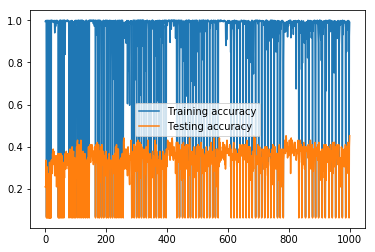

In [21]:
from matplotlib import pyplot as plt 
%matplotlib inline 
x_list =range(len(train_acc_list))

plt.plot(x_list, train_acc_list, label='Training accuracy')
plt.plot(x_list, test_acc_list, label='Testing accuracy')
plt.legend()
plt.show()

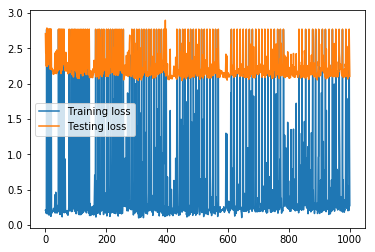

In [22]:
plt.plot(x_list, train_loss_list, label='Training loss')
plt.plot(x_list, test_loss_list, label='Testing loss')
plt.legend()
plt.show()